## Imports and Global Definitions

In [1]:
import pandas as pd
import numpy as np
import time
import datetime
import sys
import calendar

import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append("/home/piyush/modeling/my_python_project/lib/")
from ts import tsdata_utils as tu
from ts import research_utils as ru
from ts import rm_utils as rmu
from ts import plot_utils as pu


from tsmoothie.smoother import *
from tslearn.metrics import lcss as tslearn_metrics_lcss
from tslearn.clustering import TimeSeriesKMeans, KShape

from joblib import Parallel, delayed

from numba import njit

@njit
def is_year_month_parity(yyyymmdd : str):
    return 1 if int(yyyymmdd/10000) % 2 == int((yyyymmdd - int(yyyymmdd/10000) * 10000)/100) % 2 else 0

def get_insample(df_inp):
    ## year-month parity - 
    df_inp['YYYYMMDD'] =  np.array(list(map(lambda v: int(str(v.date()).replace('-','')), df_inp.index)))
    df_inp['flag'] = df_inp['YYYYMMDD'].apply(lambda v: is_year_month_parity(v))
    df_inp = df_inp[df_inp['flag'] == 1]
    df_inp = df_inp.drop(columns=['YYYYMMDD', 'flag'])
    return df_inp

Loading BokehJS ...

In [2]:
uri = "/home/piyush/modeling/tsdata/nse/returns/market_adjusted/cm/EQ/versions/8-60-True"
univ_uri = "/home/piyush/modeling/tsdata/nse/universes/cm/EQ"
trading_univ_uri = "/home/piyush/modeling/tsdata/nse/universes/cm/EQ.trading"


def get_panel(sd, ed):
    
    df_ret = tu.read_table(uri, sd, ed)
    df_univ = tu.read_table(univ_uri, sd, ed)
    
    if df_ret is None or len(df_ret) == 0 or df_univ is None or len(df_univ) == 0:
        return []
    
    df_ret = tu.left_join(df_univ, df_ret, keys=['SYMBOL'], strict_lookback=False)
    
    return df_ret



In [3]:
def get_normalized_timeseries(df_arg, col_to_normalize, keys=[]):
    
    df_arg_median = df_arg.groupby(keys)[[col_to_normalize]].median()
    df_arg = df_arg.reset_index().merge(df_arg_median.reset_index(), how='left', left_on=keys, right_on=keys, suffixes=("", "_median"))
    df_arg = df_arg.set_index('timestamp').sort_index()
    del df_arg_median

    df_arg[col_to_normalize+'_ad'] = abs(df_arg[col_to_normalize] - df_arg[col_to_normalize+'_median'])
    df_arg_mad = df_arg.groupby(keys)[[col_to_normalize+'_ad']].median().rename(columns={(col_to_normalize+'_ad') : col_to_normalize+"_mad"})
    df_arg = df_arg.reset_index().merge(df_arg_mad.reset_index(), how='left', left_on=keys, right_on=keys)
    df_arg = df_arg.set_index('timestamp').sort_index()
    del df_arg_mad

    df_arg[col_to_normalize+'_normed'] = df_arg[col_to_normalize+'_ad'] / df_arg[col_to_normalize+'_mad']
    df_arg = df_arg.drop(columns=[col_to_normalize+'_median', col_to_normalize+'_ad', col_to_normalize+'_mad'])

    return df_arg

def get_smoothed_series(data):
    # operate smoothing
    smoother = LowessSmoother(smooth_fraction=0.05, iterations=1)
    smoother.smooth(data)
    return smoother.smooth_data[0]

def get_time_series_matrix(df_arg, key_col='SYMBOL', timeseries_to_cluster="", pct_invalid_threshold=0.05):
    
    dfp = df_arg.reset_index().pivot(index='timestamp', columns=key_col,\
                                 values=timeseries_to_cluster)

    ## get the list of cols that have more than 'n_pct_th' % of their values set to NaN
    n_pct_th = pct_invalid_threshold
    cols = list(dfp.columns)
    vals = np.zeros(len(cols))
    for i in range(len(cols)):
        ser = dfp[cols[i]]
        vals[i] = len(ser[abs(ser) < 0.0000000001]) ## No. of values that are almost 0.
        vals[i] += len(ser[np.isnan(ser)])## No. of values are NaN.
        vals[i] += len(ser[np.isinf(ser)])## No. of values are inf.
        vals[i] /= len(ser)

    less_cols = np.array(cols)[vals < n_pct_th] ## cols that have less than 'n_pct_th'% of their values either 0 or NaN.
    pct = len(less_cols) / len(cols)
    print([pct, pct*len(cols), len(cols)])

    dfp = dfp[ less_cols ]
    col_names = list(dfp.columns)
    return [dfp.to_numpy(), col_names]




def get_eigen_portfolio_residualized_returns(df_arg, ret_type, secid_key='SYMBOL', cov_or_corr = "cov",\
                                        window_size=60, reg_window_size=20, strict_lookback=False,\
                                        n_signif_eigvecs = 5, pct_invalid_threshold=0.1):
    
    df_ret = df_arg[[secid_key, ret_type]]
    dfp = df_ret.reset_index().pivot(index='timestamp', columns=secid_key, values=ret_type)


    assert ( cov_or_corr in ["corr", "cov", "raw"] )

    ## get the list of cols that have more than 'n_pct_th' % of their values set to posinf, neginf, nan, zero
    n_pct_th = pct_invalid_threshold
    cols = list(dfp.columns)
    vals = np.zeros(len(cols))
    for i in range(len(cols)):
        ser = dfp[cols[i]]
        vals[i] = len(ser[abs(ser) < 0.0000000001]) ## No. of values that are almost 0.
        vals[i] += len(ser[np.isnan(ser)])## No. of values are NaN.
        vals[i] += len(ser[np.isneginf(ser)])## No. of values are inf.
        vals[i] += len(ser[np.isposinf(ser)])## No. of values are inf.
        vals[i] /= len(ser)

    less_cols = np.array(cols)[vals < n_pct_th] ## cols that have less than 'n_pct_th'% of their values either 0 or NaN.
    pct = len(less_cols) / len(cols)

    dfp = dfp[ less_cols ]

    col_names = list(dfp.columns)
    orig_indices = dfp.index
    X = dfp.to_numpy()

    X = np.nan_to_num(X, 0)

    ## Computing rolling PCA

    rolling_windows = np.lib.stride_tricks.sliding_window_view(X, window_shape=window_size, axis=0).transpose(0, 2, 1)

    M_rolling = rolling_windows


    if cov_or_corr == "corr":
        M_mean_rolling = np.mean(M_rolling, axis=1)
        M_std_rolling = np.std(M_rolling, axis=1)
        M_rolling = (M_rolling - M_mean_rolling[:, np.newaxis,:]) / M_std_rolling[:,np.newaxis,:]

        M_rolling = np.nan_to_num(M_rolling, 0.0000001)

        ## Note: 
        ##    At this point, it is possible that M_rolling has some nans or posinf or neginf. 
        ##    These are most likely a result of divide by zero (stdev for some columns may be 0)   
        ##    However, we expect this to happed very rarely as we have removed all those instruments whose time-series
        ##    have a high % of posinf, neginf, nan and zeross.

    elif cov_or_corr == "cov":
        
        M_mean_rolling = np.mean(M_rolling, axis=1)
        M_rolling = M_rolling - M_mean_rolling[:, np.newaxis,:]

    elif cov_or_corr == "raw":
        
        ## do nothing
        pass
    
    else:
        raise("Unsupported value of the argument: 'cov_or_corr'")



    MT_rolling = np.einsum("tij -> tji", M_rolling)
    MTM_rolling = np.einsum("tij,tjk -> tik", MT_rolling, M_rolling) 

    Sigma_rolling = MTM_rolling / X.shape[0]
    eigvals, eigvecs = np.linalg.eig(Sigma_rolling)

    eigvals = eigvals.real
    eigvecs = eigvecs.real

    
    ## Sort each rolling eig decomposition in decreasing order of its eigenvalues
    decreasing_eigval_order = np.argsort(-1*eigvals.real, axis=1)
    eigvals = np.stack([ eigvals[i][ decreasing_eigval_order[i] ]  for i in range(decreasing_eigval_order.shape[0]) ], axis=0)
    eigvecs = np.stack([ eigvecs[i][:, decreasing_eigval_order[i] ]  for i in range(decreasing_eigval_order.shape[0]) ], axis=0)
    
    
    ## put together all the rolling eigen decomposition results in a dataframe

    df_ev_list = [ pd.DataFrame(eigvecs[i], \
                                columns=["eigvec_%s" % str(i) for i in range(eigvecs.shape[2])], \
                                index=pd.Index(col_names, name=secid_key)\
                               ) \
                   for i in range(eigvecs.shape[0])\
                 ]

    if not strict_lookback:
        df_ev = pd.DataFrame({"eigen_vectors" : df_ev_list}, index=orig_indices[window_size-1:])

    else:
        df_ev = pd.DataFrame({"eigen_vectors" : df_ev_list[:-1]}, index=orig_indices[window_size:])



    ## make the sign of all the eigen vectors consistent with the eigen vectors in the first cov/corr matrix
    ##in the rolling windows

    def compute_angle(mat2cols):
        v1 = mat2cols[:, 0]
        v2 = mat2cols[:, 1]
        return round(np.dot(v1, v2) / np.sqrt( np.dot(v1, v1)*np.dot(v2, v2) ), 2)

    for idx in range(n_signif_eigvecs):
        df_ev['angle_ev%s' % str(idx)] = df_ev.apply(lambda row: compute_angle( row['eigen_vectors'][['eigvec_%s' % str(idx)]]\
                                                                       .merge( df_ev.iloc[0]['eigen_vectors'][['eigvec_%s' % str(idx)]], \
                                                                              how='left', left_index=True, right_index=True, \
                                                                              suffixes=("_x", "_y"))\
                                                                       .to_numpy()), axis=1)

    mult = np.ones( (n_signif_eigvecs, len(df_ev)) )
    for e_idx in range(n_signif_eigvecs):
        for idx in range(1, len(df_ev)):
            if np.sign(df_ev.iloc[idx]['angle_ev%s' % str(e_idx)]) < 0:
                mult[e_idx, idx] = -1
            else:
                mult[e_idx, idx] = 1

    for idx in range(n_signif_eigvecs):
        df_ev['mult_%s' % str(idx)] = pd.DataFrame(mult[idx,:], index=df_ev.index)

    df_comb = tu.left_join(dfp, df_ev, strict_lookback=False)

    
    ## compute eigen portfolio returns.
    
    def get_returns(row, df_evecs, ev_idx):
        mult = row['mult_%s' % str(ev_idx)]
        series_vec = df_evecs['eigvec_%s' % str(ev_idx)] * mult
        return sum([ series_vec.iloc[idx] * row[series_vec.index[idx]] for idx in range(len(series_vec)) ])

    ev_ret_cols = []
    for ev_index in range(n_signif_eigvecs):
        new_col = 'ret_ev%s' % str(ev_index)
        ev_ret_cols.append(new_col)
        df_comb[new_col] = df_comb.apply(lambda row: None if row['eigen_vectors'] is None or not isinstance(row['eigen_vectors'], pd.DataFrame) else\
                                                            get_returns(row, row["eigen_vectors"], ev_index)
                                           , axis=1)

    df_ev_rets = df_comb[ev_ret_cols]


    ## compute rolling betas to expanding subsets of the eigenvector portfolio returns - 
    
    ## Note that we use all the instruments in the 'df_arg' and not just the ones
    ## that were used to compute the rolling PCA because of the low proportion
    ## of posinf, neginf, nan and zeros in their time series.
    df_ret = tu.left_join(df_arg, df_ev_rets, keys = [], strict_lookback=False) 
    
    use_intercept = True
    xcols_list = [ "ret_ev%s" % str(i) for i in range(n_signif_eigvecs) ]

    if use_intercept:
        xcols_list = ['intercept'] + xcols_list
        df_ret['intercept'] = 1

    
    df_ret = tu.rolling_ols_beta(df_inp=df_ret,\
                        reg_name="regpca",\
                        x_cols_list=xcols_list,\
                        y_col=ret_type,\
                        use_intercept=False,\
                        window=reg_window_size,\
                        keys=[secid_key],\
                        strict_lookback=False,\
                        fill_na=True,\
                        fill_na_with=0.0,\
                        only_beta=True,\
                        _debug=False)
    
    ## compute residualized returns
    
    t1 = time.time()
    beta = df_ret[[ "regpca_%s_beta" % xcol  for xcol in xcols_list ]].to_numpy()
    beta = np.nan_to_num(beta, 0)
    if len(beta.shape) == 1:
        beta = beta[:, None]
    
    X = df_ret[ xcols_list ]
    X = np.nan_to_num(X, 0)
    if len(X.shape) == 1:
        X = X[:, None]
    
    r = df_ret[[ret_type]].to_numpy()
    r = np.nan_to_num(r, 0)
    
    if len(r.shape) == 1:
        r = r[:, None]
    
    r_exp = np.einsum("ij,ij -> i", X, beta)
    
    if len(r_exp.shape) == 1:
        r_exp = r_exp[:, None]
    
    r_resid = r - r_exp
    r_resid = np.squeeze(r_resid)
    
    df_ret[ret_type + "_residpcas"] = pd.DataFrame(r_resid, index=df_ret.index)
    
    ## drop all columns that start with "regpca"
    cols_to_keep = [ c for c in df_ret.columns if not c.startswith('regpca') ]
    df_ret = df_ret[cols_to_keep]
    
    df_ret = df_ret.drop(columns=ev_ret_cols)
    
    if use_intercept:
        df_ret = df_ret.drop(columns=['intercept'])
    #
    
    
    return [df_ret, df_ev_rets]




In [ ]:
"""
df = get_panel("20170101", "20171231")
ret = get_eigen_portfolio_residualized_returns(df_arg=df, ret_type="open2open_lagging_1dret_robust", secid_key='SYMBOL', cov_or_corr = "raw",\
                                        window_size=60, reg_window_size=20, strict_lookback=False,\
                                        n_signif_eigvecs = 1, pct_invalid_threshold=0.1)

df_ret = ret[0]
df_ev_ret = ret[1]
"""

## Exploratory Analysis

In [ ]:
#sd = '20170101'
#ed = "20171231"

sd = '20171222'
ed = "20171231"

df_ret = tu.read_table(uri, sd, ed)
df_univ = tu.read_table(univ_uri, sd, ed)
df_ret = tu.left_join(df_univ, df_ret, keys=['SYMBOL'], strict_lookback=False)

df_ret.head(2)
#print(df_ret.columns)

### comparing various distance metrics

In [ ]:
import tslearn
ril  = df_ret[df_ret['SYMBOL'] == 'NTPC']['open2open_lagging_1dret_robust'].dropna().to_numpy()[-50:]
ril  = ril / np.std(ril) 
ril_s = get_smoothed_series(ril)

sbin = df_ret[df_ret['SYMBOL'] == 'HDFCBANK']['open2open_lagging_1dret_robust'].dropna().to_numpy()[-50:]
sbin = sbin / np.std(sbin)
sbin_s = get_smoothed_series(sbin)

[tslearn.metrics.lcss(ril, sbin)]#, tslearn.metrics.lcss(ril_s, sbin_s)]
#display([tslearn.metrics.dtw(ril, sbin), tslearn.metrics.dtw(ril_s, sbin_s)])

def par_run(symbols, i, mat):
    dict_list = []
    m = np.nan_to_num(mat.copy(), 0)
    for j in range(len(symbols)):
        if i != j:
            try:
                x  = m[:, i]
                x  = x / np.std(x) 
                y  = m[:, j]
                y  = y / np.std(y) 
                d1 = tslearn.metrics.lcss(x, y)
                d2 = tslearn.metrics.dtw(x, y)
                d3 = np.sqrt(np.sum(np.power(x - y, 2)))
            except ZeroDivisionError as z:
                d1 = np.nan
                d2 = np.nan
                d3 = np.nan
            dict_list.append({'s1' : symbols[i], 's2' : symbols[j], "lcss" : d1, "dtw" : d2, "euclid" : d3})
    return dict_list

#dfp = df_ret.reset_index().pivot(index="timestamp", columns='SYMBOL', values='open2open_lagging_1dret_mktadj_robust')
dfp = df_ret.reset_index().pivot(index="timestamp", columns='SYMBOL', values='open2open_lagging_1dret_robust')
mat = dfp.to_numpy()
symbols = list(dfp.columns)

from joblib import Parallel, delayed
res_list = Parallel(n_jobs=15)(delayed(par_run)(symbols, i, mat) for i in range(len(symbols)))
#par_run(symbols, 0, mat)

In [ ]:
lst = res_list[0]
for i in range(1, len(res_list)):
    lst += res_list[i]
df_dist = pd.DataFrame(lst)

display(df_dist[['lcss', 'dtw', 'euclid']].corr())

df_dist.plot.scatter(x="euclid", y='lcss')
df_dist.plot.scatter(x="euclid", y='dtw')
df_dist.plot.scatter(x="dtw", y='lcss')

In [ ]:
lst = res_list[0]
for i in range(1, len(res_list)):
    lst += res_list[i]
pd.DataFrame(lst)['lcss'].plot.hist(bins=50)
pd.DataFrame(lst)[['lcss']].describe([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).transpose()

In [ ]:
lst = res_list[0]
for i in range(1, len(res_list)):
    lst += res_list[i]
pd.DataFrame(lst)['lcss'].plot.hist(bins=50)
pd.DataFrame(lst)[['lcss']].describe([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).transpose()

### trying out various clustering algorithms

In [ ]:
##################################################################


df_panel = df_ret.copy()

#ret_type = 'open2open_lagging_1dret'
#ret_type = 'open2open_lagging_1dret_robust'
ret_type = 'open2open_lagging_1dret_mktadj_robust'
#ret_type = 'intraday_ret'

timeseries_to_cluster = ret_type
#timeseries_to_cluster = "log_volume_normed"


if 0:
    pca_pct_invalid_threshold = 0.1

    ret = get_eigen_portfolio_residualized_returns(df_arg=df_panel, \
                                                 ret_type=ret_type, \
                                                 secid_key='SYMBOL', \
                                                 cov_or_corr = "raw",\
                                                 window_size=60, \
                                                 reg_window_size=20,\
                                                 strict_lookback=False,\
                                                 n_signif_eigvecs = 20, \
                                                 pct_invalid_threshold=0.1)

    df_ret = ret[0]
    df_ev_rets = ret[1]

    df_panel = df_ret

    timeseries_to_cluster = ret_type + "_residpcas"


    ## removing the extended period that was needed to perform the rolling PCA calculations.
    #df_train = df_train.iloc[rolling_pca_window_size:]

else:

    timeseries_to_cluster = ret_type



retmat, col_names = get_time_series_matrix(df_arg=df_panel, key_col="SYMBOL",\
                timeseries_to_cluster=timeseries_to_cluster,\
                pct_invalid_threshold=0.05)

## set Nans to Zeros.
retmat = np.nan_to_num(retmat, 0)

if True:
    ## de-mean each column in 'retmat' so that it has a mean of 0.0
    retmat = retmat - np.mean(retmat, axis=0)

if True:
    ## normalize each column in 'retmat' so that it has a std of 1.0
    retmat = retmat / np.std(retmat, axis=0)

if False:
    ## TRYING THE ANALYSIS WITH CUMULATIVE RETURNS ONCE!!
    retmat = np.cumsum(retmat, axis=0)

if False:
    b4 = time.time()
    retmat_lowess = np.hstack([ get_smoothed_series(retmat[:,colIdx])[:,np.newaxis]\
                               for colIdx in range(retmat.shape[1])])
    after = time.time()
    print(after-b4)
else:
    retmat_lowess = retmat

####

In [ ]:
b4 = time.time()

n_clusters = 10

if False:
    
    if True:
        model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean",
                                 max_iter=1000, random_state=0, 
                                 n_jobs=15)
    elif False:
        from tslearn.clustering import KShape
        model = KShape(n_clusters=n_clusters, 
                                 max_iter=1000, random_state=0)
    elif False:
        pass

    X_train = retmat_lowess.T
    display(X_train.shape)
    model.fit(X_train)

    after = time.time()


    display(model.labels_.shape)

    L = list(set(list(model.labels_)))

    dfz = pd.DataFrame(dict(zip([str(i) for i in L], [  [ list( np.array(col_names)[[i for i in range(len(model.labels_)) if model.labels_[i] == l ]]) ] for l in L]  )))
    dfz.columns.name = 'cluster'
    dfz = dfz.transpose().reset_index().rename(columns={0: "inst"})
    dfz['size'] = dfz['inst'].apply(lambda v: len(v))
    
else:
    
    from pyclustering.cluster.kmedoids import kmedoids
    from pyclustering.cluster.xmeans import xmeans, splitting_type

    start_medoids = np.random.choice(np.arange(retmat_lowess.T.shape[0]), size=n_clusters)
    if False:
        model = kmedoids(data=retmat_lowess.T, initial_index_medoids=start_medoids)
        
        #model = xmeans(data=retmat_lowess.T, initial_centers= None, kmax=n_clusters, criterion=splitting_type.MINIMUM_NOISELESS_DESCRIPTION_LENGTH)
        
    else:
        import tslearn
        from pyclustering.utils import distance_metric, type_metric
        
        user_function = lambda ts1, ts2: 1.0 - tslearn.metrics.lcss(ts1, ts2)
        metric = distance_metric(type_metric.USER_DEFINED, func=user_function)
        
        model = kmedoids(data=retmat_lowess.T, initial_index_medoids=start_medoids, metric=metric)
    
    
    res = model.process()
    clusters = model.get_clusters()

    _k = [i for i in range(len(clusters))]
    _v = [ [list(np.array(col_names)[clusters[i]])] for i in range(len(clusters)) ]
    print(len(_k), len(_v))
    dfz = pd.DataFrame(dict(zip( _k, _v )))
    dfz.columns.name = 'cluster'
    dfz = dfz.transpose().reset_index().rename(columns={0: "inst"})
    dfz['size'] = dfz['inst'].apply(lambda v: len(v))
    dfz

###

display(dfz)

In [ ]:
if False:
    x = np.hstack([ np.mean(retmat_lowess[:, [ col_names.index(inst) for inst in dfz.iloc[cluster_id]['inst']]], axis=1)[:, np.newaxis] for cluster_id in range(n_clusters) ])
    plt.plot(x)

In [ ]:
ret = 'open2open_leading_1dret'
#ret = 'intraday_ret'

dfperf = df_ret\
            .reset_index('timestamp')\
            .merge(\
                       dfz.explode('inst').rename(columns={'inst':'SYMBOL'}), \
                       how='left', left_on='SYMBOL', right_on="SYMBOL"\
                  )\
            .set_index('timestamp')\
            .sort_index()\
            [['SYMBOL', ret, 'cluster']]\
            .dropna(axis=0, subset=['cluster'])\
            .groupby(['timestamp', 'cluster'])\
            [[ret]]\
            .mean()\
            .reset_index(1)\
            .reset_index()\
            .pivot(index='timestamp', columns="cluster", values=ret)

dfperf.cumsum().plot(figsize=(10,10), title="unnormalized")

if True:
    dfperf_sd = dfperf.rolling(20, min_periods=20).std()
    dfperf = dfperf / dfperf_sd
    
dfperf.cumsum().plot(figsize=(10,10), title="normalized")


dfd = dfperf.describe().transpose()
dfd['annSr'] = np.sqrt(252) * dfd['mean'] / dfd['std']
dfd = dfd.sort_values(['annSr'])
display(dfd)

dfperf_all = pd.DataFrame(dfperf.sum(axis=1)).rename(columns={0: "all"})
if False:
    dfperf_all_sd = dfperf_all.rolling(20, min_periods=20).std()
    dfperf_all = dfperf_all / dfperf_all_sd
dfperf_all.cumsum().plot()

dfd2 = dfperf_all.describe().transpose()
dfd2['annSr'] = np.sqrt(252) * dfd2['mean'] / dfd2['std']
dfd2 = dfd2.sort_values(['annSr'])
dfd2

In [ ]:
dfperf

In [ ]:
w_o = dfd[['annSr']].sort_index().to_numpy()
w = w_o - np.mean(w_o, axis=0)

P = dfperf.dropna().to_numpy()

r = np.matmul(P, w)
r = np.squeeze(r)
plt.plot(np.cumsum(r))

In [ ]:
np.sqrt(252) * np.mean(r) / np.std(r)

## Monetization

In [4]:
######################################
## modeling / design choices
#####################################

use_eigen_portfolio_resid_version = False
rolling_reg_window_size = 20    ## for rolling residualization of raw returns for the PCA returns. 
                                     ## Note: this parameter should be usually smaller than the 'window_size' param.
rolling_pca_window_size = 3*rolling_reg_window_size   ## for rolling PCA calculation
n_signif_eigvecs = 5


## the time series size for which Time Series Clustering is performed
#lb_days = int(365*0.025)
lb_days = int(365*0.025)

#ret_to_use_in_monetization = 'next_open2open_leading_1dret'
#ret_to_use_in_monetization = 'open2open_leading_1dret'
#ret_to_use_in_monetization = 'next_intraday_ret'
ret_to_use_in_monetization = 'intraday_ret'


#ret_to_use_in_monetization_train = 'open2open_lagging_1dret'
ret_to_use_in_monetization_train = 'open2open_lagging_1dret_mktadj'


#ret_to_use_for_clustering = 'open2open_lagging_1dret_robust' ##<-------------------
ret_to_use_for_clustering = 'open2open_lagging_1dret_mktadj_robust'




pct_invalid_threshold    = 0.05  ## 0.05
demean_timeseries        = True ## False
standardize_timeseries   = True  ## True
cumsum_timeseries        = False  ## True
smoothen_timeseries      = False
n_clusters               = 20

#market_beta_for_pcr = "prev_" + ret_to_use_in_monetization_train + "_market_beta"
market_beta_for_pcr = None



def run(start_date, next_start_date, lb_days=365):
    
    ####################################################################
    ## define proper time contexts for the 'train' and 'test' datasets
    ## and load them into memory.
    ####################################################################
    
    month_start = start_date
    month_end = (datetime.datetime.strptime(next_start_date, '%Y%m%d') - datetime.timedelta(days=1)).strftime("%Y%m%d")
    
    if month_end < month_start:
        month_end = month_start
    
    print([month_start, month_end])  ## no longer an appropriate nomenclature.
    
    if use_eigen_portfolio_resid_version:
        learning_range_start = (datetime.datetime.strptime(month_start, "%Y%m%d") - datetime.timedelta(days=(lb_days+2*rolling_pca_window_size) )).strftime('%Y%m%d')
    else:
        learning_range_start = (datetime.datetime.strptime(month_start, "%Y%m%d") - datetime.timedelta(days=lb_days )).strftime('%Y%m%d')
        
    learning_range_end = (datetime.datetime.strptime(month_start, "%Y%m%d") - datetime.timedelta(days=1)).strftime('%Y%m%d')

    print([learning_range_start, learning_range_end])
    
    
    ## get 'train' and 'test' datasets
    
    
    df_data = get_panel(sd=learning_range_start, ed=month_end)
    
    beta_cols = [c for c in df_data.columns if c.endswith("_market_beta")]
    df_data = tu.shift(df_inp=df_data, keys=["SYMBOL"], cols=beta_cols, periods=1, prefix="prev_")
    

    df_train = df_data[df_data.index <= learning_range_end]
    df_test  = df_data[df_data.index >= month_start]

    
    if len(df_train) == 0 or len(df_test) == 0:
        return [ [], [], [], [] ]
    
    
    
    
    
    ##########################################################
    ## Get the eigen portfolio residualized returns.
    ##
    ##########################################################
    if use_eigen_portfolio_resid_version:
        pca_pct_invalid_threshold = 0.1
        
        ret = get_eigen_portfolio_residualized_returns(df_arg=df_train, \
                                                     ret_type=ret_to_use_for_clustering, \
                                                     secid_key='SYMBOL', \
                                                     cov_or_corr = "cov",\
                                                     window_size=rolling_pca_window_size, \
                                                     reg_window_size=rolling_reg_window_size,\
                                                     strict_lookback=False,\
                                                     n_signif_eigvecs = n_signif_eigvecs, \
                                                     pct_invalid_threshold=pca_pct_invalid_threshold)

        df_ret = ret[0]
        df_ev_rets = ret[1]

        df_train = df_ret
        
        timeseries_to_cluster = ret_to_use_for_clustering + "_residpcas"
        
        
        ## removing the extended period that was needed to perform the rolling PCA calculations.
        df_train = df_train.iloc[rolling_pca_window_size:]
    
    else:
        
        timeseries_to_cluster = ret_to_use_for_clustering
    
    
    
    
    
    #########################
    ## Train the model - 
    #########################
    
    retmat, col_names = get_time_series_matrix(df_arg=df_train, key_col="SYMBOL",\
                    timeseries_to_cluster=timeseries_to_cluster,\
                    pct_invalid_threshold=pct_invalid_threshold)
    
    col_names = np.array(col_names)

    ## set Nans to Zeros.
    retmat = np.nan_to_num(retmat, 0)
    
    if demean_timeseries:
        retmat = retmat - np.mean(retmat, axis=0)

    if standardize_timeseries:
        ## normalize each column in 'retmat' so that it has a std of 1.0
        retmat = retmat / np.std(retmat, axis=0)
        
        ## if any of the columns in 'retmat' contains Inf, then drop the entire column and also update the list 'col_names'.
        is_inf = np.isneginf(retmat) | np.isposinf(retmat) | np.isnan(retmat)
        cols_with_atleast_one_inf = np.any(is_inf, axis=0)
        indices_to_keep = list(np.logical_not( cols_with_atleast_one_inf ))
        
        retmat = retmat[:, indices_to_keep]
        col_names = col_names[indices_to_keep]
        
        if len(col_names) == 0:
            return [ [], [], [], [] ]
    
        

    if cumsum_timeseries:
        retmat = np.cumsum(retmat, axis=0)

    if smoothen_timeseries:
        retmat_lowess = np.hstack([ get_smoothed_series(retmat[:,colIdx])[:,np.newaxis]\
                                   for colIdx in range(retmat.shape[1])])
        
    else:
        retmat_lowess = retmat
    
    
    ## Do time series clustering.
    
    ## Note: TimeSeriesKMeans can be used to do a correlation based clustering of 
    ##       collection of time series if you subtract their sample means and then
    ##       divide it their sample standard deviations; then, use the Euclidean
    ##       distance measure in the clustering algorithm.
    ##
    ##       Here is how - 
    ##
    ##       Let x, y be two "normalized" time series of equal length
    ##   
    ##       Correlation(x[:], y[:]) 
    ##               = rho(x, y)
    ##               = (1/n) *  \Sum_{i: 1->n} (x[i]-mean(x[:]))*(y[i]-mean(y[:])) / (stdev(x[:]) * stdev(y[:]))
    ##
    ##       EuclideanDistance(x[:], y[:])
    ##               = euclid(x,y) 
    ##               = \Sum_{i: 1->n} [ (x[i]-mean(x[:]))/stdev(x[:]) - (y[i]-mean(y[:]))/stdev(y[:]) ]^2
    ##               = {\Sum_{i: 1->n} [(x[i]-mean(x[:]))/stdev(x[:])]^2} 
    ##                   + {\Sum_{i: 1->n} [(y[i]-mean(y[:]))/stdev(y[:])]^2}
    ##                   - 2 * {\Sum_{i: 1->n} (x[i]-mean(x[:]))*(y[i]-mean(y[:])) / (stdev(x[:]) * stdev(y[:]))} 
    ##               = {n*std(x[:])/std(x[:])} + {n*std(y[:])/std(y[:])} - 2 * n * rho(x[:], y[:])
    ##               = 2*n - 2*n*rho(x[:], y[:])
    ##               = 2 * n * ( 1- rho(x[:], y[:]))
    ##
    ##       Or, euclid(x, y) = 2*n*(1 - rho(x,y)) ---- (1)
    ##       
    ##       From Eq (1), we can see that higher the correlation b/w two "normalized" time series, smaller is the
    ##       Euclidean distance between them.
    ##                                                  
    
    if False:
        if True:
            model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean",
                                     max_iter=1000, random_state=0, 
                                     n_jobs=1)
        elif False:
            model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",
                                     max_iter=1000, random_state=0, 
                                     n_jobs=1)
        elif False:
            model = KShape(n_clusters=n_clusters, 
                                     max_iter=1000, random_state=0)

        X_train = retmat_lowess.T ## each of the rows in X_train denotes one time series.

        try:
            model.fit(X_train)
        except Exception as exception:
            print("X_train.shape -> ", X_train.shape)
            raise(exception)

        unique_cluster_labels = list(set(list(model.labels_)))
        
        df_clusters = pd.DataFrame(dict(zip(unique_cluster_labels, [  [ list( col_names[[i for i in range(len(model.labels_)) if model.labels_[i] == l ]]) ] for l in unique_cluster_labels]  )))
        df_clusters.columns.name = 'cluster'
        df_clusters = df_clusters.transpose().reset_index().rename(columns={0: "SYMBOL"})
        df_clusters['size'] = df_clusters['SYMBOL'].apply(lambda v: len(v))
        df_clusters = df_clusters.explode("SYMBOL")
        df_clusters = df_clusters.astype({'cluster' : str})
        
    else:
        #import tslearn
        from pyclustering.cluster.kmedoids import kmedoids
        from pyclustering.cluster.xmeans import xmeans, splitting_type
        from pyclustering.utils.metric import distance_metric, type_metric

        start_medoids = np.random.choice(np.arange(retmat_lowess.T.shape[0]), size=n_clusters)
        
        
        if 0:
            user_function = lambda ts1, ts2: 1.0 - tslearn_metrics_lcss(ts1, ts2)
            metric = distance_metric(type_metric.USER_DEFINED, func=user_function)
            model = kmedoids(data=retmat_lowess.T, initial_index_medoids=start_medoids, metric=metric)
        
        if 1:
            model = kmedoids(data=retmat_lowess.T, initial_index_medoids=start_medoids, metric=distance_metric(type_metric.EUCLIDEAN))
        
        res = model.process()
        clusters = model.get_clusters()

        _k = [i for i in range(len(clusters))]
        _v = [ [list(np.array(col_names)[clusters[i]])] for i in range(len(clusters)) ]
        df_clusters = pd.DataFrame(dict(zip( _k, _v )))
        df_clusters.columns.name = 'cluster'
        df_clusters = df_clusters.transpose().reset_index().rename(columns={0: "SYMBOL"})
        df_clusters['size'] = df_clusters['SYMBOL'].apply(lambda v: len(v))
        df_clusters = df_clusters.explode("SYMBOL")
        df_clusters = df_clusters.astype({'cluster' : str})
    
    
    
    #display(df_clusters)
    
    ## add cluster label to each instrumet in the 'train' dataset
    df_train = df_train.reset_index('timestamp').merge(df_clusters, how='left', left_on='SYMBOL', right_on="SYMBOL").set_index('timestamp').sort_index()
    df_train['cluster'] = df_train['cluster'].fillna('NA')
    
    
    
    ###############################
    ### Monetize the model - 
    ###############################
    
    
    df_test = df_test.reset_index('timestamp').merge(df_clusters, how='left', left_on='SYMBOL', right_on="SYMBOL").set_index('timestamp').sort_index()
    df_test['cluster'] = df_test['cluster'].fillna('NA')
    
    
    ## (1)
    ## - get the sharpe of each cluster using unsmoothed returns
    ## - cross sectionally z-score the cluster sharpes, or, could use the sharpes as well.
    ## - equal-weight, (1/vol)-weight, (rootadv/vol)-weight all the stocks in a cluster and then multiply these weights 
    ##   by the cluster's sharpe (over the 'train' period) to get the forecast for a SYMBOL.
    
    ## We compute the Sharpe ratio for each cluster using the sum of equal weighted returns of stocks in that cluster.
    ## We drop all those stocks in the 'test' dataset that do not have a cluster assigned to them (perhaps because 
    ## they were not included in the time series clustering step due to having too many invalid entries in their timeseries)
    df_cluster_pnl_train = df_train.dropna(axis=0, subset=['cluster']).groupby(['timestamp','cluster'])[[ret_to_use_in_monetization_train]].sum() 
    df_cluster_pnl_train = df_cluster_pnl_train.reset_index().pivot(index='timestamp', columns='cluster', values=ret_to_use_in_monetization_train)
    df_cluster_shapes_train = df_cluster_pnl_train.describe().transpose()
    df_cluster_shapes_train['annSharpe'] = np.sqrt(252) * df_cluster_shapes_train['mean'] / df_cluster_shapes_train['std']
    
    ## cross sectionally z-score the sharpes
    df_cluster_shapes_train['annSharpe_z'] = (df_cluster_shapes_train['annSharpe'] 
                                              - df_cluster_shapes_train['annSharpe'].median()) \
                                                / abs(df_cluster_shapes_train['annSharpe'] \
                                                - df_cluster_shapes_train['annSharpe'].median()) \
                                            .median()
    
    ## compute forecast for the 'test' dataset
    df_test['cluster_sharpe'] = df_test['cluster'].apply(lambda v: df_cluster_shapes_train.loc[v]['annSharpe'] if v != 'NA' else np.nan)
    df_test['cluster_sharpe_z'] = df_test['cluster'].apply(lambda v: df_cluster_shapes_train.loc[v]['annSharpe_z'] if v!= 'NA' else np.nan)
    
    ## equal weight being used to compute the position proxy
    df_test['pos_proxy'] = 1
    df_test['fcst_mon1_v1'] = df_test['cluster_sharpe']
    df_test['fcst_mon1_v2'] = df_test['cluster_sharpe_z']
    
    df_test['pnl_mon1_v1'] = df_test['pos_proxy'] * df_test['fcst_mon1_v1'] * df_test[ret_to_use_in_monetization]
    df_test['pnl_mon1_v2'] = df_test['pos_proxy'] * df_test['fcst_mon1_v2'] * df_test[ret_to_use_in_monetization]
    
    
    ## (2)
    ## a sector-momentum like strategy.
    ## - get cluster mean returns, (equal weighted)
    ## - score stocks based on their distance from their cluster mean, 
    ## - go long low score stocks and short high score stocks
    
    df_cluster_pnl_train = df_train.dropna(axis=0, subset=['cluster']).groupby(['timestamp','cluster'])[[ret_to_use_in_monetization_train]].mean() ## notice the mean
    df_cluster_cumret_train = df_cluster_pnl_train.groupby('cluster')[ret_to_use_in_monetization_train].sum()
    df_inst_cumret_train = df_train.reset_index().pivot(index='timestamp', columns='SYMBOL', values=ret_to_use_in_monetization_train).sum()
    
    df_test['train_cumret'] = df_test['SYMBOL'].apply(lambda v: df_inst_cumret_train.loc[v] if v in df_inst_cumret_train.index else np.nan)
    df_test['train_cluster_cumret'] = df_test['cluster'].apply(lambda v: df_cluster_cumret_train.loc[v] if v != 'NA' else np.nan)
    df_test['diff'] = df_test['train_cumret'] - df_test['train_cluster_cumret']
    
    df_diff_csz_stats_test = df_test.dropna(axis=0, subset=['cluster']).groupby(['timestamp', 'cluster'])[['diff']].agg(['mean', 'std']).droplevel(axis=1, level=0).reset_index(1)
    
    df_test = tu.left_join(df_left=df_test, df_right=df_diff_csz_stats_test, keys=['cluster'], strict_lookback=False)
    
    df_test['fcst_mon2_v1'] = -1* (df_test['diff'] - df_test['mean'])
    df_test['fcst_mon2_v2'] = -1* (df_test['diff'])
    
    df_test['pnl_mon2_v1'] = df_test['pos_proxy'] * df_test['fcst_mon2_v1'] * df_test[ret_to_use_in_monetization]
    df_test['pnl_mon2_v2'] = df_test['pos_proxy'] * df_test['fcst_mon2_v2'] * df_test[ret_to_use_in_monetization]
    
    if market_beta_for_pcr is not None:
        df_test = ru.resid_pc(df_inp=df_test, \
                      secid_colname="SYMBOL", \
                      cols_to_residualize=["fcst_mon2_v1", "fcst_mon2_v2"],\
                      cols_to_residualize_for=[market_beta_for_pcr], \
                      keys=[], \
                      use_intercept=True,\
                     suffix="_pcr"
                    )
        df_test['pnl_mon2_v1_pcr'] = df_test['pos_proxy'] * df_test['fcst_mon2_v1_pcr'] * df_test[ret_to_use_in_monetization]
        df_test['pnl_mon2_v2_pcr'] = df_test['pos_proxy'] * df_test['fcst_mon2_v2_pcr'] * df_test[ret_to_use_in_monetization]
        
    else:
        df_test['fcst_mon2_v1_pcr'] = df_test['fcst_mon2_v1']
        df_test['pnl_mon2_v1_pcr'] = df_test['pos_proxy'] * df_test['fcst_mon2_v1_pcr'] * df_test[ret_to_use_in_monetization]
        
        df_test['fcst_mon2_v2_pcr'] = df_test['fcst_mon2_v2']
        df_test['pnl_mon2_v2_pcr'] = df_test['pos_proxy'] * df_test['fcst_mon2_v2_pcr'] * df_test[ret_to_use_in_monetization]
    
    
    
    ## compute forecast vectors to use during the 'test': timestamp | SYMBOL | cluster_id | fcst
    
    fcst_cols = ['fcst_mon1_v1', 'fcst_mon1_v2', 'fcst_mon2_v1', 'fcst_mon2_v1_pcr', 'fcst_mon2_v2', 'fcst_mon2_v2_pcr']
    pnl_cols  = ['pnl_mon1_v1', 'pnl_mon1_v2', 'pnl_mon2_v1', 'pnl_mon2_v1_pcr', 'pnl_mon2_v2', 'pnl_mon2_v2_pcr']
    
    df_test = df_test[ ['SYMBOL', 'cluster'] + fcst_cols + pnl_cols]
    
        
    return [df_clusters, df_test, fcst_cols, pnl_cols]



sim_start_date = '20160601'
sim_end_date = '20221111'
freq = '1d'
date_list = list(map(lambda d: d.strftime('%Y%m%d'), pd.date_range(sim_start_date, sim_end_date, freq=freq)))
if freq != '1d':
    date_list = [sim_start_date] + date_list
#print(date_list)



#x = run("20181025", "20181026")

if False:
    ret_list = []
    for idx in range(len(date_list)-1):
    #for idx in [0]:
        print('----------------------------------------------------')
        df = run(date_list[idx], date_list[idx+1], lb_days=lb_days)
        ret_list.append(df)            
elif True:
    args_list = []
    for idx in range(len(date_list)-1):
        args_list.append( (date_list[idx], date_list[idx+1],) )
    
    from joblib import Parallel, delayed
    ret_list = Parallel(n_jobs=15)(delayed(run)(args[0], args[1], lb_days) for args in args_list)


##ret_list

df_fcst = pd.concat([ ele[1] for ele in ret_list if len(ele[1]) > 0], axis=0).sort_index()


'''
    TODO: Constrain the forecast to instruments in the trading universe. (currently, we have used the "staging" universe.)
'''

df_pnl = df_fcst.groupby('timestamp')[ [c for c in df_fcst.columns if c.startswith("pnl_")] ].sum()

'''
    TODO: Do vol conditioning of the forecast.
'''

df_pnl['mean'] = df_pnl['pnl_mon2_v1_pcr'].rolling(10, min_periods=5).mean()
df_pnl['vol'] = df_pnl['pnl_mon2_v1_pcr'].rolling(10, min_periods=5).std()
df_pnl['sr'] = df_pnl['mean'] / df_pnl['vol']
df_pnl['sr_demean'] = df_pnl['sr'] - df_pnl['sr'].rolling(10, min_periods=5).mean()
df_pnl['sr_demean'] = df_pnl['sr_demean'].shift(periods=1)
df_pnl['pnl_srcond'] = df_pnl['pnl_mon2_v1_pcr'] * (1 + df_pnl['sr_demean'].apply(lambda v:  v))

df_fcst['fcst_mon2_v1_pcr'] *= (1 + df_pnl['sr_demean'].apply(lambda v:  v))


## <df>_insample = get_insample(<df>)
df_fcst_insample = get_insample(df_fcst)
df_pnl_insample = get_insample(df_pnl)

['20160607', '20160607']
['20160529', '20160606']
['20160601', '20160601']
['20160523', '20160531']
['20160602', '20160602']
['20160524', '20160601']
['20160603', '20160603']
['20160525', '20160602']
['20160604', '20160604']
['20160526', '20160603']
['20160606', '20160606']
['20160528', '20160605']
['20160605', '20160605']
['20160527', '20160604']


  0%|          | 0/10 [00:00<?, ?it/s]

['20160608', '20160608']
['20160530', '20160607']
['20160612', '20160612']
['20160603', '20160611']
['20160609', '20160609']
['20160531', '20160608']
['20160610', '20160610']
['20160601', '20160609']
['20160614', '20160614']
['20160605', '20160613']
['20160611', '20160611']
['20160602', '20160610']
['20160613', '20160613']
['20160604', '20160612']
['20160615', '20160615']
['20160606', '20160614']
['20160616', '20160616']
['20160607', '20160615']
['20160617', '20160617']
['20160608', '20160616']


100%|██████████| 10/10 [00:00<00:00, 218.99it/s]

100%|██████████| 10/10 [00:00<00:00, 1746.54it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

['20160618', '20160618']
['20160609', '20160617']
['20160619', '20160619']
['20160610', '20160618']
['20160620', '20160620']
['20160611', '20160619']
['20160621', '20160621']
['20160612', '20160620']


100%|██████████| 10/10 [00:00<00:00, 321.36it/s]


[0.0, 0.0, 434]
['20160622', '20160622']
['20160613', '20160621']
[0.0, 0.0, 432]
['20160623', '20160623']
['20160614', '20160622']
[0.0, 0.0, 436]
['20160624', '20160624']
['20160615', '20160623']
[0.0, 0.0, 436]
['20160625', '20160625']
['20160616', '20160624']
[0.0, 0.0, 436]
['20160626', '20160626']
['20160617', '20160625']
[0.0, 0.0, 440]
['20160627', '20160627']
['20160618', '20160626']


100%|██████████| 10/10 [00:00<00:00, 2222.15it/s]


[0.0, 0.0, 441]
['20160628', '20160628']
['20160619', '20160627']
[0.0, 0.0, 439]
['20160629', '20160629']
['20160620', '20160628']
['20160630', '20160630']
['20160621', '20160629']
['20160701', '20160701']
['20160622', '20160630']
[0.7158836689038032, 320.0, 447]
['20160702', '20160702']
['20160623', '20160701']
[0.6943820224719102, 309.0, 445]
['20160703', '20160703']
['20160624', '20160702']
[0.7113636363636363, 313.0, 440]
['20160704', '20160704']
['20160625', '20160703']
['20160705', '20160705']
['20160626', '20160704']
['20160706', '20160706']
['20160627', '20160705']
[0.7348314606741573, 327.0, 445]
['20160707', '20160707']
['20160628', '20160706']


100%|██████████| 10/10 [00:00<00:00, 309.73it/s]

['20160708', '20160708']
['20160629', '20160707']
[0.7348314606741573, 327.0, 445]
['20160709', '20160709']
['20160630', '20160708']
[0.6859688195991092, 308.0, 449]
['20160710', '20160710']
['20160701', '20160709']
[0.7113636363636363, 313.0, 440]
['20160711', '20160711']
['20160702', '20160710']
[0.6928251121076233, 309.0, 446]
['20160712', '20160712']
['20160703', '20160711']
['20160713', '20160713']
['20160704', '20160712']
[0.7393258426966293, 329.0, 445]
['20160714', '20160714']
['20160705', '20160713']
['20160715', '20160715']
['20160706', '20160714']
[0.713963963963964, 317.0, 444]
['20160716', '20160716']
['20160707', '20160715']
[0.6897321428571429, 309.0, 448]
['20160717', '20160717']
['20160708', '20160716']



100%|██████████| 10/10 [00:00<00:00, 1879.59it/s]


['20160718', '20160718']
['20160709', '20160717']
['20160719', '20160719']
['20160710', '20160718']
[0.6965065502183406, 319.0, 458]
['20160720', '20160720']
['20160711', '20160719']
[0.6820175438596491, 311.0, 456]
['20160721', '20160721']
['20160712', '20160720']


100%|██████████| 10/10 [00:00<00:00, 307.64it/s]


[0.7393258426966293, 329.0, 445]
['20160722', '20160722']
['20160713', '20160721']


100%|██████████| 10/10 [00:00<00:00, 3013.37it/s]


[0.7086092715231788, 321.0, 453]
['20160723', '20160723']
['20160714', '20160722']
['20160724', '20160724']
['20160715', '20160723']


  0%|          | 0/10 [00:00<?, ?it/s]

['20160725', '20160725']
['20160716', '20160724']
[0.646551724137931, 300.0, 464]
['20160726', '20160726']
['20160717', '20160725']
[0.6623093681917211, 304.0, 459]
['20160727', '20160727']
['20160718', '20160726']
[0.6805251641137856, 311.0, 457]
['20160728', '20160728']
['20160719', '20160727']


100%|██████████| 10/10 [00:00<00:00, 2366.72it/s]


[0.6805251641137856, 311.0, 457]
['20160729', '20160729']
['20160720', '20160728']
[0.7139689578713969, 322.0, 451]
['20160730', '20160730']
['20160721', '20160729']


  0%|          | 0/10 [00:00<?, ?it/s]

['20160731', '20160731']
['20160722', '20160730']
[0.7139689578713969, 322.0, 451]
['20160801', '20160801']
['20160723', '20160731']
[0.6753246753246753, 312.0, 462]
['20160802', '20160802']
['20160724', '20160801']
[0.6804347826086956, 313.0, 460]
['20160803', '20160803']
['20160725', '20160802']
['20160804', '20160804']
['20160726', '20160803']
[0.6919739696312365, 319.0, 461]
['20160805', '20160805']
['20160727', '20160804']


100%|██████████| 10/10 [00:00<00:00, 2496.61it/s]


[0.6919739696312365, 319.0, 461]
['20160806', '20160806']
['20160728', '20160805']
['20160807', '20160807']
['20160729', '20160806']
[0.6868250539956804, 318.0, 463]
['20160808', '20160808']
['20160730', '20160807']
[0.6838709677419355, 318.0, 465]
['20160809', '20160809']
['20160731', '20160808']
[0.6865671641791045, 322.0, 469]
['20160810', '20160810']
['20160801', '20160809']


100%|██████████| 10/10 [00:00<00:00, 2171.64it/s]


['20160811', '20160811']
['20160802', '20160810']
[0.6802575107296137, 317.0, 466]
['20160812', '20160812']
['20160803', '20160811']


100%|██████████| 10/10 [00:00<00:00, 2213.12it/s]


[0.7029914529914529, 329.0, 468]
['20160813', '20160813']
['20160804', '20160812']
[0.6390041493775933, 308.0, 482]
['20160814', '20160814']
['20160805', '20160813']
['20160815', '20160815']
['20160806', '20160814']
['20160817', '20160817']
['20160808', '20160816']
['20160816', '20160816']
['20160807', '20160815']


100%|██████████| 10/10 [00:00<00:00, 2512.91it/s]


[0.6555323590814196, 314.0, 479]
['20160818', '20160818']
['20160809', '20160817']
[0.7029914529914529, 329.0, 468]
['20160819', '20160819']
['20160810', '20160818']
[0.6331967213114754, 309.0, 488]
['20160820', '20160820']
['20160811', '20160819']
['20160821', '20160821']
['20160812', '20160820']


100%|██████████| 10/10 [00:00<00:00, 2771.44it/s]


['20160822', '20160822']
['20160813', '20160821']
[0.6528066528066528, 314.0, 481]
['20160823', '20160823']
['20160814', '20160822']


100%|██████████| 10/10 [00:00<00:00, 2260.47it/s]


[0.6399176954732511, 311.0, 486]
['20160824', '20160824']
['20160815', '20160823']
[0.6548117154811716, 313.0, 478]
['20160825', '20160825']
['20160816', '20160824']
[0.6548117154811716, 313.0, 478]
['20160826', '20160826']
['20160817', '20160825']
[0.6680497925311203, 322.0, 482]
['20160827', '20160827']
['20160818', '20160826']


100%|██████████| 10/10 [00:00<00:00, 2627.85it/s]


[0.6900826446280992, 334.0, 484]
['20160828', '20160828']
['20160819', '20160827']
['20160829', '20160829']
['20160820', '20160828']
['20160830', '20160830']
['20160821', '20160829']
[0.726890756302521, 346.0, 476]
['20160831', '20160831']
['20160822', '20160830']
[0.6823770491803278, 333.0, 488]
['20160901', '20160901']
['20160823', '20160831']
[0.6728016359918201, 329.0, 489]
['20160902', '20160902']
['20160824', '20160901']
[0.726890756302521, 346.0, 476]
['20160903', '20160903']
['20160825', '20160902']
['20160904', '20160904']
['20160826', '20160903']


  0%|          | 0/10 [00:00<?, ?it/s]

['20160905', '20160905']
['20160827', '20160904']
['20160906', '20160906']
['20160828', '20160905']
[0.6822810590631364, 335.0, 491]
['20160907', '20160907']
['20160829', '20160906']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6821862348178138, 337.0, 494]
['20160908', '20160908']
['20160830', '20160907']
[0.6822810590631364, 335.0, 491]
['20160909', '20160909']
['20160831', '20160908']
[0.6829268292682927, 336.0, 492]
['20160910', '20160910']
['20160901', '20160909']
['20160911', '20160911']
['20160902', '20160910']


100%|██████████| 10/10 [00:00<00:00, 2675.79it/s]


['20160912', '20160912']
['20160903', '20160911']
[0.6369047619047619, 321.0, 504]
['20160913', '20160913']
['20160904', '20160912']
[0.6619718309859155, 329.0, 497]
['20160914', '20160914']
['20160905', '20160913']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6579476861167002, 327.0, 497]
['20160915', '20160915']
['20160906', '20160914']
['20160916', '20160916']
['20160907', '20160915']
[0.6579476861167002, 327.0, 497]
['20160917', '20160917']
['20160908', '20160916']
[0.7057613168724279, 343.0, 486]
['20160918', '20160918']
['20160909', '20160917']
['20160919', '20160919']
['20160910', '20160918']
[0.621301775147929, 315.0, 507]
['20160920', '20160920']
['20160911', '20160919']
['20160921', '20160921']
['20160912', '20160920']


100%|██████████| 10/10 [00:00<00:00, 348.86it/s]


[0.7057613168724279, 343.0, 486]
['20160922', '20160922']
['20160913', '20160921']
[0.648, 324.0, 500]
['20160923', '20160923']
['20160914', '20160922']
[0.65, 325.0, 500]
['20160924', '20160924']
['20160915', '20160923']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6461232604373758, 325.0, 503]
['20160925', '20160925']
['20160916', '20160924']
['20160926', '20160926']
['20160917', '20160925']
['20160927', '20160927']
['20160918', '20160926']
[0.6795918367346939, 333.0, 490]
['20160928', '20160928']
['20160919', '20160927']


100%|██████████| 10/10 [00:00<00:00, 2585.25it/s]


[0.6795918367346939, 333.0, 490]
['20160929', '20160929']
['20160920', '20160928']


100%|██████████| 10/10 [00:00<00:00, 2385.97it/s]


[0.6505050505050505, 322.0, 495]
['20160930', '20160930']
['20160921', '20160929']
[0.6626016260162602, 326.0, 492]
['20161001', '20161001']
['20160922', '20160930']
[0.6356435643564357, 321.0, 505]
['20161002', '20161002']
['20160923', '20161001']


100%|██████████| 10/10 [00:00<00:00, 2396.61it/s]


[0.6356435643564357, 321.0, 505]
['20161003', '20161003']
['20160924', '20161002']
[0.638671875, 327.0, 512]
['20161004', '20161004']
['20160925', '20161003']
['20161005', '20161005']
['20160926', '20161004']
['20161006', '20161006']
['20160927', '20161005']
[0.6626016260162602, 326.0, 492]
['20161007', '20161007']
['20160928', '20161006']
[0.6706586826347305, 336.0, 501]
['20161008', '20161008']
['20160929', '20161007']
[0.6706586826347305, 336.0, 501]
['20161009', '20161009']
['20160930', '20161008']
[0.6361867704280155, 327.0, 514]
['20161010', '20161010']
['20161001', '20161009']
['20161011', '20161011']
['20161002', '20161010']


100%|██████████| 10/10 [00:00<00:00, 2509.46it/s]


[0.6007677543186181, 313.0, 521]
['20161012', '20161012']
['20161003', '20161011']
['20161013', '20161013']
['20161004', '20161012']
['20161014', '20161014']
['20161005', '20161013']
['20161015', '20161015']
['20161006', '20161014']
[0.6374269005847953, 327.0, 513]
['20161016', '20161016']
['20161007', '20161015']
[0.6274509803921569, 320.0, 510]
['20161017', '20161017']
['20161008', '20161016']
['20161018', '20161018']
['20161009', '20161017']


100%|██████████| 10/10 [00:00<00:00, 2446.80it/s]


['20161019', '20161019']
['20161010', '20161018']
[0.6374269005847953, 327.0, 513]
['20161020', '20161020']
['20161011', '20161019']
[0.6125954198473282, 321.0, 524]
['20161021', '20161021']
['20161012', '20161020']
[0.6199616122840691, 323.0, 521]
['20161022', '20161022']
['20161013', '20161021']
[0.6192307692307693, 322.0, 520]
['20161023', '20161023']
['20161014', '20161022']
['20161024', '20161024']
['20161015', '20161023']
['20161025', '20161025']
['20161016', '20161024']


100%|██████████| 10/10 [00:00<00:00, 2573.51it/s]


[0.6858846918489065, 345.0, 503]
['20161026', '20161026']
['20161017', '20161025']
[0.6858846918489065, 345.0, 503]
['20161027', '20161027']
['20161018', '20161026']
[0.6056603773584905, 321.0, 530]
['20161028', '20161028']
['20161019', '20161027']
[0.6286266924564797, 325.0, 517]
['20161029', '20161029']
['20161020', '20161028']


100%|██████████| 10/10 [00:00<00:00, 306.84it/s]


['20161030', '20161030']
['20161021', '20161029']
[0.6459143968871596, 332.0, 514]
['20161031', '20161031']
['20161022', '20161030']
['20161101', '20161101']
['20161023', '20161031']
[0.7205882352941176, 343.0, 476]
['20161102', '20161102']
['20161024', '20161101']
[0.611969111969112, 317.0, 518]
['20161103', '20161103']
['20161025', '20161102']
['20161104', '20161104']
['20161026', '20161103']
[0.6761710794297352, 332.0, 491]
['20161105', '20161105']
['20161027', '20161104']


100%|██████████| 10/10 [00:00<00:00, 261.98it/s]

100%|██████████| 10/10 [00:00<00:00, 428.23it/s]


[0.6619718309859155, 329.0, 497]
['20161106', '20161106']
['20161028', '20161105']
[0.6227897838899804, 317.0, 509]
['20161107', '20161107']
['20161029', '20161106']
['20161108', '20161108']
['20161030', '20161107']
['20161109', '20161109']
['20161031', '20161108']
[0.7205882352941176, 343.0, 476]
['20161110', '20161110']
['20161101', '20161109']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.630859375, 323.0, 512]
['20161111', '20161111']
['20161102', '20161110']


100%|██████████| 10/10 [00:00<00:00, 2505.11it/s]


[0.6700404858299596, 331.0, 494]
['20161112', '20161112']
['20161103', '20161111']
['20161113', '20161113']
['20161104', '20161112']
[0.607421875, 311.0, 512]
['20161114', '20161114']
['20161105', '20161113']


  0%|          | 0/10 [00:00<?, ?it/s]

['20161115', '20161115']
['20161106', '20161114']
['20161116', '20161116']
['20161107', '20161115']
[0.607421875, 311.0, 512]
['20161117', '20161117']
['20161108', '20161116']
[0.5758157389635317, 300.0, 521]
['20161118', '20161118']
['20161109', '20161117']
[0.5640535372848948, 295.0, 523]
['20161119', '20161119']
['20161110', '20161118']


100%|██████████| 10/10 [00:00<00:00, 2663.73it/s]


['20161120', '20161120']
['20161111', '20161119']
['20161121', '20161121']
['20161112', '20161120']
[0.5755258126195029, 301.0, 523]
['20161122', '20161122']
['20161113', '20161121']


100%|██████████| 10/10 [00:00<00:00, 2396.61it/s]


[0.62426614481409, 319.0, 511]
['20161123', '20161123']
['20161114', '20161122']
[0.6897233201581028, 349.0, 506]
['20161124', '20161124']
['20161115', '20161123']
[0.6897233201581028, 349.0, 506]
['20161125', '20161125']
['20161116', '20161124']


100%|██████████| 10/10 [00:00<00:00, 2365.92it/s]


[0.623046875, 319.0, 512]
['20161126', '20161126']
['20161117', '20161125']
[0.6268656716417911, 336.0, 536]
['20161127', '20161127']
['20161118', '20161126']
[0.62426614481409, 319.0, 511]
['20161128', '20161128']
['20161119', '20161127']
[0.6356589147286822, 328.0, 516]
['20161129', '20161129']
['20161120', '20161128']
['20161130', '20161130']
['20161121', '20161129']
['20161201', '20161201']
['20161122', '20161130']


100%|██████████| 10/10 [00:00<00:00, 3083.37it/s]


[0.6198501872659176, 331.0, 534]
['20161202', '20161202']
['20161123', '20161201']
[0.6602687140115163, 344.0, 521]
['20161203', '20161203']
['20161124', '20161202']
['20161204', '20161204']
['20161125', '20161203']


100%|██████████| 10/10 [00:00<00:00, 2587.32it/s]


['20161205', '20161205']
['20161126', '20161204']


100%|██████████| 10/10 [00:00<00:00, 2708.27it/s]


[0.6774193548387096, 357.0, 527]
['20161206', '20161206']
['20161127', '20161205']
[0.6774193548387096, 357.0, 527]
['20161207', '20161207']
['20161128', '20161206']
[0.6711026615969582, 353.0, 526]
['20161208', '20161208']
['20161129', '20161207']


100%|██████████| 10/10 [00:00<00:00, 2047.30it/s]


[0.6959847036328872, 364.0, 523]
['20161209', '20161209']
['20161130', '20161208']
[0.7121212121212122, 376.0, 528]
['20161210', '20161210']
['20161201', '20161209']
['20161211', '20161211']
['20161202', '20161210']


100%|██████████| 10/10 [00:00<00:00, 2589.24it/s]


['20161212', '20161212']
['20161203', '20161211']
[0.7121212121212122, 376.0, 528]
['20161213', '20161213']
['20161204', '20161212']
[0.6833333333333333, 369.0, 540]
['20161214', '20161214']
['20161205', '20161213']
[0.6140035906642729, 342.0, 557]
['20161215', '20161215']
['20161206', '20161214']


100%|██████████| 10/10 [00:00<00:00, 2313.08it/s]


[0.6156648451730419, 338.0, 549]
['20161216', '20161216']
['20161207', '20161215']
[0.6588021778584392, 363.0, 551]
['20161217', '20161217']
['20161208', '20161216']
[0.6453382084095064, 353.0, 547]
['20161218', '20161218']
['20161209', '20161217']
[0.6612021857923497, 363.0, 549]
['20161219', '20161219']
['20161210', '20161218']
['20161220', '20161220']
['20161211', '20161219']
['20161221', '20161221']
['20161212', '20161220']
[0.6156648451730419, 338.0, 549]
['20161222', '20161222']
['20161213', '20161221']


100%|██████████| 10/10 [00:00<00:00, 293.41it/s]]

100%|██████████| 10/10 [00:00<00:00, 2539.69it/s]


[0.6014362657091562, 335.0, 557]
['20161223', '20161223']
['20161214', '20161222']
[0.618018018018018, 343.0, 555]
['20161224', '20161224']
['20161215', '20161223']
[0.6453382084095064, 353.0, 547]
['20161225', '20161225']
['20161216', '20161224']
['20161226', '20161226']
['20161217', '20161225']
['20161227', '20161227']
['20161218', '20161226']


100%|██████████| 10/10 [00:00<00:00, 2302.03it/s]


[0.5885509838998211, 329.0, 559]
['20161228', '20161228']
['20161219', '20161227']
[0.5845323741007195, 325.0, 556]
['20161229', '20161229']
['20161220', '20161228']
[0.6227106227106227, 340.0, 546]
['20161230', '20161230']
['20161221', '20161229']
[0.5793226381461676, 325.0, 561]
['20161231', '20161231']
['20161222', '20161230']


100%|██████████| 10/10 [00:00<00:00, 2129.74it/s]


[0.6227106227106227, 340.0, 546]
['20170101', '20170101']
['20161223', '20161231']
['20170102', '20170102']
['20161224', '20170101']
['20170103', '20170103']
['20161225', '20170102']


100%|██████████| 10/10 [00:00<00:00, 2370.47it/s]


[0.6039783001808319, 334.0, 553]
['20170104', '20170104']
['20161226', '20170103']
[0.6598890942698706, 357.0, 541]
['20170105', '20170105']
['20161227', '20170104']
[0.5971223021582733, 332.0, 556]
['20170106', '20170106']
['20161228', '20170105']


100%|██████████| 10/10 [00:00<00:00, 2444.66it/s]


[0.6148282097649186, 340.0, 553]
['20170107', '20170107']
['20161229', '20170106']
[0.6397058823529411, 348.0, 544]
['20170108', '20170108']
['20161230', '20170107']
['20170109', '20170109']
['20161231', '20170108']
['20170110', '20170110']
['20170101', '20170109']
[0.6272401433691757, 350.0, 558]
['20170111', '20170111']
['20170102', '20170110']


100%|██████████| 10/10 [00:00<00:00, 2473.93it/s]


[0.6598890942698706, 357.0, 541]
['20170112', '20170112']
['20170103', '20170111']
[0.6397058823529411, 348.0, 544]
['20170113', '20170113']
['20170104', '20170112']


100%|██████████| 10/10 [00:00<00:00, 2445.80it/s]


[0.6297640653357531, 347.0, 551]
['20170114', '20170114']
['20170105', '20170113']
[0.6274864376130199, 347.0, 553]
['20170115', '20170115']
['20170106', '20170114']
[0.6347197106690777, 351.0, 553]
['20170116', '20170116']
['20170107', '20170115']
['20170117', '20170117']
['20170108', '20170116']
['20170118', '20170118']
['20170109', '20170117']
[0.6319569120287253, 352.0, 557]
['20170119', '20170119']
['20170110', '20170118']


100%|██████████| 10/10 [00:00<00:00, 2281.12it/s]


[0.6539162112932605, 359.0, 549]
['20170120', '20170120']
['20170111', '20170119']
[0.6211849192100538, 346.0, 557]
['20170121', '20170121']
['20170112', '20170120']
['20170122', '20170122']
['20170113', '20170121']
['20170123', '20170123']
['20170114', '20170122']
[0.6539162112932605, 359.0, 549]
['20170124', '20170124']
['20170115', '20170123']
[0.5890652557319224, 334.0, 567]
['20170125', '20170125']
['20170116', '20170124']
[0.6109154929577465, 347.0, 568]
['20170126', '20170126']
['20170117', '20170125']


100%|██████████| 10/10 [00:00<00:00, 3491.76it/s]


[0.6007067137809188, 340.0, 566]
['20170127', '20170127']
['20170118', '20170126']
['20170128', '20170128']
['20170119', '20170127']
['20170129', '20170129']
['20170120', '20170128']
['20170130', '20170130']
['20170121', '20170129']
[0.5897887323943662, 335.0, 568]
['20170131', '20170131']
['20170122', '20170130']
[0.5691768826619965, 325.0, 571]
['20170201', '20170201']
['20170123', '20170131']


100%|██████████| 10/10 [00:00<00:00, 2398.25it/s]


[0.5719298245614035, 326.0, 570]
['20170202', '20170202']
['20170124', '20170201']
[0.6270566727605119, 343.0, 547]
['20170203', '20170203']
['20170125', '20170202']
[0.610909090909091, 336.0, 550]
['20170204', '20170204']
['20170126', '20170203']
[0.6270566727605119, 343.0, 547]
['20170205', '20170205']
['20170127', '20170204']
[0.610909090909091, 336.0, 550]
['20170206', '20170206']
['20170128', '20170205']


100%|██████████| 10/10 [00:00<00:00, 2076.59it/s]


['20170207', '20170207']
['20170129', '20170206']
['20170208', '20170208']
['20170130', '20170207']
[0.5875, 329.0, 560]
['20170209', '20170209']
['20170131', '20170208']
[0.5864527629233511, 329.0, 561]
['20170210', '20170210']
['20170201', '20170209']
[0.5914742451154529, 332.99999999999994, 563]
['20170211', '20170211']
['20170202', '20170210']
['20170212', '20170212']
['20170203', '20170211']
[0.5911504424778761, 334.0, 565]
['20170213', '20170213']
['20170204', '20170212']
[0.6314814814814815, 341.0, 540]
['20170214', '20170214']
['20170205', '20170213']
['20170216', '20170216']
['20170207', '20170215']
[0.5911504424778761, 334.0, 565]
['20170215', '20170215']
['20170206', '20170214']


100%|██████████| 10/10 [00:00<00:00, 390.93it/s]


[0.573170731707317, 329.0, 574]
['20170217', '20170217']
['20170208', '20170216']
[0.5629370629370629, 322.0, 572]
['20170218', '20170218']
['20170209', '20170217']
[0.6314814814814815, 341.0, 540]
['20170219', '20170219']
['20170210', '20170218']
['20170220', '20170220']
['20170211', '20170219']
['20170221', '20170221']
['20170212', '20170220']


100%|██████████| 10/10 [00:00<00:00, 2431.62it/s]


[0.6050269299820467, 337.0, 557]
['20170222', '20170222']
['20170213', '20170221']
[0.599647266313933, 340.0, 567]
['20170223', '20170223']
['20170214', '20170222']
[0.6358695652173914, 351.0, 552]
['20170224', '20170224']
['20170215', '20170223']
[0.5510204081632653, 323.99999999999994, 588]
['20170225', '20170225']
['20170216', '20170224']
[0.599647266313933, 340.0, 567]
['20170226', '20170226']
['20170217', '20170225']
['20170227', '20170227']
['20170218', '20170226']
[0.648014440433213, 359.0, 554]
['20170228', '20170228']
['20170219', '20170227']
['20170301', '20170301']
['20170220', '20170228']


  0%|          | 0/10 [00:00<?, ?it/s]

['20170302', '20170302']
['20170221', '20170301']
[0.558974358974359, 327.0, 585]
['20170303', '20170303']
['20170222', '20170302']


100%|██████████| 10/10 [00:00<00:00, 397.67it/s]


[0.5489864864864865, 325.0, 592]
['20170304', '20170304']
['20170223', '20170303']
['20170305', '20170305']
['20170224', '20170304']
['20170306', '20170306']
['20170225', '20170305']


100%|██████████| 10/10 [00:00<00:00, 3217.48it/s]


[0.5580204778156996, 327.0, 586]
['20170307', '20170307']
['20170226', '20170306']
[0.5527210884353742, 325.0, 588]
['20170308', '20170308']
['20170227', '20170307']
[0.5824561403508772, 332.0, 570]
['20170309', '20170309']
['20170228', '20170308']
[0.5824561403508772, 332.0, 570]
['20170310', '20170310']
['20170301', '20170309']


100%|██████████| 10/10 [00:00<00:00, 2481.40it/s]


[0.5692307692307692, 333.0, 585]
['20170311', '20170311']
['20170302', '20170310']
[0.632688927943761, 360.0, 569]
['20170312', '20170312']
['20170303', '20170311']
['20170313', '20170313']
['20170304', '20170312']
['20170314', '20170314']
['20170305', '20170313']
['20170315', '20170315']
['20170306', '20170314']


100%|██████████| 10/10 [00:00<00:00, 399.63it/s]


[0.5948717948717949, 348.0, 585]
['20170316', '20170316']
['20170307', '20170315']
[0.632688927943761, 360.0, 569]
['20170317', '20170317']
['20170308', '20170316']
[0.5793918918918919, 343.0, 592]
['20170318', '20170318']
['20170309', '20170317']
[0.6341030195381883, 357.0, 563]
['20170319', '20170319']
['20170310', '20170318']


100%|██████████| 10/10 [00:00<00:00, 2233.86it/s]


[0.6341030195381883, 357.0, 563]
['20170320', '20170320']
['20170311', '20170319']
['20170321', '20170321']
['20170312', '20170320']
['20170322', '20170322']
['20170313', '20170321']
[0.5859106529209622, 341.0, 582]
['20170323', '20170323']
['20170314', '20170322']
[0.5661016949152542, 334.0, 590]
['20170324', '20170324']
['20170315', '20170323']


100%|██████████| 10/10 [00:00<00:00, 2315.63it/s]


[0.5979202772963604, 345.0, 577]
['20170325', '20170325']
['20170316', '20170324']
[0.5661016949152542, 334.0, 590]
['20170326', '20170326']
['20170317', '20170325']
['20170327', '20170327']
['20170318', '20170326']
['20170328', '20170328']
['20170319', '20170327']


100%|██████████| 10/10 [00:00<00:00, 2337.83it/s]


[0.5731292517006803, 337.0, 588]
['20170329', '20170329']
['20170320', '20170328']
[0.5431893687707641, 326.99999999999994, 602]
['20170330', '20170330']
['20170321', '20170329']


100%|██████████| 10/10 [00:00<00:00, 270.34it/s]


[0.5469798657718121, 326.0, 596]
['20170331', '20170331']
['20170322', '20170330']
[0.5298013245033113, 320.0, 604]
['20170401', '20170401']
['20170323', '20170331']
['20170402', '20170402']
['20170324', '20170401']


  0%|          | 0/10 [00:00<?, ?it/s]

['20170403', '20170403']
['20170325', '20170402']
[0.6013864818024264, 347.0, 577]
['20170404', '20170404']
['20170326', '20170403']
['20170405', '20170405']
['20170327', '20170404']


100%|██████████| 10/10 [00:00<00:00, 2246.43it/s]


[0.6027874564459931, 346.0, 574]
['20170406', '20170406']
['20170328', '20170405']
[0.6013864818024264, 347.0, 577]
['20170407', '20170407']
['20170329', '20170406']


100%|██████████| 10/10 [00:00<00:00, 2408.31it/s]


[0.6137566137566137, 348.0, 567]
['20170408', '20170408']
['20170330', '20170407']
[0.6144366197183099, 349.0, 568]
['20170409', '20170409']
['20170331', '20170408']
['20170410', '20170410']
['20170401', '20170409']
['20170411', '20170411']
['20170402', '20170410']
[0.5425709515859767, 325.00000000000006, 599]
['20170412', '20170412']
['20170403', '20170411']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5685279187817259, 336.0, 591]
['20170413', '20170413']
['20170404', '20170412']
[0.6144366197183099, 349.0, 568]
['20170414', '20170414']
['20170405', '20170413']


100%|██████████| 10/10 [00:00<00:00, 2024.67it/s]


['20170415', '20170415']
['20170406', '20170414']
[0.5869191049913941, 341.0, 581]
['20170416', '20170416']
['20170407', '20170415']


100%|██████████| 10/10 [00:00<00:00, 2316.40it/s]


[0.5555555555555556, 330.0, 594]
['20170417', '20170417']
['20170408', '20170416']
[0.5869191049913941, 341.0, 581]
['20170418', '20170418']
['20170409', '20170417']
['20170419', '20170419']
['20170410', '20170418']
['20170420', '20170420']
['20170411', '20170419']


100%|██████████| 10/10 [00:00<00:00, 2430.35it/s]


[0.5434782608695652, 325.0, 598]
['20170421', '20170421']
['20170412', '20170420']
[0.523102310231023, 316.99999999999994, 606]
['20170422', '20170422']
['20170413', '20170421']
[0.5546218487394958, 330.0, 595]
['20170423', '20170423']
['20170414', '20170422']
['20170424', '20170424']
['20170415', '20170423']
['20170425', '20170425']
['20170416', '20170424']


100%|██████████| 10/10 [00:00<00:00, 2278.52it/s]


[0.5049342105263158, 307.0, 608]
['20170426', '20170426']
['20170417', '20170425']
[0.543918918918919, 322.00000000000006, 592]
['20170427', '20170427']
['20170418', '20170426']


100%|██████████| 10/10 [00:00<00:00, 2158.23it/s]


[0.5333333333333333, 320.0, 600]
['20170428', '20170428']
['20170419', '20170427']
[0.5824742268041238, 339.0, 582]
['20170429', '20170429']
['20170420', '20170428']
[0.5824742268041238, 339.0, 582]
['20170430', '20170430']
['20170421', '20170429']


100%|██████████| 10/10 [00:00<00:00, 769.85it/s]


['20170501', '20170501']
['20170422', '20170430']
['20170502', '20170502']
['20170423', '20170501']
[0.5420875420875421, 322.0, 594]
['20170503', '20170503']
['20170424', '20170502']
['20170504', '20170504']
['20170425', '20170503']
[0.5620689655172414, 326.0, 580]
['20170505', '20170505']
['20170426', '20170504']
[0.6236363636363637, 343.0, 550]
['20170506', '20170506']
['20170427', '20170505']
[0.5601374570446735, 326.0, 582]
['20170507', '20170507']
['20170428', '20170506']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5477815699658704, 321.0, 586]
['20170508', '20170508']
['20170429', '20170507']
['20170509', '20170509']
['20170430', '20170508']
[0.5570469798657718, 332.0, 596]
['20170510', '20170510']
['20170501', '20170509']
['20170511', '20170511']
['20170502', '20170510']
[0.5570469798657718, 332.0, 596]
['20170512', '20170512']
['20170503', '20170511']
[0.6236363636363637, 343.0, 550]
['20170513', '20170513']
['20170504', '20170512']


  0%|          | 0/10 [00:00<?, ?it/s]

['20170514', '20170514']
['20170505', '20170513']
[0.5521367521367522, 323.0, 585]
['20170515', '20170515']
['20170506', '20170514']
['20170516', '20170516']
['20170507', '20170515']
[0.5570469798657718, 332.0, 596]
['20170517', '20170517']
['20170508', '20170516']


100%|██████████| 10/10 [00:00<00:00, 2251.49it/s]


[0.5171288743882545, 317.0, 613]
['20170518', '20170518']
['20170509', '20170517']
[0.528830313014827, 320.99999999999994, 607]
['20170519', '20170519']
['20170510', '20170518']


100%|██████████| 10/10 [00:00<00:00, 2345.28it/s]


[0.6466431095406361, 366.0, 566]
['20170520', '20170520']
['20170511', '20170519']
['20170521', '20170521']
['20170512', '20170520']
[0.5958904109589042, 348.00000000000006, 584]
['20170522', '20170522']
['20170513', '20170521']
['20170523', '20170523']
['20170514', '20170522']
[0.5856164383561644, 342.0, 584]
['20170524', '20170524']
['20170515', '20170523']
[0.5856164383561644, 342.0, 584]
['20170525', '20170525']
['20170516', '20170524']


100%|██████████| 10/10 [00:00<00:00, 2234.10it/s]


[0.5322314049586777, 322.0, 605]
['20170526', '20170526']
['20170517', '20170525']
[0.6065292096219931, 353.0, 582]
['20170527', '20170527']
['20170518', '20170526']
[0.6466431095406361, 366.0, 566]
['20170528', '20170528']
['20170519', '20170527']


100%|██████████| 10/10 [00:00<00:00, 2447.37it/s]


['20170529', '20170529']
['20170520', '20170528']
['20170530', '20170530']
['20170521', '20170529']
[0.5668358714043993, 335.0, 591]
['20170531', '20170531']
['20170522', '20170530']
[0.5644891122278057, 337.0, 597]
['20170601', '20170601']
['20170523', '20170531']


100%|██████████| 10/10 [00:00<00:00, 328.57it/s]


[0.6041308089500861, 351.0, 581]
['20170602', '20170602']
['20170524', '20170601']
[0.6145833333333334, 354.0, 576]
['20170603', '20170603']
['20170525', '20170602']
[0.5738255033557047, 342.0, 596]
['20170604', '20170604']
['20170526', '20170603']
['20170605', '20170605']
['20170527', '20170604']
['20170606', '20170606']
['20170528', '20170605']


100%|██████████| 10/10 [00:00<00:00, 2277.29it/s]


[0.6145833333333334, 354.0, 576]
['20170607', '20170607']
['20170529', '20170606']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5454545454545454, 330.0, 605]
['20170608', '20170608']
['20170530', '20170607']
[0.5854483925549916, 346.00000000000006, 591]
['20170609', '20170609']
['20170531', '20170608']
[0.5635451505016722, 337.0, 598]
['20170610', '20170610']
['20170601', '20170609']


  0%|          | 0/10 [00:00<?, ?it/s]

['20170611', '20170611']
['20170602', '20170610']
['20170612', '20170612']
['20170603', '20170611']


100%|██████████| 10/10 [00:00<00:00, 1324.38it/s]


[0.5500821018062397, 335.0, 609]
['20170613', '20170613']
['20170604', '20170612']
[0.5613747954173486, 343.0, 611]
['20170614', '20170614']
['20170605', '20170613']
[0.5854483925549916, 346.00000000000006, 591]
['20170615', '20170615']
['20170606', '20170614']


100%|██████████| 10/10 [00:00<00:00, 2172.54it/s]


[0.5973154362416108, 356.0, 596]
['20170616', '20170616']
['20170607', '20170615']
[0.5848434925864909, 355.0, 607]
['20170617', '20170617']
['20170608', '20170616']
[0.5973154362416108, 356.0, 596]
['20170618', '20170618']
['20170609', '20170617']


  0%|          | 0/10 [00:00<?, ?it/s]

['20170619', '20170619']
['20170610', '20170618']
['20170620', '20170620']
['20170611', '20170619']
[0.5617792421746294, 341.00000000000006, 607]
['20170621', '20170621']
['20170612', '20170620']
[0.5332252836304701, 329.0, 617]
['20170622', '20170622']
['20170613', '20170621']
[0.5502471169686985, 334.0, 607]
['20170623', '20170623']
['20170614', '20170622']


100%|██████████| 10/10 [00:00<00:00, 364.53it/s]


[0.5233494363929146, 325.0, 621]
['20170624', '20170624']
['20170615', '20170623']
[0.5442622950819672, 332.0, 610]
['20170625', '20170625']
['20170616', '20170624']
['20170626', '20170626']
['20170617', '20170625']
[0.5502471169686985, 334.0, 607]
['20170627', '20170627']
['20170618', '20170626']
['20170628', '20170628']
['20170619', '20170627']
['20170629', '20170629']
['20170620', '20170628']


100%|██████████| 10/10 [00:00<00:00, 379.21it/s]


[0.5513245033112583, 333.0, 604]
['20170630', '20170630']
['20170621', '20170629']
[0.5349593495934959, 329.0, 615]
['20170701', '20170701']
['20170622', '20170630']
['20170702', '20170702']
['20170623', '20170701']
['20170703', '20170703']
['20170624', '20170702']


100%|██████████| 10/10 [00:00<00:00, 2081.13it/s]


[0.5540765391014975, 332.99999999999994, 601]
['20170704', '20170704']
['20170625', '20170703']
[0.5951557093425606, 344.0, 578]
['20170705', '20170705']
['20170626', '20170704']


100%|██████████| 10/10 [00:00<00:00, 2266.46it/s]


[0.5951557093425606, 344.0, 578]
['20170706', '20170706']
['20170627', '20170705']
[0.561344537815126, 334.0, 595]
['20170707', '20170707']
['20170628', '20170706']
[0.5173553719008265, 313.0, 605]
['20170708', '20170708']
['20170629', '20170707']
[0.5564784053156147, 335.0, 602]
['20170709', '20170709']
['20170630', '20170708']
[0.5314569536423841, 321.0, 604]
['20170710', '20170710']
['20170701', '20170709']
[0.5704584040747029, 336.00000000000006, 589]
['20170711', '20170711']
['20170702', '20170710']
['20170712', '20170712']
['20170703', '20170711']
['20170713', '20170713']
['20170704', '20170712']
[0.5704584040747029, 336.00000000000006, 589]
['20170714', '20170714']
['20170705', '20170713']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5894378194207837, 346.0, 587]
['20170715', '20170715']
['20170706', '20170714']
[0.5598650927487352, 331.99999999999994, 593]
['20170716', '20170716']
['20170707', '20170715']
[0.5182724252491694, 312.0, 602]
['20170717', '20170717']
['20170708', '20170716']
['20170718', '20170718']
['20170709', '20170717']
['20170719', '20170719']
['20170710', '20170718']
[0.5612244897959183, 330.0, 588]
['20170720', '20170720']
['20170711', '20170719']
[0.5612244897959183, 330.0, 588]
['20170721', '20170721']
['20170712', '20170720']


100%|██████████| 10/10 [00:00<00:00, 2287.97it/s]


[0.6313932980599647, 358.0, 567]
['20170722', '20170722']
['20170713', '20170721']
['20170723', '20170723']
['20170714', '20170722']
['20170724', '20170724']
['20170715', '20170723']


100%|██████████| 10/10 [00:00<00:00, 2507.21it/s]


[0.5830508474576271, 344.0, 590]
['20170725', '20170725']
['20170716', '20170724']
[0.5300813008130081, 325.99999999999994, 615]
['20170726', '20170726']
['20170717', '20170725']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6313932980599647, 358.0, 567]
['20170727', '20170727']
['20170718', '20170726']
[0.5450081833060556, 333.0, 611]
['20170728', '20170728']
['20170719', '20170727']


100%|██████████| 10/10 [00:00<00:00, 249.56it/s]


[0.5726643598615917, 331.0, 578]
['20170729', '20170729']
['20170720', '20170728']
[0.5121163166397416, 317.0, 619]
['20170730', '20170730']
['20170721', '20170729']
[0.5363036303630363, 325.0, 606]
['20170731', '20170731']
['20170722', '20170730']
['20170801', '20170801']
['20170723', '20170731']


100%|██████████| 10/10 [00:00<00:00, 2223.09it/s]


['20170802', '20170802']
['20170724', '20170801']
[0.5363036303630363, 325.0, 606]
['20170803', '20170803']
['20170725', '20170802']
[0.5146103896103896, 317.0, 616]
['20170804', '20170804']
['20170726', '20170803']
[0.5040128410914928, 314.0, 623]
['20170805', '20170805']
['20170727', '20170804']
['20170806', '20170806']
['20170728', '20170805']
[0.5384615384615384, 322.0, 598]
['20170807', '20170807']
['20170729', '20170806']


100%|██████████| 10/10 [00:00<00:00, 1637.25it/s]


[0.5465116279069767, 329.0, 602]
['20170808', '20170808']
['20170730', '20170807']
[0.5726643598615917, 331.0, 578]
['20170809', '20170809']
['20170731', '20170808']
[0.5546218487394958, 330.0, 595]
['20170810', '20170810']
['20170801', '20170809']
['20170811', '20170811']
['20170802', '20170810']
[0.5740432612312812, 345.0, 601]
['20170812', '20170812']
['20170803', '20170811']
['20170813', '20170813']
['20170804', '20170812']
['20170814', '20170814']
['20170805', '20170813']


100%|██████████| 10/10 [00:00<00:00, 2466.66it/s]


[0.5740432612312812, 345.0, 601]
['20170815', '20170815']
['20170806', '20170814']
[0.5434083601286174, 338.0, 622]
['20170816', '20170816']
['20170807', '20170815']
['20170817', '20170817']
['20170808', '20170816']
[0.5918367346938775, 348.0, 588]
['20170818', '20170818']
['20170809', '20170817']
[0.5513866231647635, 338.0, 613]
['20170819', '20170819']
['20170810', '20170818']
[0.5492730210016155, 339.99999999999994, 619]
['20170820', '20170820']
['20170811', '20170819']


100%|██████████| 10/10 [00:00<00:00, 2394.15it/s]


['20170821', '20170821']
['20170812', '20170820']
['20170822', '20170822']
['20170813', '20170821']
[0.5508885298869144, 341.0, 619]
['20170823', '20170823']
['20170814', '20170822']
[0.5918367346938775, 348.0, 588]
['20170824', '20170824']
['20170815', '20170823']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.551219512195122, 339.0, 615]
['20170825', '20170825']
['20170816', '20170824']
[0.5533980582524272, 342.0, 618]
['20170826', '20170826']
['20170817', '20170825']
['20170827', '20170827']
['20170818', '20170826']
[0.6013400335008375, 359.0, 597]
['20170828', '20170828']
['20170819', '20170827']
['20170829', '20170829']
['20170820', '20170828']
[0.6013400335008375, 359.0, 597]
['20170830', '20170830']
['20170821', '20170829']


100%|██████████| 10/10 [00:00<00:00, 328.66it/s]

['20170831', '20170831']
['20170822', '20170830']
[0.5943708609271523, 359.0, 604]
['20170901', '20170901']
['20170823', '20170831']
[0.5700325732899023, 350.0, 614]
['20170902', '20170902']
['20170824', '20170901']
[0.5781758957654723, 355.0, 614]
['20170903', '20170903']
['20170825', '20170902']
['20170904', '20170904']
['20170826', '20170903']



100%|██████████| 10/10 [00:00<00:00, 331.49it/s]


['20170905', '20170905']
['20170827', '20170904']


100%|██████████| 10/10 [00:00<00:00, 2418.16it/s]


[0.6294416243654822, 372.0, 591]
['20170906', '20170906']
['20170828', '20170905']


100%|██████████| 10/10 [00:00<00:00, 2436.99it/s]


[0.6216666666666667, 373.0, 600]
['20170907', '20170907']
['20170829', '20170906']
[0.6529209621993127, 380.0, 582]
['20170908', '20170908']
['20170830', '20170907']
[0.6151260504201681, 366.0, 595]
['20170909', '20170909']
['20170831', '20170908']
['20170910', '20170910']
['20170901', '20170909']
[0.6529209621993127, 380.0, 582]
['20170911', '20170911']
['20170902', '20170910']
[0.5918032786885246, 361.0, 610]
['20170912', '20170912']
['20170903', '20170911']
['20170913', '20170913']
['20170904', '20170912']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6212121212121212, 369.0, 594]
['20170914', '20170914']
['20170905', '20170913']
[0.6290050590219224, 373.0, 593]
['20170915', '20170915']
['20170906', '20170914']
[0.6388415672913118, 375.00000000000006, 587]
['20170916', '20170916']
['20170907', '20170915']
[0.664323374340949, 378.0, 569]
['20170917', '20170917']
['20170908', '20170916']
['20170918', '20170918']
['20170909', '20170917']


100%|██████████| 10/10 [00:00<00:00, 3240.85it/s]


['20170919', '20170919']
['20170910', '20170918']
[0.664323374340949, 378.0, 569]
['20170920', '20170920']
['20170911', '20170919']
[0.6256323777403036, 371.0, 593]
['20170921', '20170921']
['20170912', '20170920']
[0.6134453781512605, 365.0, 595]
['20170922', '20170922']
['20170913', '20170921']


100%|██████████| 10/10 [00:00<00:00, 2220.27it/s]


[0.5966386554621849, 355.0, 595]
['20170923', '20170923']
['20170914', '20170922']
[0.5966386554621849, 355.0, 595]
['20170924', '20170924']
['20170915', '20170923']
['20170925', '20170925']
['20170916', '20170924']
['20170926', '20170926']
['20170917', '20170925']


100%|██████████| 10/10 [00:00<00:00, 3131.48it/s]


[0.5697865353037767, 347.0, 609]
['20170927', '20170927']
['20170918', '20170926']
[0.5938566552901023, 348.0, 586]
['20170928', '20170928']
['20170919', '20170927']
[0.5640599001663894, 339.00000000000006, 601]
['20170929', '20170929']
['20170920', '20170928']


100%|██████████| 10/10 [00:00<00:00, 2082.68it/s]


[0.5540983606557377, 338.0, 610]
['20170930', '20170930']
['20170921', '20170929']
[0.5938566552901023, 348.0, 586]
['20171001', '20171001']
['20170922', '20170930']
[0.5638474295190713, 340.0, 603]
['20171002', '20171002']
['20170923', '20171001']
[0.5619834710743802, 340.0, 605]
['20171003', '20171003']
['20170924', '20171002']
[0.5544554455445545, 336.00000000000006, 606]
['20171004', '20171004']
['20170925', '20171003']
['20171005', '20171005']
['20170926', '20171004']
['20171006', '20171006']
['20170927', '20171005']
['20171007', '20171007']
['20170928', '20171006']


100%|██████████| 10/10 [00:00<00:00, 329.68it/s]


[0.5533661740558292, 337.0, 609]
['20171008', '20171008']
['20170929', '20171007']
['20171009', '20171009']
['20170930', '20171008']
['20171011', '20171011']
['20171002', '20171010']
[0.5619834710743802, 340.0, 605]
['20171010', '20171010']
['20171001', '20171009']
[0.5297906602254429, 329.0, 621]
['20171012', '20171012']
['20171003', '20171011']


100%|██████████| 10/10 [00:00<00:00, 2033.70it/s]


[0.5308441558441559, 327.00000000000006, 616]
['20171013', '20171013']
['20171004', '20171012']
[0.5136436597110754, 319.99999999999994, 623]
['20171014', '20171014']
['20171005', '20171013']


100%|██████████| 10/10 [00:00<00:00, 2020.96it/s]


[0.5928449744463373, 348.0, 587]
['20171015', '20171015']
['20171006', '20171014']
['20171016', '20171016']
['20171007', '20171015']
['20171017', '20171017']
['20171008', '20171016']


100%|██████████| 10/10 [00:00<00:00, 2403.75it/s]


[0.5928449744463373, 348.0, 587]
['20171018', '20171018']
['20171009', '20171017']


100%|██████████| 10/10 [00:00<00:00, 2255.73it/s]


[0.5893155258764607, 353.0, 599]
['20171019', '20171019']
['20171010', '20171018']
[0.5690515806988353, 342.00000000000006, 601]
['20171020', '20171020']
['20171011', '20171019']
[0.6462346760070052, 369.0, 571]
['20171021', '20171021']
['20171012', '20171020']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6462346760070052, 369.0, 571]
['20171022', '20171022']
['20171013', '20171021']
['20171023', '20171023']
['20171014', '20171022']
['20171024', '20171024']
['20171015', '20171023']
[0.6153846153846154, 360.0, 585]
['20171025', '20171025']
['20171016', '20171024']
['20171026', '20171026']
['20171017', '20171025']


100%|██████████| 10/10 [00:00<00:00, 356.82it/s]


[0.6329787234042553, 357.0, 564]
['20171027', '20171027']
['20171018', '20171026']
[0.6016806722689075, 358.0, 595]
['20171028', '20171028']
['20171019', '20171027']
['20171029', '20171029']
['20171020', '20171028']
[0.6329787234042553, 357.0, 564]
['20171030', '20171030']
['20171021', '20171029']


100%|██████████| 10/10 [00:00<00:00, 286.57it/s]


[0.583904109589041, 340.99999999999994, 584]
['20171031', '20171031']
['20171022', '20171030']
[0.5487012987012987, 338.0, 616]
['20171101', '20171101']
['20171023', '20171031']
['20171102', '20171102']
['20171024', '20171101']
[0.6363636363636364, 364.0, 572]
['20171103', '20171103']
['20171025', '20171102']
[0.5864406779661017, 346.0, 590]
['20171104', '20171104']
['20171026', '20171103']
[0.5426731078904992, 337.0, 621]
['20171105', '20171105']
['20171027', '20171104']
['20171106', '20171106']
['20171028', '20171105']


100%|██████████| 10/10 [00:00<00:00, 2375.84it/s]


['20171107', '20171107']
['20171029', '20171106']


100%|██████████| 10/10 [00:00<00:00, 2089.00it/s]


[0.556836902800659, 338.0, 607]
['20171108', '20171108']
['20171030', '20171107']


100%|██████████| 10/10 [00:00<00:00, 1861.16it/s]


[0.583904109589041, 340.99999999999994, 584]
['20171109', '20171109']
['20171031', '20171108']


100%|██████████| 10/10 [00:00<00:00, 2168.50it/s]


[0.5586776859504132, 338.0, 605]
['20171110', '20171110']
['20171101', '20171109']


100%|██████████| 10/10 [00:00<00:00, 2398.66it/s]


[0.64568345323741, 359.0, 556]
['20171111', '20171111']
['20171102', '20171110']
['20171112', '20171112']
['20171103', '20171111']
[0.64568345323741, 359.0, 556]
['20171113', '20171113']
['20171104', '20171112']


  0%|          | 0/10 [00:00<?, ?it/s]

['20171114', '20171114']
['20171105', '20171113']
[0.6090750436300174, 349.0, 573]
['20171115', '20171115']
['20171106', '20171114']
[0.5481239804241436, 336.0, 613]
['20171116', '20171116']
['20171107', '20171115']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5784982935153583, 338.99999999999994, 586]
['20171117', '20171117']
['20171108', '20171116']
[0.5888324873096447, 348.0, 591]
['20171118', '20171118']
['20171109', '20171117']
[0.5888324873096447, 348.0, 591]
['20171119', '20171119']
['20171110', '20171118']
['20171120', '20171120']
['20171111', '20171119']
[0.5503246753246753, 339.0, 616]
['20171121', '20171121']
['20171112', '20171120']
[0.5420711974110033, 335.00000000000006, 618]
['20171122', '20171122']
['20171113', '20171121']


100%|██████████| 10/10 [00:00<00:00, 291.16it/s]]

100%|██████████| 10/10 [00:00<00:00, 353.53it/s]


['20171123', '20171123']
['20171114', '20171122']
[0.5348460291734197, 329.99999999999994, 617]
['20171124', '20171124']
['20171115', '20171123']
[0.5481239804241436, 336.0, 613]
['20171125', '20171125']
['20171116', '20171124']
[0.5989492119089317, 342.0, 571]
['20171126', '20171126']
['20171117', '20171125']
['20171127', '20171127']
['20171118', '20171126']


  0%|          | 0/10 [00:00<?, ?it/s]

['20171128', '20171128']
['20171119', '20171127']
[0.5303514376996805, 332.0, 626]
['20171129', '20171129']
['20171120', '20171128']


100%|██████████| 10/10 [00:00<00:00, 2086.20it/s]


[0.5333333333333333, 336.0, 630]
['20171130', '20171130']
['20171121', '20171129']
[0.0, 0.0, 605]
['20171201', '20171201']
['20171122', '20171130']
[0.0, 0.0, 592]
['20171202', '20171202']
['20171123', '20171201']
[0.0, 0.0, 592]
['20171203', '20171203']
['20171124', '20171202']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.0, 0.0, 611]
['20171204', '20171204']
['20171125', '20171203']
[0.0, 0.0, 609]
['20171205', '20171205']
['20171126', '20171204']
['20171206', '20171206']
['20171127', '20171205']
[0.0, 0.0, 612]
['20171207', '20171207']
['20171128', '20171206']
['20171208', '20171208']
['20171129', '20171207']


100%|██████████| 10/10 [00:00<00:00, 2447.37it/s]


[0.5398089171974523, 339.00000000000006, 628]
['20171209', '20171209']
['20171130', '20171208']
['20171210', '20171210']
['20171201', '20171209']
['20171211', '20171211']
['20171202', '20171210']
[0.5891341256366723, 347.0, 589]
['20171212', '20171212']
['20171203', '20171211']


100%|██████████| 10/10 [00:00<00:00, 2306.59it/s]


[0.5891341256366723, 347.0, 589]
['20171213', '20171213']
['20171204', '20171212']
[0.5548281505728314, 339.0, 611]
['20171214', '20171214']
['20171205', '20171213']


100%|██████████| 10/10 [00:00<00:00, 2302.41it/s]


[0.545751633986928, 333.99999999999994, 612]
['20171215', '20171215']
['20171206', '20171214']
[0.5481727574750831, 330.0, 602]
['20171216', '20171216']
['20171207', '20171215']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5721561969439728, 337.0, 589]
['20171217', '20171217']
['20171208', '20171216']
['20171218', '20171218']
['20171209', '20171217']
['20171219', '20171219']
['20171210', '20171218']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5527638190954773, 329.99999999999994, 597]
['20171220', '20171220']
['20171211', '20171219']
[0.5252854812398042, 322.0, 613]
['20171221', '20171221']
['20171212', '20171220']
[0.5721561969439728, 337.0, 589]
['20171222', '20171222']
['20171213', '20171221']
[0.5553691275167785, 330.99999999999994, 596]
['20171223', '20171223']
['20171214', '20171222']


100%|██████████| 10/10 [00:00<00:00, 465.21it/s]


[0.5325732899022801, 327.0, 614]
['20171224', '20171224']
['20171215', '20171223']
['20171225', '20171225']
['20171216', '20171224']
['20171227', '20171227']
['20171218', '20171226']
[0.5382113821138211, 331.0, 615]
['20171226', '20171226']
['20171217', '20171225']


100%|██████████| 10/10 [00:00<00:00, 2155.68it/s]


['20171228', '20171228']
['20171219', '20171227']
[0.5553691275167785, 330.99999999999994, 596]
['20171229', '20171229']
['20171220', '20171228']


100%|██████████| 10/10 [00:00<00:00, 2056.74it/s]


[0.5384615384615384, 329.0, 611]
['20171230', '20171230']
['20171221', '20171229']
['20171231', '20171231']
['20171222', '20171230']
[0.583756345177665, 345.0, 591]
['20180101', '20180101']
['20171223', '20171231']


100%|██████████| 10/10 [00:00<00:00, 445.33it/s]

100%|██████████| 10/10 [00:00<00:00, 2196.09it/s]

100%|██████████| 10/10 [00:00<00:00, 2197.35it/s]


[0.583756345177665, 345.0, 591]
['20180102', '20180102']
['20171224', '20180101']
['20180103', '20180103']
['20171225', '20180102']
[0.5529801324503312, 334.00000000000006, 604]
['20180104', '20180104']
['20171226', '20180103']
[0.5441176470588235, 333.0, 612]
['20180105', '20180105']
['20171227', '20180104']
[0.5475409836065573, 334.0, 610]
['20180106', '20180106']
['20171228', '20180105']


100%|██████████| 10/10 [00:00<00:00, 2301.78it/s]


['20180107', '20180107']
['20171229', '20180106']
['20180108', '20180108']
['20171230', '20180107']


100%|██████████| 10/10 [00:00<00:00, 2391.28it/s]


[0.5965811965811966, 349.0, 585]
['20180109', '20180109']
['20171231', '20180108']
[0.5966386554621849, 355.0, 595]
['20180110', '20180110']
['20180101', '20180109']


100%|██████████| 10/10 [00:00<00:00, 2258.04it/s]


[0.5592105263157895, 340.0, 608]
['20180111', '20180111']
['20180102', '20180110']
[0.5965811965811966, 349.0, 585]
['20180112', '20180112']
['20180103', '20180111']


100%|██████████| 10/10 [00:00<00:00, 2138.86it/s]


[0.5668896321070234, 339.0, 598]
['20180113', '20180113']
['20180104', '20180112']
[0.5668896321070234, 339.0, 598]
['20180114', '20180114']
['20180105', '20180113']
[0.6086956521739131, 350.0, 575]
['20180115', '20180115']
['20180106', '20180114']
[0.5590682196339434, 335.99999999999994, 601]
['20180116', '20180116']
['20180107', '20180115']
['20180117', '20180117']
['20180108', '20180116']
['20180118', '20180118']
['20180109', '20180117']


100%|██████████| 10/10 [00:00<00:00, 2037.36it/s]


[0.5733333333333334, 344.0, 600]
['20180119', '20180119']
['20180110', '20180118']
[0.5702341137123745, 341.0, 598]
['20180120', '20180120']
['20180111', '20180119']
[0.5659432387312187, 339.0, 599]
['20180121', '20180121']
['20180112', '20180120']
['20180122', '20180122']
['20180113', '20180121']
['20180123', '20180123']
['20180114', '20180122']


100%|██████████| 10/10 [00:00<00:00, 2256.22it/s]


[0.5289389067524116, 329.0, 622]
['20180124', '20180124']
['20180115', '20180123']
[0.6086956521739131, 350.0, 575]
['20180125', '20180125']
['20180116', '20180124']
[0.5353697749196141, 333.0, 622]
['20180126', '20180126']
['20180117', '20180125']


  0%|          | 0/10 [00:00<?, ?it/s]

['20180127', '20180127']
['20180118', '20180126']
[0.5524590163934426, 337.0, 610]
['20180128', '20180128']
['20180119', '20180127']
['20180129', '20180129']
['20180120', '20180128']
['20180130', '20180130']
['20180121', '20180129']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5524590163934426, 337.0, 610]
['20180131', '20180131']
['20180122', '20180130']
[0.5085536547433903, 327.0, 643]
['20180201', '20180201']
['20180123', '20180131']


100%|██████████| 10/10 [00:00<00:00, 2283.24it/s]


[0.5222929936305732, 328.0, 628]
['20180202', '20180202']
['20180124', '20180201']
[0.540453074433657, 334.0, 618]
['20180203', '20180203']
['20180125', '20180202']
[0.540453074433657, 334.0, 618]
['20180204', '20180204']
['20180126', '20180203']


100%|██████████| 10/10 [00:00<00:00, 2255.12it/s]


[0.5133437990580848, 327.0, 637]
['20180205', '20180205']
['20180127', '20180204']
[0.5086342229199372, 324.0, 637]
['20180206', '20180206']
['20180128', '20180205']
['20180207', '20180207']
['20180129', '20180206']
['20180208', '20180208']
['20180130', '20180207']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5276461295418642, 334.0, 633]
['20180209', '20180209']
['20180131', '20180208']
[0.5296875, 339.0, 640]
['20180210', '20180210']
['20180201', '20180209']


  0%|          | 0/10 [00:00<?, ?it/s]

['20180211', '20180211']
['20180202', '20180210']
['20180213', '20180213']
['20180204', '20180212']
[0.5573248407643312, 350.0, 628]
['20180212', '20180212']
['20180203', '20180211']


100%|██████████| 10/10 [00:00<00:00, 216.71it/s]


[0.59375, 361.0, 608]
['20180214', '20180214']
['20180205', '20180213']
['20180215', '20180215']
['20180206', '20180214']


100%|██████████| 10/10 [00:00<00:00, 2283.36it/s]


[0.59375, 361.0, 608]
['20180216', '20180216']
['20180207', '20180215']
[0.6460481099656358, 376.0, 582]
['20180217', '20180217']
['20180208', '20180216']
['20180218', '20180218']
['20180209', '20180217']
[0.5625, 351.0, 624]
['20180219', '20180219']
['20180210', '20180218']
[0.606312292358804, 365.0, 602]
['20180220', '20180220']
['20180211', '20180219']
['20180221', '20180221']
['20180212', '20180220']


100%|██████████| 10/10 [00:00<00:00, 2355.69it/s]


[0.6460481099656358, 376.0, 582]
['20180222', '20180222']
['20180213', '20180221']
[0.6164154103852596, 368.0, 597]
['20180223', '20180223']
['20180214', '20180222']


100%|██████████| 10/10 [00:00<00:00, 2237.44it/s]


[0.6241721854304636, 377.0, 604]
['20180224', '20180224']
['20180215', '20180223']
['20180225', '20180225']
['20180216', '20180224']
[0.6079077429983526, 369.0, 607]
['20180226', '20180226']
['20180217', '20180225']


100%|██████████| 10/10 [00:00<00:00, 2233.27it/s]

100%|██████████| 10/10 [00:00<00:00, 284.43it/s]


['20180227', '20180227']
['20180218', '20180226']
[0.5916398713826366, 368.0, 622]
['20180228', '20180228']
['20180219', '20180227']
[0.6241721854304636, 377.0, 604]
['20180301', '20180301']
['20180220', '20180228']


100%|██████████| 10/10 [00:00<00:00, 295.84it/s]


[0.5967741935483871, 370.0, 620]
['20180302', '20180302']
['20180221', '20180301']
[0.5904, 369.0, 625]
['20180303', '20180303']
['20180222', '20180302']
['20180304', '20180304']
['20180223', '20180303']
['20180305', '20180305']
['20180224', '20180304']


  0%|          | 0/10 [00:00<?, ?it/s]

['20180306', '20180306']
['20180225', '20180305']
[0.5682888540031397, 361.99999999999994, 637]
['20180307', '20180307']
['20180226', '20180306']


100%|██████████| 10/10 [00:00<00:00, 2252.10it/s]


[0.6058158319870759, 375.0, 619]
['20180308', '20180308']
['20180227', '20180307']


100%|██████████| 10/10 [00:00<00:00, 2272.47it/s]


[0.5893719806763285, 365.99999999999994, 621]
['20180309', '20180309']
['20180228', '20180308']


100%|██████████| 10/10 [00:00<00:00, 2269.52it/s]


[0.5831987075928917, 361.0, 619]
['20180310', '20180310']
['20180301', '20180309']
['20180311', '20180311']
['20180302', '20180310']
[0.6357504215851602, 376.99999999999994, 593]
['20180312', '20180312']
['20180303', '20180311']


100%|██████████| 10/10 [00:00<00:00, 2239.47it/s]


['20180313', '20180313']
['20180304', '20180312']
[0.6357504215851602, 376.99999999999994, 593]
['20180315', '20180315']
['20180306', '20180314']
[0.6088379705400983, 372.00000000000006, 611]
['20180314', '20180314']
['20180305', '20180313']


100%|██████████| 10/10 [00:00<00:00, 2216.51it/s]


[0.5974025974025974, 368.0, 616]
['20180316', '20180316']
['20180307', '20180315']
[0.6125827814569537, 370.0, 604]
['20180317', '20180317']
['20180308', '20180316']
[0.5798722044728435, 363.0, 626]
['20180318', '20180318']
['20180309', '20180317']
['20180319', '20180319']
['20180310', '20180318']
['20180320', '20180320']
['20180311', '20180319']


100%|██████████| 10/10 [00:00<00:00, 1996.62it/s]


[0.5801282051282052, 362.00000000000006, 624]
['20180321', '20180321']
['20180312', '20180320']
[0.6125827814569537, 370.0, 604]
['20180322', '20180322']
['20180313', '20180321']
[0.6457627118644068, 381.0, 590]
['20180323', '20180323']
['20180314', '20180322']


100%|██████████| 10/10 [00:00<00:00, 2251.73it/s]


[0.5808, 363.0, 625]
['20180324', '20180324']
['20180315', '20180323']
[0.6059113300492611, 369.0, 609]
['20180325', '20180325']
['20180316', '20180324']
['20180326', '20180326']
['20180317', '20180325']
['20180327', '20180327']
['20180318', '20180326']


100%|██████████| 10/10 [00:00<00:00, 2200.69it/s]


[0.6457627118644068, 381.0, 590]
['20180328', '20180328']
['20180319', '20180327']
[0.6088379705400983, 372.00000000000006, 611]
['20180329', '20180329']
['20180320', '20180328']
[0.6148760330578512, 372.0, 605]
['20180330', '20180330']
['20180321', '20180329']
['20180331', '20180331']
['20180322', '20180330']
['20180401', '20180401']
['20180323', '20180331']


  0%|          | 0/10 [00:00<?, ?it/s]

['20180402', '20180402']
['20180324', '20180401']
['20180403', '20180403']
['20180325', '20180402']


100%|██████████| 10/10 [00:00<00:00, 2409.55it/s]


[0.6357615894039735, 384.0, 604]
['20180404', '20180404']
['20180326', '20180403']
[0.6357615894039735, 384.0, 604]
['20180405', '20180405']
['20180327', '20180404']


100%|██████████| 10/10 [00:00<00:00, 2308.88it/s]


[0.6172638436482085, 379.00000000000006, 614]
['20180406', '20180406']
['20180328', '20180405']
[0.6064516129032258, 376.0, 620]
['20180407', '20180407']
['20180329', '20180406']
[0.5791139240506329, 366.0, 632]
['20180408', '20180408']
['20180330', '20180407']
[0.6087662337662337, 375.0, 616]
['20180409', '20180409']
['20180331', '20180408']
['20180410', '20180410']
['20180401', '20180409']
['20180411', '20180411']
['20180402', '20180410']
[0.6067961165048543, 374.99999999999994, 618]
['20180412', '20180412']
['20180403', '20180411']


100%|██████████| 10/10 [00:00<00:00, 2108.86it/s]


[0.5821371610845295, 365.0, 627]
['20180413', '20180413']
['20180404', '20180412']
[0.6067961165048543, 374.99999999999994, 618]
['20180414', '20180414']
['20180405', '20180413']


  0%|          | 0/10 [00:00<?, ?it/s]

['20180415', '20180415']
['20180406', '20180414']
['20180416', '20180416']
['20180407', '20180415']


100%|██████████| 10/10 [00:00<00:00, 2180.10it/s]


[0.5775316455696202, 365.0, 632]
['20180417', '20180417']
['20180408', '20180416']
[0.6245901639344262, 381.0, 610]
['20180418', '20180418']
['20180409', '20180417']
[0.6245901639344262, 381.0, 610]
['20180419', '20180419']
['20180410', '20180418']


100%|██████████| 10/10 [00:00<00:00, 2350.54it/s]


[0.626465661641541, 374.0, 597]
['20180420', '20180420']
['20180411', '20180419']
[0.5971337579617835, 375.0, 628]
['20180421', '20180421']
['20180412', '20180420']
[0.6807017543859649, 388.0, 570]
['20180422', '20180422']
['20180413', '20180421']


100%|██████████| 10/10 [00:00<00:00, 2378.13it/s]


['20180423', '20180423']
['20180414', '20180422']
['20180424', '20180424']
['20180415', '20180423']
[0.6289517470881864, 378.0, 601]
['20180425', '20180425']
['20180416', '20180424']


100%|██████████| 10/10 [00:00<00:00, 2091.40it/s]


[0.6193656093489148, 371.0, 599]
['20180426', '20180426']
['20180417', '20180425']
[0.5669291338582677, 360.0, 635]
['20180427', '20180427']
['20180418', '20180426']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6807017543859649, 388.0, 570]
['20180428', '20180428']
['20180419', '20180427']
[0.6026058631921825, 370.0, 614]
['20180429', '20180429']
['20180420', '20180428']
['20180430', '20180430']
['20180421', '20180429']
['20180501', '20180501']
['20180422', '20180430']
[0.5581761006289309, 355.0, 636]
['20180502', '20180502']
['20180423', '20180501']


  0%|          | 0/10 [00:00<?, ?it/s]

['20180503', '20180503']
['20180424', '20180502']
[0.5525902668759811, 352.0, 637]
['20180504', '20180504']
['20180425', '20180503']
[0.6026058631921825, 370.0, 614]
['20180505', '20180505']
['20180426', '20180504']
['20180506', '20180506']
['20180427', '20180505']


100%|██████████| 10/10 [00:00<00:00, 2360.73it/s]


['20180507', '20180507']
['20180428', '20180506']
[0.5764895330112721, 358.0, 621]
['20180508', '20180508']
['20180429', '20180507']
[0.5764895330112721, 358.0, 621]
['20180509', '20180509']
['20180430', '20180508']
[0.5522151898734177, 348.99999999999994, 632]
['20180510', '20180510']
['20180501', '20180509']
[0.5749588138385503, 349.00000000000006, 607]
['20180511', '20180511']
['20180502', '20180510']


100%|██████████| 10/10 [00:00<00:00, 2246.67it/s]


[0.5548489666136724, 348.99999999999994, 629]
['20180512', '20180512']
['20180503', '20180511']
[0.5749588138385503, 349.00000000000006, 607]
['20180513', '20180513']
['20180504', '20180512']
['20180514', '20180514']
['20180505', '20180513']
['20180515', '20180515']
['20180506', '20180514']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5617977528089888, 350.0, 623]
['20180516', '20180516']
['20180507', '20180515']
[0.5477707006369427, 344.0, 628]
['20180517', '20180517']
['20180508', '20180516']


100%|██████████| 10/10 [00:00<00:00, 2263.15it/s]


[0.5358255451713395, 343.99999999999994, 642]
['20180518', '20180518']
['20180509', '20180517']


100%|██████████| 10/10 [00:00<00:00, 2926.33it/s]


[0.5353846153846153, 348.0, 650]
['20180519', '20180519']
['20180510', '20180518']
[0.5766773162939297, 361.0, 626]
['20180520', '20180520']
['20180511', '20180519']
[0.5538221528861155, 355.0, 641]
['20180521', '20180521']
['20180512', '20180520']
['20180522', '20180522']
['20180513', '20180521']
['20180523', '20180523']
['20180514', '20180522']


100%|██████████| 10/10 [00:00<00:00, 290.83it/s]

100%|██████████| 10/10 [00:00<00:00, 2291.09it/s]


[0.610648918469218, 367.0, 601]
['20180524', '20180524']
['20180515', '20180523']
[0.6029411764705882, 369.0, 612]
['20180525', '20180525']
['20180516', '20180524']
[0.6506849315068494, 380.0, 584]
['20180526', '20180526']
['20180517', '20180525']


100%|██████████| 10/10 [00:00<00:00, 2999.57it/s]


['20180527', '20180527']
['20180518', '20180526']
[0.6045751633986928, 370.0, 612]
['20180528', '20180528']
['20180519', '20180527']
['20180529', '20180529']
['20180520', '20180528']
[0.6506849315068494, 380.0, 584]
['20180530', '20180530']
['20180521', '20180529']


100%|██████████| 10/10 [00:00<00:00, 2090.57it/s]


[0.6104746317512275, 373.0, 611]
['20180531', '20180531']
['20180522', '20180530']


100%|██████████| 10/10 [00:00<00:00, 2302.92it/s]


[0.6069078947368421, 369.0, 608]
['20180601', '20180601']
['20180523', '20180531']
[0.6069078947368421, 369.0, 608]
['20180602', '20180602']
['20180524', '20180601']
['20180603', '20180603']
['20180525', '20180602']


100%|██████████| 10/10 [00:00<00:00, 2365.52it/s]


[0.5808, 363.0, 625]
['20180604', '20180604']
['20180526', '20180603']
['20180605', '20180605']
['20180527', '20180604']


100%|██████████| 10/10 [00:00<00:00, 2138.97it/s]


[0.5800316957210776, 365.99999999999994, 631]
['20180606', '20180606']
['20180528', '20180605']
[0.5777777777777777, 363.99999999999994, 630]
['20180607', '20180607']
['20180529', '20180606']
[0.6006441223832528, 373.0, 621]
['20180608', '20180608']
['20180530', '20180607']
[0.5687203791469194, 360.0, 633]
['20180609', '20180609']
['20180531', '20180608']
[0.572107765451664, 360.99999999999994, 631]
['20180610', '20180610']
['20180601', '20180609']
['20180611', '20180611']
['20180602', '20180610']
['20180612', '20180612']
['20180603', '20180611']
[0.6035598705501618, 373.0, 618]
['20180613', '20180613']
['20180604', '20180612']


100%|██████████| 10/10 [00:00<00:00, 2097.78it/s]


[0.6038961038961039, 372.0, 616]
['20180614', '20180614']
['20180605', '20180613']
[0.6231404958677685, 376.99999999999994, 605]
['20180615', '20180615']
['20180606', '20180614']
[0.6035598705501618, 373.0, 618]
['20180616', '20180616']
['20180607', '20180615']
[0.6231404958677685, 376.99999999999994, 605]
['20180617', '20180617']
['20180608', '20180616']


100%|██████████| 10/10 [00:00<00:00, 2296.36it/s]


['20180618', '20180618']
['20180609', '20180617']
[0.5813586097946287, 368.0, 633]
['20180619', '20180619']
['20180610', '20180618']
['20180620', '20180620']
['20180611', '20180619']
[0.5772870662460567, 366.0, 634]
['20180621', '20180621']
['20180612', '20180620']
[0.5703001579778831, 361.0, 633]
['20180622', '20180622']
['20180613', '20180621']


100%|██████████| 10/10 [00:00<00:00, 2144.66it/s]


[0.5935483870967742, 368.0, 620]
['20180623', '20180623']
['20180614', '20180622']
['20180624', '20180624']
['20180615', '20180623']


100%|██████████| 10/10 [00:00<00:00, 2525.32it/s]


['20180625', '20180625']
['20180616', '20180624']
[0.5935483870967742, 368.0, 620]
['20180626', '20180626']
['20180617', '20180625']
[0.5877616747181964, 364.99999999999994, 621]
['20180627', '20180627']
['20180618', '20180626']


100%|██████████| 10/10 [00:00<00:00, 2091.19it/s]


[0.5801282051282052, 362.00000000000006, 624]
['20180628', '20180628']
['20180619', '20180627']
[0.5662460567823344, 359.0, 634]
['20180629', '20180629']
['20180620', '20180628']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6196721311475409, 378.0, 610]
['20180630', '20180630']
['20180621', '20180629']
[0.6196721311475409, 378.0, 610]
['20180701', '20180701']
['20180622', '20180630']
['20180702', '20180702']
['20180623', '20180701']
['20180703', '20180703']
['20180624', '20180702']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5714285714285714, 364.0, 637]
['20180704', '20180704']
['20180625', '20180703']


100%|██████████| 10/10 [00:00<00:00, 1910.32it/s]


[0.5602503912363067, 358.0, 639]
['20180705', '20180705']
['20180626', '20180704']
[0.5736925515055468, 362.0, 631]
['20180706', '20180706']
['20180627', '20180705']
[0.5622047244094488, 357.0, 635]
['20180707', '20180707']
['20180628', '20180706']


100%|██████████| 10/10 [00:00<00:00, 2187.50it/s]


[0.5455950540958269, 353.0, 647]
['20180708', '20180708']
['20180629', '20180707']
[0.5736925515055468, 362.0, 631]
['20180709', '20180709']
['20180630', '20180708']
[0.5489891135303266, 353.00000000000006, 643]
['20180710', '20180710']
['20180701', '20180709']
['20180711', '20180711']
['20180702', '20180710']
['20180712', '20180712']
['20180703', '20180711']
[0.5660377358490566, 360.0, 636]
['20180713', '20180713']
['20180704', '20180712']
[0.6189683860232945, 372.0, 601]
['20180714', '20180714']
['20180705', '20180713']
['20180715', '20180715']
['20180706', '20180714']


100%|██████████| 10/10 [00:00<00:00, 2362.99it/s]


['20180716', '20180716']
['20180707', '20180715']
[0.6189683860232945, 372.0, 601]
['20180717', '20180717']
['20180708', '20180716']


100%|██████████| 10/10 [00:00<00:00, 2170.18it/s]


[0.6048387096774194, 375.0, 620]
['20180718', '20180718']
['20180709', '20180717']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6524701873935264, 383.0, 587]
['20180719', '20180719']
['20180710', '20180718']
[0.6045016077170418, 376.0, 622]
['20180720', '20180720']
['20180711', '20180719']
[0.5925925925925926, 368.0, 621]
['20180721', '20180721']
['20180712', '20180720']
[0.6524701873935264, 383.0, 587]
['20180722', '20180722']
['20180713', '20180721']
['20180723', '20180723']
['20180714', '20180722']


100%|██████████| 10/10 [00:00<00:00, 2989.53it/s]


['20180724', '20180724']
['20180715', '20180723']
[0.6194398682042833, 376.0, 607]
['20180725', '20180725']
['20180716', '20180724']
[0.5655608214849921, 358.0, 633]
['20180726', '20180726']
['20180717', '20180725']
[0.5954692556634305, 368.0, 618]
['20180727', '20180727']
['20180718', '20180726']


100%|██████████| 10/10 [00:00<00:00, 327.44it/s]


[0.5954692556634305, 368.0, 618]
['20180728', '20180728']
['20180719', '20180727']
[0.6006493506493507, 370.0, 616]
['20180729', '20180729']
['20180720', '20180728']
['20180730', '20180730']
['20180721', '20180729']
['20180731', '20180731']
['20180722', '20180730']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5964343598055105, 368.0, 617]
['20180801', '20180801']
['20180723', '20180731']
[0.6072607260726073, 368.0, 606]
['20180802', '20180802']
['20180724', '20180801']
[0.5687203791469194, 360.0, 633]
['20180803', '20180803']
['20180725', '20180802']


100%|██████████| 10/10 [00:00<00:00, 2338.74it/s]


[0.5585443037974683, 353.0, 632]
['20180804', '20180804']
['20180726', '20180803']
['20180805', '20180805']
['20180727', '20180804']
[0.6072607260726073, 368.0, 606]
['20180806', '20180806']
['20180728', '20180805']


100%|██████████| 10/10 [00:00<00:00, 2357.28it/s]


['20180807', '20180807']
['20180729', '20180806']


100%|██████████| 10/10 [00:00<00:00, 2456.26it/s]


[0.6138613861386139, 372.0, 606]
['20180808', '20180808']
['20180730', '20180807']
[0.5841423948220065, 361.0, 618]
['20180809', '20180809']
['20180731', '20180808']
[0.5787781350482315, 360.0, 622]
['20180810', '20180810']
['20180801', '20180809']
[0.5762439807383628, 359.0, 623]
['20180811', '20180811']
['20180802', '20180810']
['20180812', '20180812']
['20180803', '20180811']


100%|██████████| 10/10 [00:00<00:00, 2431.20it/s]


['20180813', '20180813']
['20180804', '20180812']


100%|██████████| 10/10 [00:00<00:00, 2183.51it/s]


[0.6138613861386139, 372.0, 606]
['20180814', '20180814']
['20180805', '20180813']


100%|██████████| 10/10 [00:00<00:00, 1464.65it/s]


[0.5964343598055105, 368.0, 617]
['20180815', '20180815']
['20180806', '20180814']
[0.5876777251184834, 372.0, 633]
['20180816', '20180816']
['20180807', '20180815']
['20180817', '20180817']
['20180808', '20180816']
[0.5885167464114832, 369.0, 627]
['20180818', '20180818']
['20180809', '20180817']
[0.5885167464114832, 369.0, 627]
['20180819', '20180819']
['20180810', '20180818']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5987158908507223, 373.0, 623]
['20180820', '20180820']
['20180811', '20180819']
['20180821', '20180821']
['20180812', '20180820']
['20180822', '20180822']
['20180813', '20180821']
['20180823', '20180823']
['20180814', '20180822']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5409582689335394, 350.0, 647]
['20180824', '20180824']
['20180815', '20180823']
[0.5471406491499228, 354.00000000000006, 647]
['20180825', '20180825']
['20180816', '20180824']
[0.5284178187403994, 344.0, 651]
['20180826', '20180826']
['20180817', '20180825']
['20180827', '20180827']
['20180818', '20180826']


  0%|          | 0/10 [00:00<?, ?it/s]

['20180828', '20180828']
['20180819', '20180827']
[0.5641025641025641, 352.0, 624]
['20180829', '20180829']
['20180820', '20180828']
[0.5641025641025641, 352.0, 624]
['20180830', '20180830']
['20180821', '20180829']


100%|██████████| 10/10 [00:00<00:00, 2333.02it/s]


[0.5455974842767296, 347.00000000000006, 636]
['20180831', '20180831']
['20180822', '20180830']
[0.5383411580594679, 344.0, 639]
['20180901', '20180901']
['20180823', '20180831']
['20180902', '20180902']
['20180824', '20180901']
[0.5440494590417311, 352.0, 647]
['20180903', '20180903']
['20180825', '20180902']


100%|██████████| 10/10 [00:00<00:00, 296.18it/s]


['20180904', '20180904']
['20180826', '20180903']
[0.5694006309148265, 361.0, 634]
['20180905', '20180905']
['20180827', '20180904']


100%|██████████| 10/10 [00:00<00:00, 2236.96it/s]


[0.5694006309148265, 361.0, 634]
['20180906', '20180906']
['20180828', '20180905']
[0.5265553869499241, 347.0, 659]
['20180907', '20180907']
['20180829', '20180906']


100%|██████████| 10/10 [00:00<00:00, 2011.17it/s]


[0.5550314465408805, 353.0, 636]
['20180908', '20180908']
['20180830', '20180907']
['20180909', '20180909']
['20180831', '20180908']
['20180910', '20180910']
['20180901', '20180909']


100%|██████████| 10/10 [00:00<00:00, 2505.11it/s]


[0.5877616747181964, 364.99999999999994, 621]
['20180911', '20180911']
['20180902', '20180910']
[0.6206322795341098, 373.0, 601]
['20180912', '20180912']
['20180903', '20180911']
[0.627287853577371, 377.0, 601]
['20180913', '20180913']
['20180904', '20180912']
[0.6366666666666667, 382.0, 600]
['20180914', '20180914']
['20180905', '20180913']
[0.6206322795341098, 373.0, 601]
['20180915', '20180915']
['20180906', '20180914']


100%|██████████| 10/10 [00:00<00:00, 2478.32it/s]


[0.6366666666666667, 382.0, 600]
['20180916', '20180916']
['20180907', '20180915']
[0.5983870967741935, 371.0, 620]
['20180917', '20180917']
['20180908', '20180916']
['20180918', '20180918']
['20180909', '20180917']
['20180919', '20180919']
['20180910', '20180918']
['20180920', '20180920']
['20180911', '20180919']
['20180921', '20180921']
['20180912', '20180920']


100%|██████████| 10/10 [00:00<00:00, 2260.84it/s]


[0.582258064516129, 361.0, 620]
['20180922', '20180922']
['20180913', '20180921']
['20180923', '20180923']
['20180914', '20180922']
[0.5964343598055105, 368.0, 617]
['20180924', '20180924']
['20180915', '20180923']


100%|██████████| 10/10 [00:00<00:00, 2194.94it/s]


['20180925', '20180925']
['20180916', '20180924']


100%|██████████| 10/10 [00:00<00:00, 2363.79it/s]


[0.5803858520900321, 361.0, 622]
['20180926', '20180926']
['20180917', '20180925']
[0.5498442367601246, 353.0, 642]
['20180927', '20180927']
['20180918', '20180926']
[0.5803858520900321, 361.0, 622]
['20180928', '20180928']
['20180919', '20180927']


100%|██████████| 10/10 [00:00<00:00, 2354.37it/s]


[0.5843949044585988, 367.0, 628]
['20180929', '20180929']
['20180920', '20180928']
['20180930', '20180930']
['20180921', '20180929']
[0.557632398753894, 357.99999999999994, 642]
['20181001', '20181001']
['20180922', '20180930']
['20181002', '20181002']
['20180923', '20181001']


100%|██████████| 10/10 [00:00<00:00, 2297.75it/s]


['20181003', '20181003']
['20180924', '20181002']
[0.615, 369.0, 600]
['20181004', '20181004']
['20180925', '20181003']
[0.615, 369.0, 600]
['20181005', '20181005']
['20180926', '20181004']


100%|██████████| 10/10 [00:00<00:00, 2281.12it/s]


[0.5915721231766613, 365.0, 617]
['20181006', '20181006']
['20180927', '20181005']
['20181007', '20181007']
['20180928', '20181006']


100%|██████████| 10/10 [00:00<00:00, 2413.71it/s]


['20181008', '20181008']
['20180929', '20181007']
[0.591869918699187, 364.0, 615]
['20181009', '20181009']
['20180930', '20181008']
[0.6570458404074703, 387.0, 589]
['20181010', '20181010']
['20181001', '20181009']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6570458404074703, 387.0, 589]
['20181011', '20181011']
['20181002', '20181010']
[0.6172638436482085, 379.00000000000006, 614]
['20181012', '20181012']
['20181003', '20181011']
[0.6141215106732348, 374.0, 609]
['20181013', '20181013']
['20181004', '20181012']
[0.6190476190476191, 377.0, 609]
['20181014', '20181014']
['20181005', '20181013']
[0.6570945945945946, 389.0, 592]
['20181015', '20181015']
['20181006', '20181014']
['20181016', '20181016']
['20181007', '20181015']


100%|██████████| 10/10 [00:00<00:00, 2333.93it/s]


['20181017', '20181017']
['20181008', '20181016']
[0.6141215106732348, 374.0, 609]
['20181018', '20181018']
['20181009', '20181017']


100%|██████████| 10/10 [00:00<00:00, 2031.53it/s]


['20181019', '20181019']
['20181010', '20181018']
[0.6570945945945946, 389.0, 592]
['20181020', '20181020']
['20181011', '20181019']
['20181021', '20181021']
['20181012', '20181020']


100%|██████████| 10/10 [00:00<00:00, 2245.95it/s]


['20181022', '20181022']
['20181013', '20181021']
[0.6341059602649006, 383.0, 604]
['20181023', '20181023']
['20181014', '20181022']
[0.6435643564356436, 390.0, 606]
['20181024', '20181024']
['20181015', '20181023']
[0.6396694214876033, 387.0, 605]
['20181025', '20181025']
['20181016', '20181024']
[0.6233766233766234, 384.0, 616]
['20181026', '20181026']
['20181017', '20181025']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6168831168831169, 380.0, 616]
['20181027', '20181027']
['20181018', '20181026']
['20181028', '20181028']
['20181019', '20181027']
[0.6209150326797386, 380.0, 612]
['20181029', '20181029']
['20181020', '20181028']


100%|██████████| 10/10 [00:00<00:00, 1958.31it/s]


['20181030', '20181030']
['20181021', '20181029']
[0.6700507614213198, 396.0, 591]
['20181031', '20181031']
['20181022', '20181030']
[0.6700507614213198, 396.0, 591]
['20181101', '20181101']
['20181023', '20181031']


100%|██████████| 10/10 [00:00<00:00, 2206.72it/s]


[0.5878594249201278, 368.0, 626]
['20181102', '20181102']
['20181024', '20181101']
[0.5763239875389408, 369.99999999999994, 642]
['20181103', '20181103']
['20181025', '20181102']
['20181104', '20181104']
['20181026', '20181103']


  0%|          | 0/10 [00:00<?, ?it/s]

['20181105', '20181105']
['20181027', '20181104']
[0.627677100494234, 381.0, 607]
['20181106', '20181106']
['20181028', '20181105']
[0.6170212765957447, 377.0, 611]
['20181107', '20181107']
['20181029', '20181106']
[0.627677100494234, 381.0, 607]
['20181108', '20181108']
['20181030', '20181107']
[0.5917065390749602, 371.00000000000006, 627]
['20181109', '20181109']
['20181031', '20181108']


100%|██████████| 10/10 [00:00<00:00, 2481.98it/s]


['20181110', '20181110']
['20181101', '20181109']
['20181111', '20181111']
['20181102', '20181110']
['20181112', '20181112']
['20181103', '20181111']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6288998357963875, 383.0, 609]
['20181113', '20181113']
['20181104', '20181112']
[0.6288998357963875, 383.0, 609]
['20181114', '20181114']
['20181105', '20181113']


100%|██████████| 10/10 [00:00<00:00, 2317.81it/s]


[0.6164817749603804, 389.0, 631]
['20181115', '20181115']
['20181106', '20181114']
[0.6035031847133758, 379.0, 628]
['20181116', '20181116']
['20181107', '20181115']
[0.5980861244019139, 375.0, 627]
['20181117', '20181117']
['20181108', '20181116']
['20181118', '20181118']
['20181109', '20181117']
[0.5848765432098766, 379.0, 648]
['20181119', '20181119']
['20181110', '20181118']
[0.5891472868217055, 380.00000000000006, 645]
['20181120', '20181120']
['20181111', '20181119']


100%|██████████| 10/10 [00:00<00:00, 3120.30it/s]


['20181121', '20181121']
['20181112', '20181120']
[0.5857142857142857, 369.0, 630]
['20181122', '20181122']
['20181113', '20181121']
[0.632258064516129, 391.99999999999994, 620]
['20181123', '20181123']
['20181114', '20181122']


100%|██████████| 10/10 [00:00<00:00, 2111.62it/s]


['20181124', '20181124']
['20181115', '20181123']
[0.632258064516129, 391.99999999999994, 620]
['20181125', '20181125']
['20181116', '20181124']
[0.5983739837398374, 368.0, 615]
['20181126', '20181126']
['20181117', '20181125']
['20181127', '20181127']
['20181118', '20181126']
['20181128', '20181128']
['20181119', '20181127']


100%|██████████| 10/10 [00:00<00:00, 2055.12it/s]


[0.5723076923076923, 372.0, 650]
['20181129', '20181129']
['20181120', '20181128']
[0.5857142857142857, 369.0, 630]
['20181130', '20181130']
['20181121', '20181129']
[0.5548780487804879, 364.00000000000006, 656]
['20181201', '20181201']
['20181122', '20181130']


  0%|          | 0/10 [00:00<?, ?it/s]

['20181202', '20181202']
['20181123', '20181201']
[0.5337331334332833, 356.0, 667]
['20181203', '20181203']
['20181124', '20181202']
['20181204', '20181204']
['20181125', '20181203']
[0.5983739837398374, 368.0, 615]
['20181205', '20181205']
['20181126', '20181204']


100%|██████████| 10/10 [00:00<00:00, 250.21it/s]


[0.5612403100775194, 362.0, 645]
['20181206', '20181206']
['20181127', '20181205']


100%|██████████| 10/10 [00:00<00:00, 2145.09it/s]


[0.5683229813664596, 366.0, 644]
['20181207', '20181207']
['20181128', '20181206']
[0.5629860031104199, 362.0, 643]
['20181208', '20181208']
['20181129', '20181207']
['20181209', '20181209']
['20181130', '20181208']


100%|██████████| 10/10 [00:00<00:00, 2327.07it/s]


[0.5743670886075949, 362.99999999999994, 632]
['20181210', '20181210']
['20181201', '20181209']
[0.5647425897035881, 362.0, 641]
['20181211', '20181211']
['20181202', '20181210']
['20181212', '20181212']
['20181203', '20181211']
[0.5743670886075949, 362.99999999999994, 632]
['20181213', '20181213']
['20181204', '20181212']
[0.5478395061728395, 355.0, 648]
['20181214', '20181214']
['20181205', '20181213']


100%|██████████| 10/10 [00:00<00:00, 1527.70it/s]


[0.5788643533123028, 366.99999999999994, 634]
['20181215', '20181215']
['20181206', '20181214']
[0.5917065390749602, 371.00000000000006, 627]
['20181216', '20181216']
['20181207', '20181215']
[0.5566037735849056, 354.0, 636]
['20181217', '20181217']
['20181208', '20181216']
[0.5854430379746836, 370.0, 632]
['20181218', '20181218']
['20181209', '20181217']
['20181219', '20181219']
['20181210', '20181218']
['20181220', '20181220']
['20181211', '20181219']


100%|██████████| 10/10 [00:00<00:00, 1941.99it/s]


[0.5797101449275363, 360.0, 621]
['20181221', '20181221']
['20181212', '20181220']
[0.6291390728476821, 380.0, 604]
['20181222', '20181222']
['20181213', '20181221']
[0.6291390728476821, 380.0, 604]
['20181223', '20181223']
['20181214', '20181222']
[0.5532915360501567, 352.99999999999994, 638]
['20181224', '20181224']
['20181215', '20181223']
['20181225', '20181225']
['20181216', '20181224']
['20181226', '20181226']
['20181217', '20181225']


100%|██████████| 10/10 [00:00<00:00, 2203.35it/s]


['20181227', '20181227']
['20181218', '20181226']
[0.5797101449275363, 360.0, 621]
['20181228', '20181228']
['20181219', '20181227']
[0.6012965964343598, 371.0, 617]
['20181229', '20181229']
['20181220', '20181228']
[0.5491419656786272, 352.0, 641]
['20181230', '20181230']
['20181221', '20181229']
['20181231', '20181231']
['20181222', '20181230']
['20190101', '20190101']
['20181223', '20181231']


100%|██████████| 10/10 [00:00<00:00, 2329.78it/s]


[0.582018927444795, 369.00000000000006, 634]
['20190102', '20190102']
['20181224', '20190101']
[0.6012965964343598, 371.0, 617]
['20190103', '20190103']
['20181225', '20190102']


100%|██████████| 10/10 [00:00<00:00, 2120.05it/s]


[0.612012987012987, 377.0, 616]
['20190104', '20190104']
['20181226', '20190103']
[0.580952380952381, 366.00000000000006, 630]
['20190105', '20190105']
['20181227', '20190104']
['20190106', '20190106']
['20181228', '20190105']
[0.5833333333333334, 371.0, 636]
['20190107', '20190107']
['20181229', '20190106']


100%|██████████| 10/10 [00:00<00:00, 2316.27it/s]


['20190108', '20190108']
['20181230', '20190107']
[0.5276073619631901, 343.99999999999994, 652]
['20190109', '20190109']
['20181231', '20190108']
[0.5451713395638629, 349.99999999999994, 642]
['20190110', '20190110']
['20190101', '20190109']


100%|██████████| 10/10 [00:00<00:00, 358.13it/s]


[0.5712050078247262, 365.0, 639]
['20190111', '20190111']
['20190102', '20190110']
[0.5574803149606299, 354.0, 635]
['20190112', '20190112']
['20190103', '20190111']
[0.5744, 359.0, 625]
['20190113', '20190113']
['20190104', '20190112']
[0.5583596214511041, 354.0, 634]
['20190114', '20190114']
['20190105', '20190113']
['20190115', '20190115']
['20190106', '20190114']
['20190116', '20190116']
['20190107', '20190115']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.612012987012987, 377.0, 616]
['20190117', '20190117']
['20190108', '20190116']
[0.5609375, 359.0, 640]
['20190118', '20190118']
['20190109', '20190117']


100%|██████████| 10/10 [00:00<00:00, 2032.81it/s]


[0.62, 372.0, 600]
['20190119', '20190119']
['20190110', '20190118']
['20190120', '20190120']
['20190111', '20190119']


100%|██████████| 10/10 [00:00<00:00, 2306.84it/s]


['20190121', '20190121']
['20190112', '20190120']


100%|██████████| 10/10 [00:00<00:00, 2424.45it/s]


[0.62, 372.0, 600]
['20190122', '20190122']
['20190113', '20190121']
[0.579454253611557, 361.0, 623]
['20190123', '20190123']
['20190114', '20190122']
[0.5429017160686428, 348.00000000000006, 641]
['20190124', '20190124']
['20190115', '20190123']


100%|██████████| 10/10 [00:00<00:00, 2083.71it/s]


[0.5755627009646302, 358.0, 622]
['20190125', '20190125']
['20190116', '20190124']


100%|██████████| 10/10 [00:00<00:00, 2259.74it/s]


[0.5818476499189628, 359.0, 617]
['20190126', '20190126']
['20190117', '20190125']
[0.5494505494505495, 350.00000000000006, 637]
['20190127', '20190127']
['20190118', '20190126']
['20190128', '20190128']
['20190119', '20190127']
['20190129', '20190129']
['20190120', '20190128']


100%|██████████| 10/10 [00:00<00:00, 2061.29it/s]


[0.5538221528861155, 355.0, 641]
['20190130', '20190130']
['20190121', '20190129']
[0.5550314465408805, 353.0, 636]
['20190131', '20190131']
['20190122', '20190130']
[0.5818476499189628, 359.0, 617]
['20190201', '20190201']
['20190123', '20190131']
[0.5538221528861155, 355.0, 641]
['20190202', '20190202']
['20190124', '20190201']
[0.5592417061611374, 354.0, 633]
['20190203', '20190203']
['20190125', '20190202']
[0.5264750378214826, 348.0, 661]
['20190204', '20190204']
['20190126', '20190203']


100%|██████████| 10/10 [00:00<00:00, 2208.81it/s]


['20190205', '20190205']
['20190127', '20190204']
['20190206', '20190206']
['20190128', '20190205']
[0.5407066052227343, 352.0, 651]
['20190207', '20190207']
['20190129', '20190206']
[0.5402476780185759, 349.0, 646]
['20190208', '20190208']
['20190130', '20190207']


100%|██████████| 10/10 [00:00<00:00, 1741.68it/s]


[0.5816164817749604, 367.0, 631]
['20190209', '20190209']
['20190131', '20190208']
[0.5550387596899224, 358.0, 645]
['20190210', '20190210']
['20190201', '20190209']
['20190211', '20190211']
['20190202', '20190210']
['20190212', '20190212']
['20190203', '20190211']
[0.5816164817749604, 367.0, 631]
['20190213', '20190213']
['20190204', '20190212']


100%|██████████| 10/10 [00:00<00:00, 1859.34it/s]


[0.597444089456869, 374.0, 626]
['20190214', '20190214']
['20190205', '20190213']
[0.5572755417956656, 360.0, 646]
['20190215', '20190215']
['20190206', '20190214']


100%|██████████| 10/10 [00:00<00:00, 2405.82it/s]


[0.5598755832037325, 360.0, 643]
['20190216', '20190216']
['20190207', '20190215']
['20190217', '20190217']
['20190208', '20190216']
['20190218', '20190218']
['20190209', '20190217']
[0.5788643533123028, 366.99999999999994, 634]
['20190219', '20190219']
['20190210', '20190218']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5857142857142857, 369.0, 630]
['20190220', '20190220']
['20190211', '20190219']
[0.6084142394822006, 376.0, 618]
['20190221', '20190221']
['20190212', '20190220']
[0.5829383886255924, 369.0, 633]
['20190222', '20190222']
['20190213', '20190221']


100%|██████████| 10/10 [00:00<00:00, 368.54it/s]


[0.5721003134796239, 365.0, 638]
['20190223', '20190223']
['20190214', '20190222']
[0.6084142394822006, 376.0, 618]
['20190224', '20190224']
['20190215', '20190223']
[0.597444089456869, 374.0, 626]
['20190225', '20190225']
['20190216', '20190224']
['20190226', '20190226']
['20190217', '20190225']
['20190227', '20190227']
['20190218', '20190226']
[0.5879556259904913, 371.00000000000006, 631]
['20190228', '20190228']
['20190219', '20190227']


100%|██████████| 10/10 [00:00<00:00, 1425.42it/s]


[0.5725429017160687, 367.00000000000006, 641]
['20190301', '20190301']
['20190220', '20190228']
[0.5854430379746836, 370.0, 632]
['20190302', '20190302']
['20190221', '20190301']
['20190303', '20190303']
['20190222', '20190302']


100%|██████████| 10/10 [00:00<00:00, 2379.07it/s]


['20190304', '20190304']
['20190223', '20190303']
['20190305', '20190305']
['20190224', '20190304']
[0.549079754601227, 358.00000000000006, 652]
['20190306', '20190306']
['20190225', '20190305']
[0.5854430379746836, 370.0, 632]
['20190307', '20190307']
['20190226', '20190306']


100%|██████████| 10/10 [00:00<00:00, 2328.10it/s]


[0.5405819295558959, 353.0, 653]
['20190308', '20190308']
['20190227', '20190307']


100%|██████████| 10/10 [00:00<00:00, 2198.16it/s]


[0.5357686453576864, 352.0, 657]
['20190309', '20190309']
['20190228', '20190308']
['20190310', '20190310']
['20190301', '20190309']
[0.5967741935483871, 370.0, 620]
['20190311', '20190311']
['20190302', '20190310']
['20190312', '20190312']
['20190303', '20190311']


100%|██████████| 10/10 [00:00<00:00, 2074.03it/s]


[0.5705329153605015, 364.0, 638]
['20190313', '20190313']
['20190304', '20190312']
[0.5665101721439749, 362.0, 639]
['20190314', '20190314']
['20190305', '20190313']
[0.5967741935483871, 370.0, 620]
['20190315', '20190315']
['20190306', '20190314']
[0.5799373040752351, 370.0, 638]
['20190316', '20190316']
['20190307', '20190315']
['20190317', '20190317']
['20190308', '20190316']
['20190318', '20190318']
['20190309', '20190317']


100%|██████████| 10/10 [00:00<00:00, 3202.49it/s]


[0.5822784810126582, 368.0, 632]
['20190319', '20190319']
['20190310', '20190318']
[0.5443425076452599, 356.0, 654]
['20190320', '20190320']
['20190311', '20190319']
[0.5822784810126582, 368.0, 632]
['20190321', '20190321']
['20190312', '20190320']
[0.5439137134052389, 353.0, 649]
['20190322', '20190322']
['20190313', '20190321']
['20190323', '20190323']
['20190314', '20190322']
[0.538109756097561, 353.0, 656]
['20190324', '20190324']
['20190315', '20190323']


100%|██████████| 10/10 [00:00<00:00, 2323.97it/s]


['20190325', '20190325']
['20190316', '20190324']
['20190326', '20190326']
['20190317', '20190325']


100%|██████████| 10/10 [00:00<00:00, 2259.74it/s]


[0.6205211726384365, 381.00000000000006, 614]
['20190327', '20190327']
['20190318', '20190326']
[0.6067961165048543, 374.99999999999994, 618]
['20190328', '20190328']
['20190319', '20190327']
[0.6205211726384365, 381.00000000000006, 614]
['20190329', '20190329']
['20190320', '20190328']
[0.5768621236133122, 364.0, 631]
['20190330', '20190330']
['20190321', '20190329']
[0.6019261637239165, 375.0, 623]
['20190331', '20190331']
['20190322', '20190330']
[0.5930047694753577, 373.0, 629]
['20190401', '20190401']
['20190323', '20190331']
['20190402', '20190402']
['20190324', '20190401']
['20190403', '20190403']
['20190325', '20190402']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6241830065359477, 382.0, 612]
['20190404', '20190404']
['20190326', '20190403']
[0.5644171779141104, 368.0, 652]
['20190405', '20190405']
['20190327', '20190404']
[0.6241830065359477, 382.0, 612]
['20190406', '20190406']
['20190328', '20190405']


100%|██████████| 10/10 [00:00<00:00, 2313.08it/s]


['20190407', '20190407']
['20190329', '20190406']
['20190408', '20190408']
['20190330', '20190407']


100%|██████████| 10/10 [00:00<00:00, 525.35it/s]


[0.5653495440729484, 372.0, 658]
['20190409', '20190409']
['20190331', '20190408']
[0.5444785276073619, 355.0, 652]
['20190410', '20190410']
['20190401', '20190409']
[0.5386949924127465, 355.0, 659]
['20190411', '20190411']
['20190402', '20190410']


100%|██████████| 10/10 [00:00<00:00, 306.72it/s]


[0.6262295081967213, 382.0, 610]
['20190412', '20190412']
['20190403', '20190411']
[0.5768621236133122, 364.0, 631]
['20190413', '20190413']
['20190404', '20190412']
[0.6262295081967213, 382.0, 610]
['20190414', '20190414']
['20190405', '20190413']
['20190415', '20190415']
['20190406', '20190414']
['20190416', '20190416']
['20190407', '20190415']


100%|██████████| 10/10 [00:00<00:00, 2666.78it/s]


[0.5890850722311396, 366.99999999999994, 623]
['20190417', '20190417']
['20190408', '20190416']
['20190418', '20190418']
['20190409', '20190417']


100%|██████████| 10/10 [00:00<00:00, 1733.68it/s]


[0.5872, 367.00000000000006, 625]
['20190419', '20190419']
['20190410', '20190418']
['20190420', '20190420']
['20190411', '20190419']


100%|██████████| 10/10 [00:00<00:00, 1926.20it/s]


[0.5879556259904913, 371.00000000000006, 631]
['20190421', '20190421']
['20190412', '20190420']
['20190422', '20190422']
['20190413', '20190421']
['20190423', '20190423']
['20190414', '20190422']
[0.5489296636085627, 359.0, 654]
['20190424', '20190424']
['20190415', '20190423']
[0.5874799357945425, 366.0, 623]
['20190425', '20190425']
['20190416', '20190424']


100%|██████████| 10/10 [00:00<00:00, 409.24it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[0.5874799357945425, 366.0, 623]
['20190427', '20190427']
['20190418', '20190426']
[0.5465648854961832, 358.0, 655]
['20190426', '20190426']
['20190417', '20190425']
[0.559190031152648, 359.0, 642]
['20190428', '20190428']
['20190419', '20190427']
['20190429', '20190429']
['20190420', '20190428']
['20190430', '20190430']
['20190421', '20190429']


100%|██████████| 10/10 [00:00<00:00, 381.73it/s]


['20190501', '20190501']
['20190422', '20190430']
['20190502', '20190502']
['20190423', '20190501']


100%|██████████| 10/10 [00:00<00:00, 2155.35it/s]


[0.5860979462875198, 371.0, 633]
['20190503', '20190503']
['20190424', '20190502']
[0.5860979462875198, 371.0, 633]
['20190504', '20190504']
['20190425', '20190503']


100%|██████████| 10/10 [00:00<00:00, 2400.31it/s]


['20190505', '20190505']
['20190426', '20190504']
[0.5725429017160687, 367.00000000000006, 641]
['20190506', '20190506']
['20190427', '20190505']
['20190507', '20190507']
['20190428', '20190506']
[0.5838607594936709, 369.0, 632]
['20190508', '20190508']
['20190429', '20190507']
[0.5540123456790124, 359.0, 648]
['20190509', '20190509']
['20190430', '20190508']
[0.562111801242236, 362.0, 644]
['20190510', '20190510']
['20190501', '20190509']


100%|██████████| 10/10 [00:00<00:00, 2145.97it/s]


[0.6, 375.0, 625]
['20190511', '20190511']
['20190502', '20190510']
['20190512', '20190512']
['20190503', '20190511']


100%|██████████| 10/10 [00:00<00:00, 1924.26it/s]


['20190513', '20190513']
['20190504', '20190512']
[0.6, 375.0, 625]
['20190514', '20190514']
['20190505', '20190513']


100%|██████████| 10/10 [00:00<00:00, 2112.15it/s]


[0.6366666666666667, 382.0, 600]
['20190515', '20190515']
['20190506', '20190514']
[0.6885813148788927, 398.0, 578]
['20190516', '20190516']
['20190507', '20190515']


100%|██████████| 10/10 [00:00<00:00, 2295.86it/s]


[0.6885813148788927, 398.0, 578]
['20190517', '20190517']
['20190508', '20190516']
[0.6112026359143328, 371.0, 607]
['20190518', '20190518']
['20190509', '20190517']
[0.7096774193548387, 396.0, 558]
['20190519', '20190519']
['20190510', '20190518']
[0.6128500823723229, 372.0, 607]
['20190520', '20190520']
['20190511', '20190519']
['20190521', '20190521']
['20190512', '20190520']
['20190522', '20190522']
['20190513', '20190521']
[0.6626916524701874, 389.0, 587]
['20190523', '20190523']
['20190514', '20190522']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.7096774193548387, 396.0, 558]
['20190524', '20190524']
['20190515', '20190523']
[0.6724436741767764, 388.0, 577]
['20190525', '20190525']
['20190516', '20190524']
[0.6440677966101694, 379.99999999999994, 590]
['20190526', '20190526']
['20190517', '20190525']
['20190527', '20190527']
['20190518', '20190526']
['20190528', '20190528']
['20190519', '20190527']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6254180602006689, 374.0, 598]
['20190529', '20190529']
['20190520', '20190528']
[0.6231404958677685, 376.99999999999994, 605]
['20190530', '20190530']
['20190521', '20190529']


100%|██████████| 10/10 [00:00<00:00, 2040.33it/s]


[0.6518010291595198, 380.0, 583]
['20190531', '20190531']
['20190522', '20190530']
[0.635, 381.0, 600]
['20190601', '20190601']
['20190523', '20190531']


100%|██████████| 10/10 [00:00<00:00, 2349.62it/s]


[0.635, 381.0, 600]
['20190602', '20190602']
['20190524', '20190601']
['20190603', '20190603']
['20190525', '20190602']
['20190604', '20190604']
['20190526', '20190603']


100%|██████████| 10/10 [00:00<00:00, 363.18it/s]]

100%|██████████| 10/10 [00:00<00:00, 2138.10it/s]


[0.5980551053484603, 369.0, 617]
['20190605', '20190605']
['20190527', '20190604']
['20190606', '20190606']
['20190528', '20190605']
[0.5870967741935483, 363.99999999999994, 620]
['20190607', '20190607']
['20190529', '20190606']
[0.5906148867313916, 365.0, 618]
['20190608', '20190608']
['20190530', '20190607']
['20190609', '20190609']
['20190531', '20190608']
[0.627677100494234, 381.0, 607]
['20190610', '20190610']
['20190601', '20190609']
['20190611', '20190611']
['20190602', '20190610']
[0.5788643533123028, 366.99999999999994, 634]
['20190612', '20190612']
['20190603', '20190611']
[0.5696400625978091, 364.0, 639]
['20190613', '20190613']
['20190604', '20190612']


100%|██████████| 10/10 [00:00<00:00, 1790.07it/s]


[0.627677100494234, 381.0, 607]
['20190614', '20190614']
['20190605', '20190613']
[0.5923566878980892, 372.0, 628]
['20190615', '20190615']
['20190606', '20190614']
[0.6, 369.0, 615]
['20190616', '20190616']
['20190607', '20190615']
['20190617', '20190617']
['20190608', '20190616']


100%|██████████| 10/10 [00:00<00:00, 1831.09it/s]


['20190618', '20190618']
['20190609', '20190617']
[0.5323076923076923, 345.99999999999994, 650]
['20190619', '20190619']
['20190610', '20190618']
[0.6, 369.0, 615]
['20190620', '20190620']
['20190611', '20190619']


100%|██████████| 10/10 [00:00<00:00, 2091.82it/s]


[0.541795665634675, 350.0, 646]
['20190621', '20190621']
['20190612', '20190620']
[0.5221374045801527, 342.0, 655]
['20190622', '20190622']
['20190613', '20190621']
['20190623', '20190623']
['20190614', '20190622']
[0.5639810426540285, 357.00000000000006, 633]
['20190624', '20190624']
['20190615', '20190623']


100%|██████████| 10/10 [00:00<00:00, 2368.86it/s]


['20190625', '20190625']
['20190616', '20190624']
[0.5639810426540285, 357.00000000000006, 633]
['20190626', '20190626']
['20190617', '20190625']


100%|██████████| 10/10 [00:00<00:00, 2298.37it/s]


[0.5598755832037325, 360.0, 643]
['20190627', '20190627']
['20190618', '20190626']


100%|██████████| 10/10 [00:00<00:00, 2151.70it/s]


[0.6215334420880914, 381.0, 613]
['20190628', '20190628']
['20190619', '20190627']
[0.5907643312101911, 371.0, 628]
['20190629', '20190629']
['20190620', '20190628']


  0%|          | 0/10 [00:00<?, ?it/s]

['20190630', '20190630']
['20190621', '20190629']
[0.6195121951219512, 381.0, 615]
['20190701', '20190701']
['20190622', '20190630']
['20190702', '20190702']
['20190623', '20190701']
[0.6146341463414634, 378.0, 615]
['20190703', '20190703']
['20190624', '20190702']
[0.6638655462184874, 395.0, 595]
['20190704', '20190704']
['20190625', '20190703']
[0.6305418719211823, 384.0, 609]
['20190705', '20190705']
['20190626', '20190704']
[0.6016, 376.0, 625]
['20190706', '20190706']
['20190627', '20190705']
['20190707', '20190707']
['20190628', '20190706']
[0.6305418719211823, 384.0, 609]
['20190708', '20190708']
['20190629', '20190707']


100%|██████████| 10/10 [00:00<00:00, 2163.46it/s]


['20190709', '20190709']
['20190630', '20190708']
[0.5821371610845295, 365.0, 627]
['20190710', '20190710']
['20190701', '20190709']
[0.6638655462184874, 395.0, 595]
['20190711', '20190711']
['20190702', '20190710']
[0.5897435897435898, 368.0, 624]
['20190712', '20190712']
['20190703', '20190711']


100%|██████████| 10/10 [00:00<00:00, 2759.59it/s]


[0.6084142394822006, 376.0, 618]
['20190713', '20190713']
['20190704', '20190712']
['20190714', '20190714']
['20190705', '20190713']
[0.6084142394822006, 376.0, 618]
['20190715', '20190715']
['20190706', '20190714']
['20190716', '20190716']
['20190707', '20190715']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5777080062794349, 368.0, 637]
['20190717', '20190717']
['20190708', '20190716']


100%|██████████| 10/10 [00:00<00:00, 2258.40it/s]


[0.5877742946708464, 375.0, 638]
['20190718', '20190718']
['20190709', '20190717']
[0.5763779527559055, 366.0, 635]
['20190719', '20190719']
['20190710', '20190718']
[0.5877742946708464, 375.0, 638]
['20190720', '20190720']
['20190711', '20190719']


100%|██████████| 10/10 [00:00<00:00, 2203.70it/s]


[0.5873015873015873, 370.0, 630]
['20190721', '20190721']
['20190712', '20190720']
[0.5756630265210608, 369.0, 641]
['20190722', '20190722']
['20190713', '20190721']
['20190723', '20190723']
['20190714', '20190722']
['20190724', '20190724']
['20190715', '20190723']
[0.5639445300462249, 365.99999999999994, 649]
['20190725', '20190725']
['20190716', '20190724']
[0.583596214511041, 370.0, 634]
['20190726', '20190726']
['20190717', '20190725']
[0.5555555555555556, 360.0, 648]
['20190727', '20190727']
['20190718', '20190726']
[0.5666156202143952, 370.00000000000006, 653]
['20190728', '20190728']
['20190719', '20190727']
['20190729', '20190729']
['20190720', '20190728']


  0%|          | 0/10 [00:00<?, ?it/s]

['20190730', '20190730']
['20190721', '20190729']
[0.5689922480620155, 367.0, 645]
['20190731', '20190731']
['20190722', '20190730']
[0.5873015873015873, 370.0, 630]
['20190801', '20190801']
['20190723', '20190731']


100%|██████████| 10/10 [00:00<00:00, 2191.15it/s]


[0.5790297339593115, 370.0, 639]
['20190802', '20190802']
['20190724', '20190801']
[0.632952691680261, 388.0, 613]
['20190803', '20190803']
['20190725', '20190802']
[0.632952691680261, 388.0, 613]
['20190804', '20190804']
['20190726', '20190803']
['20190805', '20190805']
['20190727', '20190804']
['20190806', '20190806']
['20190728', '20190805']


100%|██████████| 10/10 [00:00<00:00, 2364.05it/s]


[0.5863708399366085, 370.0, 631]
['20190807', '20190807']
['20190729', '20190806']
[0.6057233704292527, 380.99999999999994, 629]
['20190808', '20190808']
['20190730', '20190807']
[0.5700787401574803, 362.0, 635]
['20190809', '20190809']
['20190731', '20190808']
[0.572107765451664, 360.99999999999994, 631]
['20190810', '20190810']
['20190801', '20190809']
['20190811', '20190811']
['20190802', '20190810']


100%|██████████| 10/10 [00:00<00:00, 2250.16it/s]


['20190812', '20190812']
['20190803', '20190811']
['20190813', '20190813']
['20190804', '20190812']
[0.5977198697068404, 367.0, 614]
['20190814', '20190814']
['20190805', '20190813']
[0.5977198697068404, 367.0, 614]
['20190815', '20190815']
['20190806', '20190814']


100%|██████████| 10/10 [00:00<00:00, 2196.89it/s]


['20190816', '20190816']
['20190807', '20190815']
[0.5734375, 367.0, 640]
['20190817', '20190817']
['20190808', '20190816']
['20190818', '20190818']
['20190809', '20190817']
[0.5709779179810726, 362.0, 634]
['20190819', '20190819']
['20190810', '20190818']
[0.6193548387096774, 384.0, 620]
['20190820', '20190820']
['20190811', '20190819']
['20190821', '20190821']
['20190812', '20190820']


100%|██████████| 10/10 [00:00<00:00, 2398.80it/s]


[0.5740740740740741, 372.0, 648]
['20190822', '20190822']
['20190813', '20190821']
[0.6193548387096774, 384.0, 620]
['20190823', '20190823']
['20190814', '20190822']


100%|██████████| 10/10 [00:00<00:00, 2351.86it/s]


[0.5716486902927581, 371.0, 649]
['20190824', '20190824']
['20190815', '20190823']
[0.5800933125972006, 373.0, 643]
['20190825', '20190825']
['20190816', '20190824']
[0.6161290322580645, 382.0, 620]
['20190826', '20190826']
['20190817', '20190825']
['20190827', '20190827']
['20190818', '20190826']
['20190828', '20190828']
['20190819', '20190827']


100%|██████████| 10/10 [00:00<00:00, 2212.07it/s]


[0.6161290322580645, 382.0, 620]
['20190829', '20190829']
['20190820', '20190828']
[0.5936507936507937, 374.0, 630]
['20190830', '20190830']
['20190821', '20190829']


100%|██████████| 10/10 [00:00<00:00, 2099.57it/s]


[0.584375, 374.0, 640]
['20190831', '20190831']
['20190822', '20190830']
[0.5841269841269842, 368.0, 630]
['20190901', '20190901']
['20190823', '20190831']
['20190902', '20190902']
['20190824', '20190901']
[0.5841269841269842, 368.0, 630]
['20190903', '20190903']
['20190825', '20190902']
['20190904', '20190904']
['20190826', '20190903']
[0.58125, 372.0, 640]
['20190905', '20190905']
['20190827', '20190904']
['20190906', '20190906']
['20190828', '20190905']


100%|██████████| 10/10 [00:00<00:00, 2270.75it/s]


[0.56875, 364.0, 640]
['20190907', '20190907']
['20190829', '20190906']
['20190908', '20190908']
['20190830', '20190907']
['20190909', '20190909']
['20190831', '20190908']
[0.6216666666666667, 373.0, 600]
['20190910', '20190910']
['20190901', '20190909']


100%|██████████| 10/10 [00:00<00:00, 2386.65it/s]


['20190911', '20190911']
['20190902', '20190910']
[0.6718213058419243, 390.99999999999994, 582]
['20190912', '20190912']
['20190903', '20190911']
[0.5852090032154341, 364.0, 622]
['20190913', '20190913']
['20190904', '20190912']
[0.6042692939244664, 368.0, 609]
['20190914', '20190914']
['20190905', '20190913']


100%|██████████| 10/10 [00:00<00:00, 2995.08it/s]


[0.6208609271523179, 375.0, 604]
['20190915', '20190915']
['20190906', '20190914']
[0.6718213058419243, 390.99999999999994, 582]
['20190916', '20190916']
['20190907', '20190915']
['20190917', '20190917']
['20190908', '20190916']
['20190918', '20190918']
['20190909', '20190917']
[0.6208609271523179, 375.0, 604]
['20190919', '20190919']
['20190910', '20190918']
[0.592948717948718, 370.0, 624]
['20190920', '20190920']
['20190911', '20190919']
[0.5819935691318328, 362.0, 622]
['20190921', '20190921']
['20190912', '20190920']


100%|██████████| 10/10 [00:00<00:00, 2297.75it/s]


['20190922', '20190922']
['20190913', '20190921']
['20190923', '20190923']
['20190914', '20190922']


100%|██████████| 10/10 [00:00<00:00, 3251.15it/s]


[0.5910543130990416, 370.0, 626]
['20190924', '20190924']
['20190915', '20190923']
[0.6048780487804878, 372.0, 615]
['20190925', '20190925']
['20190916', '20190924']


100%|██████████| 10/10 [00:00<00:00, 2251.25it/s]


[0.6121112929623568, 374.0, 611]
['20190926', '20190926']
['20190917', '20190925']
[0.6084828711256117, 373.0, 613]
['20190927', '20190927']
['20190918', '20190926']
[0.6048780487804878, 372.0, 615]
['20190928', '20190928']
['20190919', '20190927']
[0.6375838926174496, 380.0, 596]
['20190929', '20190929']
['20190920', '20190928']
[0.5948136142625607, 367.0, 617]
['20190930', '20190930']
['20190921', '20190929']
['20191001', '20191001']
['20190922', '20190930']


100%|██████████| 10/10 [00:00<00:00, 2111.30it/s]


['20191002', '20191002']
['20190923', '20191001']
['20191003', '20191003']
['20190924', '20191002']


100%|██████████| 10/10 [00:00<00:00, 2322.04it/s]


[0.6274834437086093, 379.0, 604]
['20191004', '20191004']
['20190925', '20191003']
[0.6274834437086093, 379.0, 604]
['20191005', '20191005']
['20190926', '20191004']
[0.5948136142625607, 367.0, 617]
['20191006', '20191006']
['20190927', '20191005']
['20191007', '20191007']
['20190928', '20191006']
['20191008', '20191008']
['20190929', '20191007']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5825396825396826, 367.0, 630]
['20191009', '20191009']
['20190930', '20191008']
['20191010', '20191010']
['20191001', '20191009']
[0.5769230769230769, 359.99999999999994, 624]
['20191011', '20191011']
['20191002', '20191010']


100%|██████████| 10/10 [00:00<00:00, 2137.22it/s]


[0.5418569254185692, 356.0, 657]
['20191012', '20191012']
['20191003', '20191011']
[0.5712050078247262, 365.0, 639]
['20191013', '20191013']
['20191004', '20191012']
['20191014', '20191014']
['20191005', '20191013']
['20191015', '20191015']
['20191006', '20191014']
[0.5885167464114832, 369.0, 627]
['20191016', '20191016']
['20191007', '20191015']


100%|██████████| 10/10 [00:00<00:00, 2232.08it/s]


[0.5778491171749599, 360.0, 623]
['20191017', '20191017']
['20191008', '20191016']
[0.5885167464114832, 369.0, 627]
['20191018', '20191018']
['20191009', '20191017']


100%|██████████| 10/10 [00:00<00:00, 2224.86it/s]


[0.5506134969325154, 359.0, 652]
['20191019', '20191019']
['20191010', '20191018']
['20191020', '20191020']
['20191011', '20191019']
['20191021', '20191021']
['20191012', '20191020']
['20191022', '20191022']
['20191013', '20191021']
[0.5421133231240429, 354.00000000000006, 653]
['20191023', '20191023']
['20191014', '20191022']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5517774343122102, 357.0, 647]
['20191024', '20191024']
['20191015', '20191023']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5778491171749599, 360.0, 623]
['20191025', '20191025']
['20191016', '20191024']
[0.5698412698412698, 359.0, 630]
['20191026', '20191026']
['20191017', '20191025']


100%|██████████| 10/10 [00:00<00:00, 2386.65it/s]

[0.6081967213114754, 371.0, 610]
['20191027', '20191027']
['20191018', '20191026']
['20191028', '20191028']
['20191019', '20191027']
['20191029', '20191029']
['20191020', '20191028']
['20191030', '20191030']
['20191021', '20191029']
[0.6723259762308998, 396.0, 589]
['20191031', '20191031']
['20191022', '20191030']
[0.6728499156829679, 399.0, 593]
['20191101', '20191101']
['20191023', '20191031']



100%|██████████| 10/10 [00:00<00:00, 436.83it/s]


[0.6381578947368421, 388.0, 608]
['20191102', '20191102']
['20191024', '20191101']
[0.655, 393.0, 600]
['20191103', '20191103']
['20191025', '20191102']
['20191104', '20191104']
['20191026', '20191103']
['20191105', '20191105']
['20191027', '20191104']


100%|██████████| 10/10 [00:00<00:00, 2350.28it/s]


[0.6751700680272109, 397.0, 588]
['20191106', '20191106']
['20191028', '20191105']
[0.6895368782161235, 402.0, 583]
['20191107', '20191107']
['20191029', '20191106']


100%|██████████| 10/10 [00:00<00:00, 2241.74it/s]


[0.6895368782161235, 402.0, 583]
['20191108', '20191108']
['20191030', '20191107']
[0.641914191419142, 389.00000000000006, 606]
['20191109', '20191109']
['20191031', '20191108']


100%|██████████| 10/10 [00:00<00:00, 369.32it/s]


['20191110', '20191110']
['20191101', '20191109']
[0.5942947702060222, 375.0, 631]
['20191111', '20191111']
['20191102', '20191110']
['20191112', '20191112']
['20191103', '20191111']
['20191113', '20191113']
['20191104', '20191112']


100%|██████████| 10/10 [00:00<00:00, 2309.64it/s]


[0.6094003241491086, 376.0, 617]
['20191114', '20191114']
['20191105', '20191113']
[0.6094003241491086, 376.0, 617]
['20191115', '20191115']
['20191106', '20191114']
[0.5854838709677419, 363.0, 620]
['20191116', '20191116']
['20191107', '20191115']


100%|██████████| 10/10 [00:00<00:00, 2192.87it/s]


['20191117', '20191117']
['20191108', '20191116']
['20191118', '20191118']
['20191109', '20191117']
[0.6074313408723748, 376.0, 619]
['20191119', '20191119']
['20191110', '20191118']
[0.6225165562913907, 376.0, 604]
['20191120', '20191120']
['20191111', '20191119']


100%|██████████| 10/10 [00:00<00:00, 2100.93it/s]


[0.6172638436482085, 379.00000000000006, 614]
['20191121', '20191121']
['20191112', '20191120']


100%|██████████| 10/10 [00:00<00:00, 2347.91it/s]


[0.6132231404958678, 371.0, 605]
['20191122', '20191122']
['20191113', '20191121']
[0.6225165562913907, 376.0, 604]
['20191123', '20191123']
['20191114', '20191122']
['20191124', '20191124']
['20191115', '20191123']
[0.5843949044585988, 367.0, 628]
['20191125', '20191125']
['20191116', '20191124']


  0%|          | 0/10 [00:00<?, ?it/s]

['20191126', '20191126']
['20191117', '20191125']
[0.6564102564102564, 384.0, 585]
['20191127', '20191127']
['20191118', '20191126']
[0.5625, 360.0, 640]
['20191128', '20191128']
['20191119', '20191127']


100%|██████████| 10/10 [00:00<00:00, 2002.91it/s]


[0.6564102564102564, 384.0, 585]
['20191129', '20191129']
['20191120', '20191128']
[0.5583203732503889, 359.00000000000006, 643]
['20191130', '20191130']
['20191121', '20191129']
[0.592891760904685, 367.0, 619]
['20191201', '20191201']
['20191122', '20191130']
['20191202', '20191202']
['20191123', '20191201']
['20191203', '20191203']
['20191124', '20191202']


100%|██████████| 10/10 [00:00<00:00, 2347.12it/s]


[0.5550387596899224, 358.0, 645]
['20191204', '20191204']
['20191125', '20191203']
[0.580952380952381, 366.00000000000006, 630]
['20191205', '20191205']
['20191126', '20191204']
[0.5828025477707006, 366.0, 628]
['20191206', '20191206']
['20191127', '20191205']


100%|██████████| 10/10 [00:00<00:00, 2399.62it/s]


[0.6247933884297521, 378.0, 605]
['20191207', '20191207']
['20191128', '20191206']
['20191208', '20191208']
['20191129', '20191207']
[0.5798722044728435, 363.0, 626]
['20191209', '20191209']
['20191130', '20191208']
['20191210', '20191210']
['20191201', '20191209']
[0.5884244372990354, 366.0, 622]
['20191211', '20191211']
['20191202', '20191210']
[0.600326264274062, 368.0, 613]
['20191212', '20191212']
['20191203', '20191211']


100%|██████████| 10/10 [00:00<00:00, 2158.56it/s]


[0.6247933884297521, 378.0, 605]
['20191213', '20191213']
['20191204', '20191212']
[0.5743670886075949, 362.99999999999994, 632]
['20191214', '20191214']
['20191205', '20191213']
[0.5613207547169812, 357.0, 636]
['20191215', '20191215']
['20191206', '20191214']
[0.5691573926868044, 358.0, 629]
['20191216', '20191216']
['20191207', '20191215']
['20191217', '20191217']
['20191208', '20191216']
['20191218', '20191218']
['20191209', '20191217']
[0.600326264274062, 368.0, 613]
['20191219', '20191219']
['20191210', '20191218']


100%|██████████| 10/10 [00:00<00:00, 295.03it/s]


[0.6386138613861386, 387.0, 606]
['20191220', '20191220']
['20191211', '20191219']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5776, 361.0, 625]
['20191221', '20191221']
['20191212', '20191220']
['20191222', '20191222']
['20191213', '20191221']
['20191223', '20191223']
['20191214', '20191222']


100%|██████████| 10/10 [00:00<00:00, 2114.06it/s]


[0.6064516129032258, 376.0, 620]
['20191224', '20191224']
['20191215', '20191223']
[0.6386138613861386, 387.0, 606]
['20191225', '20191225']
['20191216', '20191224']
['20191226', '20191226']
['20191217', '20191225']
[0.6012861736334405, 374.0, 622]
['20191227', '20191227']
['20191218', '20191226']


100%|██████████| 10/10 [00:00<00:00, 3057.96it/s]


[0.592, 370.0, 625]
['20191228', '20191228']
['20191219', '20191227']
['20191229', '20191229']
['20191220', '20191228']
[0.6371100164203612, 388.0, 609]
['20191230', '20191230']
['20191221', '20191229']
['20191231', '20191231']
['20191222', '20191230']
[0.6371100164203612, 388.0, 609]
['20200101', '20200101']
['20191223', '20191231']
[0.6022364217252396, 377.0, 626]
['20200102', '20200102']
['20191224', '20200101']


100%|██████████| 10/10 [00:00<00:00, 2159.79it/s]


[0.5952380952380952, 375.0, 630]
['20200103', '20200103']
['20191225', '20200102']
[0.5926517571884984, 371.0, 626]
['20200104', '20200104']
['20191226', '20200103']
['20200105', '20200105']
['20191227', '20200104']


100%|██████████| 10/10 [00:00<00:00, 2229.12it/s]


['20200106', '20200106']
['20191228', '20200105']
[0.5805946791862285, 371.00000000000006, 639]
['20200107', '20200107']
['20191229', '20200106']
[0.5581395348837209, 360.0, 645]
['20200108', '20200108']
['20191230', '20200107']


100%|██████████| 10/10 [00:00<00:00, 2075.67it/s]


[0.566358024691358, 367.0, 648]
['20200109', '20200109']
['20191231', '20200108']
[0.5687789799072643, 368.0, 647]
['20200110', '20200110']
['20200101', '20200109']


100%|██████████| 10/10 [00:00<00:00, 2241.74it/s]


[0.5952380952380952, 375.0, 630]
['20200111', '20200111']
['20200102', '20200110']
['20200112', '20200112']
['20200103', '20200111']
['20200113', '20200113']
['20200104', '20200112']


100%|██████████| 10/10 [00:00<00:00, 2187.27it/s]


[0.5888, 368.0, 625]
['20200114', '20200114']
['20200105', '20200113']
[0.5888, 368.0, 625]
['20200115', '20200115']
['20200106', '20200114']
[0.6061588330632091, 374.0, 617]
['20200116', '20200116']
['20200107', '20200115']


100%|██████████| 10/10 [00:00<00:00, 2947.51it/s]


[0.5692068429237948, 366.0, 643]
['20200117', '20200117']
['20200108', '20200116']
[0.5543478260869565, 357.0, 644]
['20200118', '20200118']
['20200109', '20200117']
[0.55, 352.0, 640]
['20200119', '20200119']
['20200110', '20200118']
[0.6061588330632091, 374.0, 617]
['20200120', '20200120']
['20200111', '20200119']
[0.5993589743589743, 374.0, 624]
['20200121', '20200121']
['20200112', '20200120']


100%|██████████| 10/10 [00:00<00:00, 363.68it/s]]

100%|██████████| 10/10 [00:00<00:00, 2177.39it/s]


['20200122', '20200122']
['20200113', '20200121']
['20200123', '20200123']
['20200114', '20200122']
[0.5545023696682464, 350.99999999999994, 633]
['20200124', '20200124']
['20200115', '20200123']
[0.5383411580594679, 344.0, 639]
['20200125', '20200125']
['20200116', '20200124']
[0.5471406491499228, 354.00000000000006, 647]
['20200126', '20200126']
['20200117', '20200125']
[0.5383411580594679, 344.0, 639]
['20200127', '20200127']
['20200118', '20200126']
['20200128', '20200128']
['20200119', '20200127']
['20200129', '20200129']
['20200120', '20200128']
[0.518348623853211, 339.0, 654]
['20200130', '20200130']
['20200121', '20200129']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5187406296851574, 346.0, 667]
['20200131', '20200131']
['20200122', '20200130']
[0.536923076923077, 349.0, 650]
['20200201', '20200201']
['20200123', '20200131']
['20200202', '20200202']
['20200124', '20200201']


100%|██████████| 10/10 [00:00<00:00, 2303.42it/s]


['20200203', '20200203']
['20200125', '20200202']
[0.5859872611464968, 368.0, 628]
['20200204', '20200204']
['20200126', '20200203']
[0.5859872611464968, 368.0, 628]
['20200205', '20200205']
['20200127', '20200204']


100%|██████████| 10/10 [00:00<00:00, 2973.63it/s]


[0.5390505359877489, 352.0, 653]
['20200206', '20200206']
['20200128', '20200205']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5472868217054263, 352.99999999999994, 645]
['20200207', '20200207']
['20200129', '20200206']
[0.5312024353120244, 349.0, 657]
['20200208', '20200208']
['20200130', '20200207']
[0.5104477611940299, 342.00000000000006, 670]
['20200209', '20200209']
['20200131', '20200208']
['20200210', '20200210']
['20200201', '20200209']


100%|██████████| 10/10 [00:00<00:00, 2087.03it/s]


[0.5472868217054263, 352.99999999999994, 645]
['20200211', '20200211']
['20200202', '20200210']
['20200212', '20200212']
['20200203', '20200211']
[0.5351681957186545, 350.00000000000006, 654]
['20200213', '20200213']
['20200204', '20200212']
[0.5990338164251208, 372.0, 621]
['20200214', '20200214']
['20200205', '20200213']


100%|██████████| 10/10 [00:00<00:00, 2176.26it/s]


[0.5297709923664122, 347.0, 655]
['20200215', '20200215']
['20200206', '20200214']
['20200216', '20200216']
['20200207', '20200215']
[0.5667189952904239, 361.00000000000006, 637]
['20200217', '20200217']
['20200208', '20200216']
['20200218', '20200218']
['20200209', '20200217']


100%|██████████| 10/10 [00:00<00:00, 2128.55it/s]


[0.5990338164251208, 372.0, 621]
['20200219', '20200219']
['20200210', '20200218']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6303630363036303, 382.0, 606]
['20200220', '20200220']
['20200211', '20200219']
[0.5678233438485805, 360.0, 634]
['20200221', '20200221']
['20200212', '20200220']
[0.6112903225806452, 379.0, 620]
['20200222', '20200222']
['20200213', '20200221']
['20200223', '20200223']
['20200214', '20200222']
['20200224', '20200224']
['20200215', '20200223']


100%|██████████| 10/10 [00:00<00:00, 2254.52it/s]


[0.5834658187599364, 367.0, 629]
['20200225', '20200225']
['20200216', '20200224']
['20200226', '20200226']
['20200217', '20200225']
[0.6077170418006431, 378.0, 622]
['20200227', '20200227']
['20200218', '20200226']
[0.6303630363036303, 382.0, 606]
['20200228', '20200228']
['20200219', '20200227']


100%|██████████| 10/10 [00:00<00:00, 3070.73it/s]


[0.5581395348837209, 360.0, 645]
['20200229', '20200229']
['20200220', '20200228']
['20200301', '20200301']
['20200221', '20200229']
['20200302', '20200302']
['20200222', '20200301']


100%|██████████| 10/10 [00:00<00:00, 2291.22it/s]


[0.6096774193548387, 377.99999999999994, 620]
['20200303', '20200303']
['20200223', '20200302']
[0.6096774193548387, 377.99999999999994, 620]
['20200304', '20200304']
['20200224', '20200303']
[0.6022187004754358, 380.0, 631]
['20200305', '20200305']
['20200225', '20200304']
[0.5815047021943573, 371.0, 638]
['20200306', '20200306']
['20200226', '20200305']


100%|██████████| 10/10 [00:00<00:00, 2072.90it/s]


[0.5529953917050692, 360.00000000000006, 651]
['20200307', '20200307']
['20200227', '20200306']
['20200308', '20200308']
['20200228', '20200307']
[0.554531490015361, 361.0, 651]
['20200309', '20200309']
['20200229', '20200308']
['20200310', '20200310']
['20200301', '20200309']


100%|██████████| 10/10 [00:00<00:00, 2076.08it/s]


['20200311', '20200311']
['20200302', '20200310']
[0.5591397849462365, 363.99999999999994, 651]
['20200312', '20200312']
['20200303', '20200311']
[0.5815047021943573, 371.0, 638]
['20200313', '20200313']
['20200304', '20200312']
[0.684931506849315, 400.0, 584]
['20200314', '20200314']
['20200305', '20200313']
['20200315', '20200315']
['20200306', '20200314']
[0.6483333333333333, 389.0, 600]
['20200316', '20200316']
['20200307', '20200315']
[0.5729984301412873, 365.0, 637]
['20200317', '20200317']
['20200308', '20200316']
['20200318', '20200318']
['20200309', '20200317']
[0.6389351081530782, 384.0, 601]
['20200319', '20200319']
['20200310', '20200318']


100%|██████████| 10/10 [00:00<00:00, 3006.89it/s]


[0.684931506849315, 400.0, 584]
['20200320', '20200320']
['20200311', '20200319']
[0.6521008403361345, 388.0, 595]
['20200321', '20200321']
['20200312', '20200320']


100%|██████████| 10/10 [00:00<00:00, 2302.54it/s]


['20200322', '20200322']
['20200313', '20200321']
['20200323', '20200323']
['20200314', '20200322']
[0.654300168634064, 388.0, 593]
['20200324', '20200324']
['20200315', '20200323']
[0.6577181208053692, 392.00000000000006, 596]
['20200325', '20200325']
['20200316', '20200324']


100%|██████████| 10/10 [00:00<00:00, 2910.89it/s]


[0.654300168634064, 388.0, 593]
['20200326', '20200326']
['20200317', '20200325']
[0.6757679180887372, 395.99999999999994, 586]
['20200327', '20200327']
['20200318', '20200326']
[0.6396694214876033, 387.0, 605]
['20200328', '20200328']
['20200319', '20200327']
['20200329', '20200329']
['20200320', '20200328']
[0.6495016611295681, 391.0, 602]
['20200330', '20200330']
['20200321', '20200329']
[0.6803418803418804, 398.0, 585]
['20200331', '20200331']
['20200322', '20200330']


100%|██████████| 10/10 [00:00<00:00, 2098.20it/s]


['20200401', '20200401']
['20200323', '20200331']
[0.6803418803418804, 398.0, 585]
['20200402', '20200402']
['20200324', '20200401']


100%|██████████| 10/10 [00:00<00:00, 2238.75it/s]


['20200403', '20200403']
['20200325', '20200402']


100%|██████████| 10/10 [00:00<00:00, 3015.75it/s]


[0.6582491582491582, 390.99999999999994, 594]
['20200404', '20200404']
['20200326', '20200403']
['20200405', '20200405']
['20200327', '20200404']
['20200406', '20200406']
['20200328', '20200405']


100%|██████████| 10/10 [00:00<00:00, 2303.93it/s]


['20200407', '20200407']
['20200329', '20200406']
[0.6972318339100346, 403.0, 578]
['20200408', '20200408']
['20200330', '20200407']
[0.6757679180887372, 395.99999999999994, 586]
['20200409', '20200409']
['20200331', '20200408']
[0.7300177619893428, 411.0, 563]
['20200410', '20200410']
['20200401', '20200409']


100%|██████████| 10/10 [00:00<00:00, 2439.68it/s]


[0.6994818652849741, 405.0, 579]
['20200411', '20200411']
['20200402', '20200410']
['20200412', '20200412']
['20200403', '20200411']
['20200413', '20200413']
['20200404', '20200412']
['20200414', '20200414']
['20200405', '20200413']
['20200415', '20200415']
['20200406', '20200414']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.7300177619893428, 411.0, 563]
['20200416', '20200416']
['20200407', '20200415']
[0.6605351170568562, 395.0, 598]
['20200417', '20200417']
['20200408', '20200416']
[0.7253521126760564, 412.0, 568]
['20200418', '20200418']
['20200409', '20200417']
[0.7253521126760564, 412.0, 568]
['20200419', '20200419']
['20200410', '20200418']


100%|██████████| 10/10 [00:00<00:00, 2261.32it/s]


['20200420', '20200420']
['20200411', '20200419']
[0.673469387755102, 396.0, 588]
['20200421', '20200421']
['20200412', '20200420']
['20200422', '20200422']
['20200413', '20200421']
[0.6621621621621622, 392.0, 592]
['20200423', '20200423']
['20200414', '20200422']
[0.6700507614213198, 396.0, 591]
['20200424', '20200424']
['20200415', '20200423']
[0.6621621621621622, 392.0, 592]
['20200425', '20200425']
['20200416', '20200424']
[0.6729131175468483, 395.0, 587]
['20200426', '20200426']
['20200417', '20200425']
[0.6307947019867549, 380.99999999999994, 604]
['20200427', '20200427']
['20200418', '20200426']
['20200428', '20200428']
['20200419', '20200427']


100%|██████████| 10/10 [00:00<00:00, 2300.27it/s]


['20200429', '20200429']
['20200420', '20200428']
[0.6138933764135702, 379.99999999999994, 619]
['20200430', '20200430']
['20200421', '20200429']
[0.6729131175468483, 395.0, 587]
['20200501', '20200501']
['20200422', '20200430']
['20200502', '20200502']
['20200423', '20200501']
[0.6926994906621392, 408.0, 589]
['20200503', '20200503']
['20200424', '20200502']
['20200504', '20200504']
['20200425', '20200503']
['20200505', '20200505']
['20200426', '20200504']


100%|██████████| 10/10 [00:00<00:00, 2337.05it/s]


[0.6841216216216216, 405.0, 592]
['20200506', '20200506']
['20200427', '20200505']
[0.6193548387096774, 384.0, 620]
['20200507', '20200507']
['20200428', '20200506']
[0.6746166950596252, 396.0, 587]
['20200508', '20200508']
['20200429', '20200507']
[0.7354497354497355, 417.0, 567]
['20200509', '20200509']
['20200430', '20200508']
[0.668918918918919, 396.00000000000006, 592]
['20200510', '20200510']
['20200501', '20200509']
['20200511', '20200511']
['20200502', '20200510']
['20200512', '20200512']
['20200503', '20200511']


100%|██████████| 10/10 [00:00<00:00, 2295.48it/s]


[0.6841216216216216, 405.0, 592]
['20200513', '20200513']
['20200504', '20200512']
[0.5610510046367851, 363.0, 647]
['20200514', '20200514']
['20200505', '20200513']
[0.5886075949367089, 372.0, 632]
['20200515', '20200515']
['20200506', '20200514']
[0.6185064935064936, 381.00000000000006, 616]
['20200516', '20200516']
['20200507', '20200515']
[0.5874015748031496, 373.0, 635]
['20200517', '20200517']
['20200508', '20200516']


  0%|          | 0/10 [00:00<?, ?it/s]

['20200518', '20200518']
['20200509', '20200517']
[0.6746166950596252, 396.0, 587]
['20200519', '20200519']
['20200510', '20200518']
['20200520', '20200520']
['20200511', '20200519']
[0.5729984301412873, 365.0, 637]
['20200521', '20200521']
['20200512', '20200520']


100%|██████████| 10/10 [00:00<00:00, 2231.49it/s]


[0.5886075949367089, 372.0, 632]
['20200522', '20200522']
['20200513', '20200521']


100%|██████████| 10/10 [00:00<00:00, 2099.78it/s]


[0.6819727891156463, 401.0, 588]
['20200523', '20200523']
['20200514', '20200522']
[0.6473509933774835, 391.0, 604]
['20200524', '20200524']
['20200515', '20200523']
['20200525', '20200525']
['20200516', '20200524']
['20200526', '20200526']
['20200517', '20200525']
['20200527', '20200527']
['20200518', '20200526']


100%|██████████| 10/10 [00:00<00:00, 2276.91it/s]


[0.6819727891156463, 401.0, 588]
['20200528', '20200528']
['20200519', '20200527']
[0.6179775280898876, 385.0, 623]
['20200529', '20200529']
['20200520', '20200528']
[0.6655518394648829, 398.0, 598]
['20200530', '20200530']
['20200521', '20200529']


  0%|          | 0/10 [00:00<?, ?it/s]

['20200531', '20200531']
['20200522', '20200530']
[0.645, 387.0, 600]
['20200601', '20200601']
['20200523', '20200531']
['20200602', '20200602']
['20200524', '20200601']
[0.654485049833887, 394.0, 602]
['20200603', '20200603']
['20200525', '20200602']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6181229773462783, 382.0, 618]
['20200604', '20200604']
['20200526', '20200603']
[0.6339869281045751, 388.0, 612]
['20200605', '20200605']
['20200527', '20200604']
[0.6644518272425249, 400.0, 602]
['20200606', '20200606']
['20200528', '20200605']
[0.6209677419354839, 385.0, 620]
['20200607', '20200607']
['20200529', '20200606']
[0.645, 387.0, 600]
['20200608', '20200608']
['20200530', '20200607']
[0.654485049833887, 394.0, 602]
['20200609', '20200609']
['20200531', '20200608']
['20200610', '20200610']
['20200601', '20200609']
['20200611', '20200611']
['20200602', '20200610']


100%|██████████| 10/10 [00:00<00:00, 1897.36it/s]


[0.6363636363636364, 385.0, 605]
['20200612', '20200612']
['20200603', '20200611']
[0.6445182724252492, 388.0, 602]
['20200613', '20200613']
['20200604', '20200612']


100%|██████████| 10/10 [00:00<00:00, 2342.40it/s]


['20200614', '20200614']
['20200605', '20200613']
['20200615', '20200615']
['20200606', '20200614']


100%|██████████| 10/10 [00:00<00:00, 2320.63it/s]


[0.6336633663366337, 384.0, 606]
['20200616', '20200616']
['20200607', '20200615']


100%|██████████| 10/10 [00:00<00:00, 2158.56it/s]


[0.6582491582491582, 390.99999999999994, 594]
['20200617', '20200617']
['20200608', '20200616']


100%|██████████| 10/10 [00:00<00:00, 2973.21it/s]


[0.6820512820512821, 399.0, 585]
['20200618', '20200618']
['20200609', '20200617']
[0.6820512820512821, 399.0, 585]
['20200619', '20200619']
['20200610', '20200618']
[0.5967479674796748, 367.00000000000006, 615]
['20200620', '20200620']
['20200611', '20200619']
[0.6314907872696818, 377.0, 597]
['20200621', '20200621']
['20200612', '20200620']
[0.5660964230171073, 364.0, 643]
['20200622', '20200622']
['20200613', '20200621']


100%|██████████| 10/10 [00:00<00:00, 2237.56it/s]


['20200623', '20200623']
['20200614', '20200622']
['20200624', '20200624']
['20200615', '20200623']
[0.6314907872696818, 377.0, 597]
['20200625', '20200625']
['20200616', '20200624']
[0.540785498489426, 358.00000000000006, 662]
['20200626', '20200626']
['20200617', '20200625']
[0.5533536585365854, 363.0, 656]
['20200627', '20200627']
['20200618', '20200626']


100%|██████████| 10/10 [00:00<00:00, 2086.72it/s]


['20200628', '20200628']
['20200619', '20200627']
[0.5622047244094488, 357.0, 635]
['20200629', '20200629']
['20200620', '20200628']
['20200630', '20200630']
['20200621', '20200629']
[0.5660964230171073, 364.0, 643]
['20200701', '20200701']
['20200622', '20200630']


100%|██████████| 10/10 [00:00<00:00, 2193.90it/s]


[0.5483383685800605, 363.0, 662]
['20200702', '20200702']
['20200623', '20200701']
[0.5472868217054263, 352.99999999999994, 645]
['20200703', '20200703']
['20200624', '20200702']
[0.6130573248407644, 385.0, 628]
['20200704', '20200704']
['20200625', '20200703']
['20200705', '20200705']
['20200626', '20200704']


100%|██████████| 10/10 [00:00<00:00, 2088.48it/s]


['20200706', '20200706']
['20200627', '20200705']
[0.6130573248407644, 385.0, 628]
['20200707', '20200707']
['20200628', '20200706']


100%|██████████| 10/10 [00:00<00:00, 2208.81it/s]


[0.5903426791277259, 379.0, 642]
['20200708', '20200708']
['20200629', '20200707']
[0.5237388724035609, 353.00000000000006, 674]
['20200709', '20200709']
['20200630', '20200708']


100%|██████████| 10/10 [00:00<00:00, 2308.49it/s]


[0.5696400625978091, 364.0, 639]
['20200710', '20200710']
['20200701', '20200709']
[0.5864779874213837, 373.0, 636]
['20200711', '20200711']
['20200702', '20200710']
['20200712', '20200712']
['20200703', '20200711']


100%|██████████| 10/10 [00:00<00:00, 2301.15it/s]


['20200713', '20200713']
['20200704', '20200712']
[0.5696400625978091, 364.0, 639]
['20200714', '20200714']
['20200705', '20200713']
[0.5161290322580645, 352.0, 682]
['20200715', '20200715']
['20200706', '20200714']
['20200716', '20200716']
['20200707', '20200715']
[0.5807453416149069, 374.0, 644]
['20200717', '20200717']
['20200708', '20200716']
[0.5382308845577212, 359.0, 667]
['20200718', '20200718']
['20200709', '20200717']
['20200719', '20200719']
['20200710', '20200718']
[0.5965463108320251, 380.0, 637]
['20200720', '20200720']
['20200711', '20200719']
['20200721', '20200721']
['20200712', '20200720']


100%|██████████| 10/10 [00:00<00:00, 2179.54it/s]


[0.5581039755351682, 365.0, 654]
['20200722', '20200722']
['20200713', '20200721']
[0.5538694992412747, 365.00000000000006, 659]
['20200723', '20200723']
['20200714', '20200722']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5807453416149069, 374.0, 644]
['20200724', '20200724']
['20200715', '20200723']
[0.5767441860465117, 372.00000000000006, 645]
['20200725', '20200725']
['20200716', '20200724']


  0%|          | 0/10 [00:00<?, ?it/s]

['20200726', '20200726']
['20200717', '20200725']
[0.5829383886255924, 369.0, 633]
['20200727', '20200727']
['20200718', '20200726']
['20200728', '20200728']
['20200719', '20200727']


100%|██████████| 10/10 [00:00<00:00, 2377.72it/s]


[0.5829383886255924, 369.0, 633]
['20200729', '20200729']
['20200720', '20200728']
[0.5601217656012176, 368.0, 657]
['20200730', '20200730']
['20200721', '20200729']


100%|██████████| 10/10 [00:00<00:00, 2310.78it/s]


[0.5572519083969466, 365.0, 655]
['20200731', '20200731']
['20200722', '20200730']
[0.558282208588957, 364.0, 652]
['20200801', '20200801']
['20200723', '20200731']
[0.6079365079365079, 382.99999999999994, 630]
['20200802', '20200802']
['20200724', '20200801']
['20200803', '20200803']
['20200725', '20200802']
[0.6876061120543294, 405.00000000000006, 589]
['20200804', '20200804']
['20200726', '20200803']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6201923076923077, 387.0, 624]
['20200805', '20200805']
['20200727', '20200804']
['20200806', '20200806']
['20200728', '20200805']


100%|██████████| 10/10 [00:00<00:00, 2103.15it/s]


[0.6876061120543294, 405.00000000000006, 589]
['20200807', '20200807']
['20200729', '20200806']
[0.6502463054187192, 396.0, 609]
['20200808', '20200808']
['20200730', '20200807']


100%|██████████| 10/10 [00:00<00:00, 2181.35it/s]


[0.6201923076923077, 387.0, 624]
['20200809', '20200809']
['20200731', '20200808']
['20200810', '20200810']
['20200801', '20200809']
[0.6035031847133758, 379.0, 628]
['20200811', '20200811']
['20200802', '20200810']
['20200812', '20200812']
['20200803', '20200811']
[0.6157556270096463, 382.99999999999994, 622]
['20200813', '20200813']
['20200804', '20200812']


100%|██████████| 10/10 [00:00<00:00, 2026.33it/s]


[0.595879556259905, 376.00000000000006, 631]
['20200814', '20200814']
['20200805', '20200813']
[0.6293245469522241, 382.0, 607]
['20200815', '20200815']
['20200806', '20200814']
['20200816', '20200816']
['20200807', '20200815']


  0%|          | 0/10 [00:00<?, ?it/s]

['20200817', '20200817']
['20200808', '20200816']
[0.5926517571884984, 371.0, 626]
['20200818', '20200818']
['20200809', '20200817']
[0.6006493506493507, 370.0, 616]
['20200819', '20200819']
['20200810', '20200818']


100%|██████████| 10/10 [00:00<00:00, 2295.48it/s]


[0.6293245469522241, 382.0, 607]
['20200820', '20200820']
['20200811', '20200819']
[0.6012965964343598, 371.0, 617]
['20200821', '20200821']
['20200812', '20200820']
[0.6054313099041534, 379.0, 626]
['20200822', '20200822']
['20200813', '20200821']


100%|██████████| 10/10 [00:00<00:00, 2199.08it/s]


['20200823', '20200823']
['20200814', '20200822']
['20200824', '20200824']
['20200815', '20200823']
[0.6348684210526315, 385.99999999999994, 608]
['20200825', '20200825']
['20200816', '20200824']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5968253968253968, 376.0, 630]
['20200826', '20200826']
['20200817', '20200825']
[0.5977564102564102, 373.0, 624]
['20200827', '20200827']
['20200818', '20200826']
[0.6348684210526315, 385.99999999999994, 608]
['20200828', '20200828']
['20200819', '20200827']


100%|██████████| 10/10 [00:00<00:00, 2153.47it/s]


[0.5977564102564102, 373.0, 624]
['20200829', '20200829']
['20200820', '20200828']
[0.5460122699386503, 356.0, 652]
['20200830', '20200830']
['20200821', '20200829']
[0.5855572998430141, 372.99999999999994, 637]
['20200831', '20200831']
['20200822', '20200830']
['20200901', '20200901']
['20200823', '20200831']
['20200902', '20200902']
['20200824', '20200901']


100%|██████████| 10/10 [00:00<00:00, 2912.31it/s]


[0.5565891472868217, 359.0, 645]
['20200903', '20200903']
['20200825', '20200902']


100%|██████████| 10/10 [00:00<00:00, 2046.30it/s]


[0.5330330330330331, 355.0, 666]
['20200904', '20200904']
['20200826', '20200903']
[0.5424242424242425, 358.00000000000006, 660]
['20200905', '20200905']
['20200827', '20200904']


100%|██████████| 10/10 [00:00<00:00, 2348.30it/s]


[0.5712050078247262, 365.0, 639]
['20200906', '20200906']
['20200828', '20200905']
['20200907', '20200907']
['20200829', '20200906']
[0.5712050078247262, 365.0, 639]
['20200908', '20200908']
['20200830', '20200907']
['20200909', '20200909']
['20200831', '20200908']
[0.5172932330827068, 344.0, 665]
['20200910', '20200910']
['20200901', '20200909']


100%|██████████| 10/10 [00:00<00:00, 2145.31it/s]


[0.5073746312684366, 344.00000000000006, 678]
['20200911', '20200911']
['20200902', '20200910']
[0.49557522123893805, 336.0, 678]
['20200912', '20200912']
['20200903', '20200911']
[0.5278195488721804, 351.0, 665]
['20200913', '20200913']
['20200904', '20200912']
[0.5278195488721804, 351.0, 665]
['20200914', '20200914']
['20200905', '20200913']
['20200915', '20200915']
['20200906', '20200914']


  0%|          | 0/10 [00:00<?, ?it/s]

['20200916', '20200916']
['20200907', '20200915']
[0.48546511627906974, 334.0, 688]
['20200917', '20200917']
['20200908', '20200916']
[0.51698670605613, 350.0, 677]
['20200918', '20200918']
['20200909', '20200917']
[0.4897360703812317, 334.0, 682]
['20200919', '20200919']
['20200910', '20200918']


100%|██████████| 10/10 [00:00<00:00, 2093.80it/s]


['20200920', '20200920']
['20200911', '20200919']
['20200921', '20200921']
['20200912', '20200920']
[0.5347432024169184, 354.0, 662]
['20200922', '20200922']
['20200913', '20200921']


100%|██████████| 10/10 [00:00<00:00, 2246.91it/s]


[0.5347432024169184, 354.0, 662]
['20200923', '20200923']
['20200914', '20200922']


100%|██████████| 10/10 [00:00<00:00, 2214.40it/s]


[0.546969696969697, 361.0, 660]
['20200924', '20200924']
['20200915', '20200923']


100%|██████████| 10/10 [00:00<00:00, 2191.38it/s]


[0.559322033898305, 362.99999999999994, 649]
['20200925', '20200925']
['20200916', '20200924']
[0.6221864951768489, 387.0, 622]
['20200926', '20200926']
['20200917', '20200925']
[0.656093489148581, 393.0, 599]
['20200927', '20200927']
['20200918', '20200926']
['20200928', '20200928']
['20200919', '20200927']


  0%|          | 0/10 [00:00<?, ?it/s]

['20200929', '20200929']
['20200920', '20200928']
[0.6268174474959612, 388.0, 619]
['20200930', '20200930']
['20200921', '20200929']
[0.656093489148581, 393.0, 599]
['20201001', '20201001']
['20200922', '20200930']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5891472868217055, 380.00000000000006, 645]
['20201002', '20201002']
['20200923', '20201001']
['20201003', '20201003']
['20200924', '20201002']


100%|██████████| 10/10 [00:00<00:00, 2207.64it/s]


['20201004', '20201004']
['20200925', '20201003']
[0.5924170616113744, 375.0, 633]
['20201005', '20201005']
['20200926', '20201004']
['20201006', '20201006']
['20200927', '20201005']
[0.6162420382165605, 387.0, 628]
['20201007', '20201007']
['20200928', '20201006']


100%|██████████| 10/10 [00:00<00:00, 2313.84it/s]


[0.5807453416149069, 374.0, 644]
['20201008', '20201008']
['20200929', '20201007']
[0.5654853620955316, 367.0, 649]
['20201009', '20201009']
['20200930', '20201008']


100%|██████████| 10/10 [00:00<00:00, 2978.49it/s]


[0.6286173633440515, 391.00000000000006, 622]
['20201010', '20201010']
['20201001', '20201009']
[0.5924170616113744, 375.0, 633]
['20201011', '20201011']
['20201002', '20201010']
['20201012', '20201012']
['20201003', '20201011']
['20201013', '20201013']
['20201004', '20201012']


100%|██████████| 10/10 [00:00<00:00, 2131.25it/s]


[0.6286173633440515, 391.00000000000006, 622]
['20201014', '20201014']
['20201005', '20201013']


100%|██████████| 10/10 [00:00<00:00, 2176.03it/s]


[0.5867507886435331, 372.0, 634]
['20201015', '20201015']
['20201006', '20201014']
[0.7110726643598616, 411.0, 578]
['20201016', '20201016']
['20201007', '20201015']
[0.5698757763975155, 367.0, 644]
['20201017', '20201017']
['20201008', '20201016']


100%|██████████| 10/10 [00:00<00:00, 2029.96it/s]


['20201018', '20201018']
['20201009', '20201017']
['20201019', '20201019']
['20201010', '20201018']
[0.6172638436482085, 379.00000000000006, 614]
['20201020', '20201020']
['20201011', '20201019']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.7110726643598616, 411.0, 578]
['20201021', '20201021']
['20201012', '20201020']
[0.6644295302013423, 396.0, 596]
['20201022', '20201022']
['20201013', '20201021']


100%|██████████| 10/10 [00:00<00:00, 2124.56it/s]


[0.6038647342995169, 375.0, 621]
['20201023', '20201023']
['20201014', '20201022']
[0.6460767946577629, 387.0, 599]
['20201024', '20201024']
['20201015', '20201023']
[0.6511627906976745, 392.0, 602]
['20201025', '20201025']
['20201016', '20201024']
['20201026', '20201026']
['20201017', '20201025']
['20201027', '20201027']
['20201018', '20201026']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6511627906976745, 392.0, 602]
['20201028', '20201028']
['20201019', '20201027']
[0.5958132045088567, 370.0, 621]
['20201029', '20201029']
['20201020', '20201028']
[0.6035313001605136, 375.99999999999994, 623]
['20201030', '20201030']
['20201021', '20201029']
[0.601957585644372, 369.0, 613]
['20201031', '20201031']
['20201022', '20201030']


100%|██████████| 10/10 [00:00<00:00, 3021.83it/s]


['20201101', '20201101']
['20201023', '20201031']
['20201102', '20201102']
['20201024', '20201101']
[0.601957585644372, 369.0, 613]
['20201103', '20201103']
['20201025', '20201102']


100%|██████████| 10/10 [00:00<00:00, 2090.57it/s]


[0.6470588235294118, 385.0, 595]
['20201104', '20201104']
['20201026', '20201103']
[0.5773524720893142, 362.0, 627]
['20201105', '20201105']
['20201027', '20201104']


100%|██████████| 10/10 [00:00<00:00, 2176.60it/s]


[0.5764331210191083, 362.0, 628]
['20201106', '20201106']
['20201028', '20201105']
[0.5778491171749599, 360.0, 623]
['20201107', '20201107']
['20201029', '20201106']
['20201108', '20201108']
['20201030', '20201107']


100%|██████████| 10/10 [00:00<00:00, 2408.86it/s]


['20201109', '20201109']
['20201031', '20201108']
[0.6470588235294118, 385.0, 595]
['20201110', '20201110']
['20201101', '20201109']
[0.5887096774193549, 365.0, 620]
['20201111', '20201111']
['20201102', '20201110']


100%|██████████| 10/10 [00:00<00:00, 2047.30it/s]


[0.5983739837398374, 368.0, 615]
['20201112', '20201112']
['20201103', '20201111']
[0.5817307692307693, 363.0, 624]
['20201113', '20201113']
['20201104', '20201112']
[0.5853269537480064, 367.0, 627]
['20201114', '20201114']
['20201105', '20201113']
[0.5817307692307693, 363.0, 624]
['20201115', '20201115']
['20201106', '20201114']


  0%|          | 0/10 [00:00<?, ?it/s]

['20201116', '20201116']
['20201107', '20201115']
['20201117', '20201117']
['20201108', '20201116']
['20201118', '20201118']
['20201109', '20201117']
[0.6254125412541254, 379.0, 606]
['20201119', '20201119']
['20201110', '20201118']
[0.5467289719626168, 351.0, 642]
['20201120', '20201120']
['20201111', '20201119']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.55625, 356.0, 640]
['20201121', '20201121']
['20201112', '20201120']
['20201122', '20201122']
['20201113', '20201121']


100%|██████████| 10/10 [00:00<00:00, 2264.13it/s]


['20201123', '20201123']
['20201114', '20201122']
[0.5536547433903577, 356.0, 643]
['20201124', '20201124']
['20201115', '20201123']
[0.5990338164251208, 372.0, 621]
['20201125', '20201125']
['20201116', '20201124']


100%|██████████| 10/10 [00:00<00:00, 2237.32it/s]


[0.6254125412541254, 379.0, 606]
['20201126', '20201126']
['20201117', '20201125']
[0.6078431372549019, 371.99999999999994, 612]
['20201127', '20201127']
['20201118', '20201126']
[0.6171617161716172, 374.0, 606]
['20201128', '20201128']
['20201119', '20201127']


100%|██████████| 10/10 [00:00<00:00, 2345.68it/s]


['20201129', '20201129']
['20201120', '20201128']
['20201130', '20201130']
['20201121', '20201129']
[0.5852090032154341, 364.0, 622]
['20201201', '20201201']
['20201122', '20201130']
[0.6051779935275081, 374.0, 618]
['20201202', '20201202']
['20201123', '20201201']
['20201203', '20201203']
['20201124', '20201202']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5520504731861199, 350.0, 634]
['20201204', '20201204']
['20201125', '20201203']


100%|██████████| 10/10 [00:00<00:00, 2216.04it/s]


[0.5634920634920635, 355.0, 630]
['20201205', '20201205']
['20201126', '20201204']
[0.6171617161716172, 374.0, 606]
['20201206', '20201206']
['20201127', '20201205']
['20201207', '20201207']
['20201128', '20201206']
['20201208', '20201208']
['20201129', '20201207']
[0.54375, 348.0, 640]
['20201209', '20201209']
['20201130', '20201208']
[0.5481832543443917, 347.0, 633]
['20201210', '20201210']
['20201201', '20201209']
[0.54375, 348.0, 640]
['20201211', '20201211']
['20201202', '20201210']
[0.5787781350482315, 360.0, 622]
['20201212', '20201212']
['20201203', '20201211']
[0.5420560747663551, 347.99999999999994, 642]
['20201213', '20201213']
['20201204', '20201212']


  0%|          | 0/10 [00:00<?, ?it/s]

['20201214', '20201214']
['20201205', '20201213']
['20201215', '20201215']
['20201206', '20201214']


100%|██████████| 10/10 [00:00<00:00, 2042.42it/s]


[0.5787781350482315, 360.0, 622]
['20201216', '20201216']
['20201207', '20201215']
[0.5022488755622189, 335.0, 667]
['20201217', '20201217']
['20201208', '20201216']
[0.5014970059880239, 335.0, 668]
['20201218', '20201218']
['20201209', '20201217']


100%|██████████| 10/10 [00:00<00:00, 2957.07it/s]


[0.5464396284829721, 353.0, 646]
['20201219', '20201219']
['20201210', '20201218']
[0.5377503852080123, 349.0, 649]
['20201220', '20201220']
['20201211', '20201219']
[0.5408320493066255, 351.0, 649]
['20201221', '20201221']
['20201212', '20201220']
[0.5464396284829721, 353.0, 646]
['20201222', '20201222']
['20201213', '20201221']
['20201223', '20201223']
['20201214', '20201222']
[0.5376344086021505, 350.0, 651]
['20201224', '20201224']
['20201215', '20201223']


100%|██████████| 10/10 [00:00<00:00, 2325.90it/s]


['20201225', '20201225']
['20201216', '20201224']
['20201226', '20201226']
['20201217', '20201225']
['20201227', '20201227']
['20201218', '20201226']
[0.5964052287581699, 365.0, 612]
['20201228', '20201228']
['20201219', '20201227']
['20201229', '20201229']
['20201220', '20201228']


100%|██████████| 10/10 [00:00<00:00, 2200.00it/s]


[0.513595166163142, 340.00000000000006, 662]
['20201230', '20201230']
['20201221', '20201229']
[0.5372670807453416, 346.0, 644]
['20201231', '20201231']
['20201222', '20201230']
[0.5964052287581699, 365.0, 612]
['20210101', '20210101']
['20201223', '20201231']


100%|██████████| 10/10 [00:00<00:00, 2025.84it/s]


[0.5045045045045045, 335.99999999999994, 666]
['20210102', '20210102']
['20201224', '20210101']
[0.5434782608695652, 350.0, 644]
['20210103', '20210103']
['20201225', '20210102']
['20210104', '20210104']
['20201226', '20210103']
['20210105', '20210105']
['20201227', '20210104']


100%|██████████| 10/10 [00:00<00:00, 292.07it/s]


[0.5044642857142857, 339.0, 672]
['20210106', '20210106']
['20201228', '20210105']
[0.5434782608695652, 350.0, 644]
['20210107', '20210107']
['20201229', '20210106']


100%|██████████| 10/10 [00:00<00:00, 2030.65it/s]


[0.5111441307578009, 344.0, 673]
['20210108', '20210108']
['20201230', '20210107']


100%|██████████| 10/10 [00:00<00:00, 2259.50it/s]


[0.5226586102719033, 346.0, 662]
['20210109', '20210109']
['20201231', '20210108']
[0.5366614664586583, 344.0, 641]
['20210110', '20210110']
['20210101', '20210109']
['20210111', '20210111']
['20210102', '20210110']
['20210112', '20210112']
['20210103', '20210111']
[0.5366614664586583, 344.0, 641]
['20210113', '20210113']
['20210104', '20210112']
[0.553125, 354.0, 640]
['20210114', '20210114']
['20210105', '20210113']


100%|██████████| 10/10 [00:00<00:00, 2155.57it/s]


[0.517557251908397, 339.0, 655]
['20210115', '20210115']
['20210106', '20210114']
[0.6462585034013606, 380.00000000000006, 588]
['20210116', '20210116']
['20210107', '20210115']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5467289719626168, 351.0, 642]
['20210117', '20210117']
['20210108', '20210116']
['20210118', '20210118']
['20210109', '20210117']
[0.5286821705426357, 341.0, 645]
['20210119', '20210119']
['20210110', '20210118']
[0.6462585034013606, 380.00000000000006, 588]
['20210120', '20210120']
['20210111', '20210119']
['20210121', '20210121']
['20210112', '20210120']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5879478827361564, 361.0, 614]
['20210122', '20210122']
['20210113', '20210121']
[0.5467289719626168, 351.0, 642]
['20210123', '20210123']
['20210114', '20210122']
['20210124', '20210124']
['20210115', '20210123']


100%|██████████| 10/10 [00:00<00:00, 324.90it/s]


[0.5515055467511886, 348.0, 631]
['20210125', '20210125']
['20210116', '20210124']
['20210126', '20210126']
['20210117', '20210125']
[0.5075301204819277, 337.0, 664]
['20210127', '20210127']
['20210118', '20210126']
['20210128', '20210128']
['20210119', '20210127']


100%|██████████| 10/10 [00:00<00:00, 2190.01it/s]


[0.4947526236881559, 330.0, 667]
['20210129', '20210129']
['20210120', '20210128']


100%|██████████| 10/10 [00:00<00:00, 2362.06it/s]


[0.4948453608247423, 336.0, 679]
['20210130', '20210130']
['20210121', '20210129']
[0.49851632047477745, 336.0, 674]
['20210131', '20210131']
['20210122', '20210130']
['20210201', '20210201']
['20210123', '20210131']
['20210202', '20210202']
['20210124', '20210201']
[0.5233082706766917, 348.0, 665]
['20210203', '20210203']
['20210125', '20210202']


100%|██████████| 10/10 [00:00<00:00, 2283.36it/s]


[0.4970674486803519, 339.0, 682]
['20210204', '20210204']
['20210126', '20210203']
[0.5233082706766917, 348.0, 665]
['20210205', '20210205']
['20210127', '20210204']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.518796992481203, 345.0, 665]
['20210206', '20210206']
['20210128', '20210205']
['20210207', '20210207']
['20210129', '20210206']
['20210208', '20210208']
['20210130', '20210207']


100%|██████████| 10/10 [00:00<00:00, 2034.79it/s]


[0.5766773162939297, 361.0, 626]
['20210209', '20210209']
['20210131', '20210208']
[0.5766773162939297, 361.0, 626]
['20210210', '20210210']
['20210201', '20210209']
[0.5609375, 359.0, 640]
['20210211', '20210211']
['20210202', '20210210']
[0.5567651632970451, 358.0, 643]
['20210212', '20210212']
['20210203', '20210211']


100%|██████████| 10/10 [00:00<00:00, 2247.75it/s]


[0.598694942903752, 367.0, 613]
['20210213', '20210213']
['20210204', '20210212']
[0.5707472178060413, 359.0, 629]
['20210214', '20210214']
['20210205', '20210213']
['20210215', '20210215']
['20210206', '20210214']
['20210216', '20210216']
['20210207', '20210215']
[0.6003236245954693, 371.0, 618]
['20210217', '20210217']
['20210208', '20210216']
[0.5579937304075235, 356.0, 638]
['20210218', '20210218']
['20210209', '20210217']


100%|██████████| 10/10 [00:00<00:00, 2192.64it/s]


[0.5945072697899838, 368.0, 619]
['20210219', '20210219']
['20210210', '20210218']
[0.6615646258503401, 389.0, 588]
['20210220', '20210220']
['20210211', '20210219']
['20210221', '20210221']
['20210212', '20210220']


100%|██████████| 10/10 [00:00<00:00, 2004.64it/s]


[0.6118421052631579, 372.0, 608]
['20210222', '20210222']
['20210213', '20210221']
['20210223', '20210223']
['20210214', '20210222']
[0.5646687697160884, 358.0, 634]
['20210224', '20210224']
['20210215', '20210223']
[0.5770440251572327, 367.0, 636]
['20210225', '20210225']
['20210216', '20210224']
[0.6615646258503401, 389.0, 588]
['20210226', '20210226']
['20210217', '20210225']
[0.6038961038961039, 372.0, 616]
['20210227', '20210227']
['20210218', '20210226']
['20210228', '20210228']
['20210219', '20210227']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5770440251572327, 367.0, 636]
['20210301', '20210301']
['20210220', '20210228']
['20210302', '20210302']
['20210221', '20210301']
[0.5483870967741935, 357.0, 651]
['20210303', '20210303']
['20210222', '20210302']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5536277602523659, 351.0, 634]
['20210304', '20210304']
['20210223', '20210303']
[0.536697247706422, 351.0, 654]
['20210305', '20210305']
['20210224', '20210304']


100%|██████████| 10/10 [00:00<00:00, 1862.40it/s]


[0.5536277602523659, 351.0, 634]
['20210306', '20210306']
['20210225', '20210305']
[0.5314900153609831, 345.99999999999994, 651]
['20210307', '20210307']
['20210226', '20210306']
['20210308', '20210308']
['20210227', '20210307']
['20210309', '20210309']
['20210228', '20210308']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5268817204301075, 343.0, 651]
['20210310', '20210310']
['20210301', '20210309']
[0.5319148936170213, 350.0, 658]
['20210311', '20210311']
['20210302', '20210310']
[0.5276073619631901, 343.99999999999994, 652]
['20210312', '20210312']
['20210303', '20210311']
['20210313', '20210313']
['20210304', '20210312']


100%|██████████| 10/10 [00:00<00:00, 2150.59it/s]


['20210314', '20210314']
['20210305', '20210313']
['20210315', '20210315']
['20210306', '20210314']


100%|██████████| 10/10 [00:00<00:00, 2181.13it/s]


[0.5624012638230648, 356.0, 633]
['20210316', '20210316']
['20210307', '20210315']
[0.5624012638230648, 356.0, 633]
['20210317', '20210317']
['20210308', '20210316']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5743670886075949, 362.99999999999994, 632]
['20210318', '20210318']
['20210309', '20210317']
[0.5390505359877489, 352.0, 653]
['20210319', '20210319']
['20210310', '20210318']
[0.5409582689335394, 350.0, 647]
['20210320', '20210320']
['20210311', '20210319']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5369532428355958, 356.0, 663]
['20210321', '20210321']
['20210312', '20210320']
['20210322', '20210322']
['20210313', '20210321']
[0.5254237288135594, 341.0, 649]
['20210323', '20210323']
['20210314', '20210322']
['20210324', '20210324']
['20210315', '20210323']


100%|██████████| 10/10 [00:00<00:00, 2255.49it/s]


[0.5743670886075949, 362.99999999999994, 632]
['20210325', '20210325']
['20210316', '20210324']
[0.5164179104477612, 346.0, 670]
['20210326', '20210326']
['20210317', '20210325']
[0.5216095380029806, 350.0, 671]
['20210327', '20210327']
['20210318', '20210326']
[0.5662460567823344, 359.0, 634]
['20210328', '20210328']
['20210319', '20210327']
[0.5662460567823344, 359.0, 634]
['20210329', '20210329']
['20210320', '20210328']
['20210330', '20210330']
['20210321', '20210329']


100%|██████████| 10/10 [00:00<00:00, 2101.78it/s]


['20210331', '20210331']
['20210322', '20210330']
['20210401', '20210401']
['20210323', '20210331']
[0.5328244274809161, 349.00000000000006, 655]
['20210402', '20210402']
['20210324', '20210401']
[0.5502318392581144, 356.0, 647]
['20210403', '20210403']
['20210325', '20210402']
['20210404', '20210404']
['20210326', '20210403']
['20210405', '20210405']
['20210327', '20210404']
['20210406', '20210406']
['20210328', '20210405']


100%|██████████| 10/10 [00:00<00:00, 2331.72it/s]


[0.6227347611202636, 378.0, 607]
['20210407', '20210407']
['20210329', '20210406']


100%|██████████| 10/10 [00:00<00:00, 2362.19it/s]


[0.5741626794258373, 360.0, 627]
['20210408', '20210408']
['20210330', '20210407']


100%|██████████| 10/10 [00:00<00:00, 2156.34it/s]


[0.5893719806763285, 365.99999999999994, 621]
['20210409', '20210409']
['20210331', '20210408']
[0.5812101910828026, 365.0, 628]
['20210410', '20210410']
['20210401', '20210409']
['20210411', '20210411']
['20210402', '20210410']
['20210412', '20210412']
['20210403', '20210411']


100%|██████████| 10/10 [00:00<00:00, 313.60it/s]


[0.6101141924959217, 374.0, 613]
['20210413', '20210413']
['20210404', '20210412']
[0.6227347611202636, 378.0, 607]
['20210414', '20210414']
['20210405', '20210413']
[0.6354679802955665, 387.0, 609]
['20210415', '20210415']
['20210406', '20210414']
['20210416', '20210416']
['20210407', '20210415']


100%|██████████| 10/10 [00:00<00:00, 2034.19it/s]


[0.6354679802955665, 387.0, 609]
['20210417', '20210417']
['20210408', '20210416']
['20210418', '20210418']
['20210409', '20210417']
[0.5750394944707741, 364.0, 633]
['20210419', '20210419']
['20210410', '20210418']
[0.5910543130990416, 370.0, 626]
['20210420', '20210420']
['20210411', '20210419']
['20210421', '20210421']
['20210412', '20210420']


100%|██████████| 10/10 [00:00<00:00, 2393.74it/s]


[0.6101141924959217, 374.0, 613]
['20210422', '20210422']
['20210413', '20210421']
['20210423', '20210423']
['20210414', '20210422']
[0.6098360655737705, 372.0, 610]
['20210424', '20210424']
['20210415', '20210423']
[0.5800316957210776, 365.99999999999994, 631]
['20210425', '20210425']
['20210416', '20210424']
[0.7163120567375887, 404.0, 564]
['20210426', '20210426']
['20210417', '20210425']
['20210427', '20210427']
['20210418', '20210426']
['20210428', '20210428']
['20210419', '20210427']
[0.6501706484641638, 381.0, 586]
['20210429', '20210429']
['20210420', '20210428']


100%|██████████| 10/10 [00:00<00:00, 2280.75it/s]


[0.7163120567375887, 404.0, 564]
['20210430', '20210430']
['20210421', '20210429']
[0.5846905537459284, 359.0, 614]
['20210501', '20210501']
['20210422', '20210430']
[0.5297805642633229, 338.0, 638]
['20210502', '20210502']
['20210423', '20210501']
['20210503', '20210503']
['20210424', '20210502']
['20210504', '20210504']
['20210425', '20210503']


100%|██████████| 10/10 [00:00<00:00, 2293.98it/s]


[0.5297805642633229, 338.0, 638]
['20210505', '20210505']
['20210426', '20210504']
[0.5774193548387097, 358.0, 620]
['20210506', '20210506']
['20210427', '20210505']
[0.52099533437014, 335.0, 643]
['20210507', '20210507']
['20210428', '20210506']


100%|██████████| 10/10 [00:00<00:00, 2187.50it/s]


[0.5640194489465153, 347.99999999999994, 617]
['20210508', '20210508']
['20210429', '20210507']
['20210509', '20210509']
['20210430', '20210508']


100%|██████████| 10/10 [00:00<00:00, 2177.16it/s]


['20210510', '20210510']
['20210501', '20210509']


100%|██████████| 10/10 [00:00<00:00, 2371.14it/s]


[0.6626506024096386, 385.0, 581]
['20210511', '20210511']
['20210502', '20210510']
[0.6626506024096386, 385.0, 581]
['20210512', '20210512']
['20210503', '20210511']
[0.6183333333333333, 371.0, 600]
['20210513', '20210513']
['20210504', '20210512']


100%|██████████| 10/10 [00:00<00:00, 2141.70it/s]


['20210514', '20210514']
['20210505', '20210513']
[0.6666666666666666, 384.0, 576]
['20210515', '20210515']
['20210506', '20210514']
[0.5793780687397708, 354.0, 611]
['20210516', '20210516']
['20210507', '20210515']
[0.6262798634812287, 367.0, 586]
['20210517', '20210517']
['20210508', '20210516']
[0.5657051282051282, 353.0, 624]
['20210518', '20210518']
['20210509', '20210517']
['20210519', '20210519']
['20210510', '20210518']
['20210520', '20210520']
['20210511', '20210519']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6262798634812287, 367.0, 586]
['20210521', '20210521']
['20210512', '20210520']
[0.5723577235772358, 352.0, 615]
['20210522', '20210522']
['20210513', '20210521']


  0%|          | 0/10 [00:00<?, ?it/s]

['20210523', '20210523']
['20210514', '20210522']
['20210524', '20210524']
['20210515', '20210523']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5500794912559619, 346.00000000000006, 629]
['20210525', '20210525']
['20210516', '20210524']
[0.5061349693251533, 330.0, 652]
['20210526', '20210526']
['20210517', '20210525']
[0.5500794912559619, 346.00000000000006, 629]
['20210527', '20210527']
['20210518', '20210526']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5045731707317073, 330.99999999999994, 656]
['20210528', '20210528']
['20210519', '20210527']
[0.49696969696969695, 328.0, 660]
['20210529', '20210529']
['20210520', '20210528']
['20210530', '20210530']
['20210521', '20210529']


100%|██████████| 10/10 [00:00<00:00, 2367.26it/s]


['20210531', '20210531']
['20210522', '20210530']


100%|██████████| 10/10 [00:00<00:00, 2041.92it/s]


[0.5320813771517997, 340.0, 639]
['20210601', '20210601']
['20210523', '20210531']
[0.5320813771517997, 340.0, 639]
['20210602', '20210602']
['20210524', '20210601']
[0.4977238239757208, 328.0, 659]
['20210603', '20210603']
['20210525', '20210602']
[0.6026272577996716, 367.0, 609]
['20210604', '20210604']
['20210526', '20210603']


100%|██████████| 10/10 [00:00<00:00, 2086.20it/s]


[0.5231481481481481, 339.0, 648]
['20210605', '20210605']
['20210527', '20210604']
['20210606', '20210606']
['20210528', '20210605']
[0.4894894894894895, 326.0, 666]
['20210607', '20210607']
['20210529', '20210606']
[0.5474339035769828, 352.0, 643]
['20210608', '20210608']
['20210530', '20210607']


  0%|          | 0/10 [00:00<?, ?it/s]

['20210609', '20210609']
['20210531', '20210608']
[0.503793626707132, 332.0, 659]
['20210610', '20210610']
['20210601', '20210609']
[0.6026272577996716, 367.0, 609]
['20210611', '20210611']
['20210602', '20210610']
[0.5302325581395348, 342.0, 645]
['20210612', '20210612']
['20210603', '20210611']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.45179856115107914, 314.0, 695]
['20210613', '20210613']
['20210604', '20210612']
['20210614', '20210614']
['20210605', '20210613']
[0.503793626707132, 332.0, 659]
['20210615', '20210615']
['20210606', '20210614']
['20210616', '20210616']
['20210607', '20210615']
[0.46511627906976744, 320.0, 688]
['20210617', '20210617']
['20210608', '20210616']


100%|██████████| 10/10 [00:00<00:00, 1992.16it/s]


[0.46870451237263466, 322.0, 687]
['20210618', '20210618']
['20210609', '20210617']


100%|██████████| 10/10 [00:00<00:00, 2018.53it/s]


[0.47928994082840237, 324.0, 676]
['20210619', '20210619']
['20210610', '20210618']
['20210620', '20210620']
['20210611', '20210619']


100%|██████████| 10/10 [00:00<00:00, 2184.65it/s]


[0.4460227272727273, 314.0, 704]
['20210621', '20210621']
['20210612', '20210620']
['20210622', '20210622']
['20210613', '20210621']
[0.47928994082840237, 324.0, 676]
['20210623', '20210623']
['20210614', '20210622']
[0.45558739255014324, 318.0, 698]
['20210624', '20210624']
['20210615', '20210623']
[0.460431654676259, 320.0, 695]
['20210625', '20210625']
['20210616', '20210624']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.4918759231905465, 333.0, 677]
['20210626', '20210626']
['20210617', '20210625']
[0.4918759231905465, 333.0, 677]
['20210627', '20210627']
['20210618', '20210626']
['20210628', '20210628']
['20210619', '20210627']
['20210629', '20210629']
['20210620', '20210628']
[0.46438746438746437, 326.0, 702]
['20210630', '20210630']
['20210621', '20210629']


100%|██████████| 10/10 [00:00<00:00, 2027.12it/s]


[0.45544554455445546, 322.0, 707]
['20210701', '20210701']
['20210622', '20210630']


100%|██████████| 10/10 [00:00<00:00, 2038.64it/s]


[0.45403111739745405, 321.0, 707]
['20210702', '20210702']
['20210623', '20210701']
[0.4450704225352113, 316.0, 710]
['20210703', '20210703']
['20210624', '20210702']
[0.463519313304721, 324.0, 699]
['20210704', '20210704']
['20210625', '20210703']
[0.4831130690161527, 329.0, 681]
['20210705', '20210705']
['20210626', '20210704']


100%|██████████| 10/10 [00:00<00:00, 2019.11it/s]


['20210706', '20210706']
['20210627', '20210705']
['20210707', '20210707']
['20210628', '20210706']
[0.4831130690161527, 329.0, 681]
['20210708', '20210708']
['20210629', '20210707']
[0.47353361945636624, 331.0, 699]
['20210709', '20210709']
['20210630', '20210708']
[0.5333333333333333, 352.0, 660]
['20210710', '20210710']
['20210701', '20210709']
['20210711', '20210711']
['20210702', '20210710']


  0%|          | 0/10 [00:00<?, ?it/s]

['20210712', '20210712']
['20210703', '20210711']
[0.5570987654320988, 361.0, 648]
['20210713', '20210713']
['20210704', '20210712']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5570987654320988, 361.0, 648]
['20210714', '20210714']
['20210705', '20210713']
[0.5211480362537765, 345.00000000000006, 662]
['20210715', '20210715']
['20210706', '20210714']
[0.5211480362537765, 345.00000000000006, 662]
['20210716', '20210716']
['20210707', '20210715']


100%|██████████| 10/10 [00:00<00:00, 2402.79it/s]


[0.49251497005988026, 329.0, 668]
['20210717', '20210717']
['20210708', '20210716']
['20210718', '20210718']
['20210709', '20210717']


  0%|          | 0/10 [00:00<?, ?it/s]

['20210719', '20210719']
['20210710', '20210718']
[0.5128205128205128, 339.99999999999994, 663]
['20210720', '20210720']
['20210711', '20210719']
[0.5474339035769828, 352.0, 643]
['20210721', '20210721']
['20210712', '20210720']
[0.5474339035769828, 352.0, 643]
['20210722', '20210722']
['20210713', '20210721']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5153846153846153, 334.99999999999994, 650]
['20210723', '20210723']
['20210714', '20210722']
['20210724', '20210724']
['20210715', '20210723']
[0.4746268656716418, 318.0, 670]
['20210725', '20210725']
['20210716', '20210724']
['20210726', '20210726']
['20210717', '20210725']
['20210727', '20210727']
['20210718', '20210726']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.4570596797671033, 314.0, 687]
['20210728', '20210728']
['20210719', '20210727']
[0.4683357879234168, 318.0, 679]
['20210729', '20210729']
['20210720', '20210728']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5153846153846153, 334.99999999999994, 650]
['20210730', '20210730']
['20210721', '20210729']
[0.44668587896253603, 310.0, 694]
['20210731', '20210731']
['20210722', '20210730']
[0.47703703703703704, 322.0, 675]
['20210801', '20210801']
['20210723', '20210731']
['20210802', '20210802']
['20210724', '20210801']
['20210803', '20210803']
['20210725', '20210802']


100%|██████████| 10/10 [00:00<00:00, 2262.54it/s]


[0.43204577968526464, 302.0, 699]
['20210804', '20210804']
['20210726', '20210803']
[0.4423631123919308, 307.0, 694]
['20210805', '20210805']
['20210727', '20210804']


100%|██████████| 10/10 [00:00<00:00, 2401.27it/s]


[0.4339080459770115, 302.0, 696]
['20210806', '20210806']
['20210728', '20210805']
[0.47703703703703704, 322.0, 675]
['20210807', '20210807']
['20210729', '20210806']
['20210808', '20210808']
['20210730', '20210807']
['20210809', '20210809']
['20210731', '20210808']


100%|██████████| 10/10 [00:00<00:00, 2451.66it/s]


[0.500763358778626, 328.0, 655]
['20210810', '20210810']
['20210801', '20210809']
[0.49698795180722893, 330.0, 664]
['20210811', '20210811']
['20210802', '20210810']
[0.5457413249211357, 346.00000000000006, 634]
['20210812', '20210812']
['20210803', '20210811']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6, 363.0, 605]
['20210813', '20210813']
['20210804', '20210812']
[0.5470219435736677, 349.0, 638]
['20210814', '20210814']
['20210805', '20210813']
[0.5522151898734177, 348.99999999999994, 632]
['20210815', '20210815']
['20210806', '20210814']


100%|██████████| 10/10 [00:00<00:00, 2129.09it/s]


['20210816', '20210816']
['20210807', '20210815']
['20210817', '20210817']
['20210808', '20210816']
[0.5522151898734177, 348.99999999999994, 632]
['20210818', '20210818']
['20210809', '20210817']
[0.6, 363.0, 605]
['20210819', '20210819']
['20210810', '20210818']
[0.500763358778626, 328.0, 655]
['20210820', '20210820']
['20210811', '20210819']
[0.5169230769230769, 336.0, 650]
['20210821', '20210821']
['20210812', '20210820']


100%|██████████| 10/10 [00:00<00:00, 2312.95it/s]


['20210822', '20210822']
['20210813', '20210821']
['20210823', '20210823']
['20210814', '20210822']
['20210824', '20210824']
['20210815', '20210823']
[0.4726735598227474, 320.0, 677]
['20210825', '20210825']
['20210816', '20210824']
[0.46097201767304863, 313.0, 679]
['20210826', '20210826']
['20210817', '20210825']
[0.5169230769230769, 336.0, 650]
['20210827', '20210827']
['20210818', '20210826']
[0.46971935007385524, 318.0, 677]
['20210828', '20210828']
['20210819', '20210827']


100%|██████████| 10/10 [00:00<00:00, 364.39it/s]


['20210829', '20210829']
['20210820', '20210828']
['20210830', '20210830']
['20210821', '20210829']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5290423861852434, 337.0, 637]
['20210831', '20210831']
['20210822', '20210830']


100%|██████████| 10/10 [00:00<00:00, 341.54it/s]


[0.49325337331334335, 329.0, 667]
['20210901', '20210901']
['20210823', '20210831']
[0.5290423861852434, 337.0, 637]
['20210902', '20210902']
['20210824', '20210901']


100%|██████████| 10/10 [00:00<00:00, 2247.03it/s]


[0.509009009009009, 339.0, 666]
['20210903', '20210903']
['20210825', '20210902']
[0.5372670807453416, 346.0, 644]
['20210904', '20210904']
['20210826', '20210903']


100%|██████████| 10/10 [00:00<00:00, 2273.95it/s]


[0.54, 351.0, 650]
['20210905', '20210905']
['20210827', '20210904']
['20210906', '20210906']
['20210828', '20210905']
['20210907', '20210907']
['20210829', '20210906']
[0.5299539170506913, 345.0, 651]
['20210908', '20210908']
['20210830', '20210907']


100%|██████████| 10/10 [00:00<00:00, 2901.23it/s]


[0.5158850226928896, 341.00000000000006, 661]
['20210909', '20210909']
['20210831', '20210908']
[0.6030150753768844, 359.99999999999994, 597]
['20210910', '20210910']
['20210901', '20210909']
[0.5372670807453416, 346.0, 644]
['20210911', '20210911']
['20210902', '20210910']
[0.601639344262295, 367.0, 610]
['20210912', '20210912']
['20210903', '20210911']
['20210913', '20210913']
['20210904', '20210912']


  0%|          | 0/10 [00:00<?, ?it/s]

['20210914', '20210914']
['20210905', '20210913']
['20210915', '20210915']
['20210906', '20210914']
[0.6345177664974619, 375.0, 591]
['20210916', '20210916']
['20210907', '20210915']
[0.6345177664974619, 375.0, 591]
['20210917', '20210917']
['20210908', '20210916']


100%|██████████| 10/10 [00:00<00:00, 2367.39it/s]


[0.6214405360134003, 371.0, 597]
['20210918', '20210918']
['20210909', '20210917']
['20210919', '20210919']
['20210910', '20210918']
['20210920', '20210920']
['20210911', '20210919']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5907590759075908, 358.0, 606]
['20210921', '20210921']
['20210912', '20210920']
[0.5907590759075908, 358.0, 606]
['20210922', '20210922']
['20210913', '20210921']


100%|██████████| 10/10 [00:00<00:00, 2446.37it/s]


[0.5569823434991974, 347.0, 623]
['20210923', '20210923']
['20210914', '20210922']
[0.5461783439490446, 343.0, 628]
['20210924', '20210924']
['20210915', '20210923']
[0.5659777424483307, 356.0, 629]
['20210925', '20210925']
['20210916', '20210924']


100%|██████████| 10/10 [00:00<00:00, 2114.49it/s]


['20210926', '20210926']
['20210917', '20210925']
[0.5659777424483307, 356.0, 629]
['20210927', '20210927']
['20210918', '20210926']
['20210928', '20210928']
['20210919', '20210927']
[0.524390243902439, 344.0, 656]
['20210929', '20210929']
['20210920', '20210928']


100%|██████████| 10/10 [00:00<00:00, 2974.89it/s]


[0.5492063492063493, 346.00000000000006, 630]
['20210930', '20210930']
['20210921', '20210929']
[0.5338461538461539, 347.0, 650]
['20211001', '20211001']
['20210922', '20210930']
[0.5015290519877675, 327.99999999999994, 654]
['20211002', '20211002']
['20210923', '20211001']
[0.5341614906832298, 344.0, 644]
['20211003', '20211003']
['20210924', '20211002']
[0.5230061349693251, 341.0, 652]
['20211004', '20211004']
['20210925', '20211003']
['20211005', '20211005']
['20210926', '20211004']
['20211006', '20211006']
['20210927', '20211005']
[0.6026272577996716, 367.0, 609]
['20211007', '20211007']
['20210928', '20211006']
[0.6026272577996716, 367.0, 609]
['20211008', '20211008']
['20210929', '20211007']


100%|██████████| 10/10 [00:00<00:00, 2216.86it/s]


[0.5282131661442007, 337.0, 638]
['20211009', '20211009']
['20210930', '20211008']
[0.5282131661442007, 337.0, 638]
['20211010', '20211010']
['20211001', '20211009']
['20211011', '20211011']
['20211002', '20211010']
['20211012', '20211012']
['20211003', '20211011']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5, 327.0, 654]
['20211013', '20211013']
['20211004', '20211012']
[0.5218068535825545, 335.0, 642]
['20211014', '20211014']
['20211005', '20211013']
[0.5455974842767296, 347.00000000000006, 636]
['20211015', '20211015']
['20211006', '20211014']


100%|██████████| 10/10 [00:00<00:00, 334.32it/s]


[0.5705024311183144, 352.0, 617]
['20211016', '20211016']
['20211007', '20211015']
['20211017', '20211017']
['20211008', '20211016']
['20211018', '20211018']
['20211009', '20211017']
['20211019', '20211019']
['20211010', '20211018']


100%|██████████| 10/10 [00:00<00:00, 2346.60it/s]


[0.5705024311183144, 352.0, 617]
['20211020', '20211020']
['20211011', '20211019']
[0.539906103286385, 345.0, 639]
['20211021', '20211021']
['20211012', '20211020']
[0.540625, 346.0, 640]
['20211022', '20211022']
['20211013', '20211021']


100%|██████████| 10/10 [00:00<00:00, 2970.89it/s]


[0.5, 335.0, 670]
['20211023', '20211023']
['20211014', '20211022']
['20211024', '20211024']
['20211015', '20211023']
['20211025', '20211025']
['20211016', '20211024']
[0.49700598802395207, 332.0, 668]
['20211026', '20211026']
['20211017', '20211025']
[0.5261538461538462, 342.0, 650]
['20211027', '20211027']
['20211018', '20211026']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5128593040847201, 339.0, 661]
['20211028', '20211028']
['20211019', '20211027']
[0.5059880239520959, 338.00000000000006, 668]
['20211029', '20211029']
['20211020', '20211028']
[0.540625, 346.0, 640]
['20211030', '20211030']
['20211021', '20211029']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.53125, 340.0, 640]
['20211031', '20211031']
['20211022', '20211030']
['20211101', '20211101']
['20211023', '20211031']
['20211102', '20211102']
['20211024', '20211101']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.53125, 340.0, 640]
['20211103', '20211103']
['20211025', '20211102']
[0.4842105263157895, 322.0, 665]
['20211104', '20211104']
['20211026', '20211103']
[0.5015197568389058, 330.0, 658]
['20211105', '20211105']
['20211027', '20211104']
['20211106', '20211106']
['20211028', '20211105']


100%|██████████| 10/10 [00:00<00:00, 337.84it/s]


['20211107', '20211107']
['20211029', '20211106']
[0.5718901453957996, 354.0, 619]
['20211108', '20211108']
['20211030', '20211107']
['20211109', '20211109']
['20211031', '20211108']
[0.5718901453957996, 354.0, 619]
['20211110', '20211110']
['20211101', '20211109']


100%|██████████| 10/10 [00:00<00:00, 2372.75it/s]


[0.5273010920436817, 337.99999999999994, 641]
['20211111', '20211111']
['20211102', '20211110']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5664, 354.0, 625]
['20211112', '20211112']
['20211103', '20211111']
[0.5445859872611465, 342.0, 628]
['20211113', '20211113']
['20211104', '20211112']
['20211114', '20211114']
['20211105', '20211113']


100%|██████████| 10/10 [00:00<00:00, 2320.37it/s]


['20211115', '20211115']
['20211106', '20211114']


100%|██████████| 10/10 [00:00<00:00, 2278.77it/s]


[0.5338582677165354, 339.0, 635]
['20211116', '20211116']
['20211107', '20211115']
[0.5591054313099042, 350.00000000000006, 626]
['20211117', '20211117']
['20211108', '20211116']
[0.5518341307814992, 346.0, 627]
['20211118', '20211118']
['20211109', '20211117']
[0.5667752442996743, 348.0, 614]
['20211119', '20211119']
['20211110', '20211118']
[0.5927750410509032, 361.00000000000006, 609]
['20211120', '20211120']
['20211111', '20211119']
[0.5927750410509032, 361.00000000000006, 609]
['20211121', '20211121']
['20211112', '20211120']
['20211122', '20211122']
['20211113', '20211121']
['20211123', '20211123']
['20211114', '20211122']
['20211124', '20211124']
['20211115', '20211123']


100%|██████████| 10/10 [00:00<00:00, 2079.27it/s]


[0.5667752442996743, 348.0, 614]
['20211125', '20211125']
['20211116', '20211124']
[0.5276461295418642, 334.0, 633]
['20211126', '20211126']
['20211117', '20211125']
[0.5259026687598116, 335.0, 637]
['20211127', '20211127']
['20211118', '20211126']
[0.584717607973422, 352.00000000000006, 602]
['20211128', '20211128']
['20211119', '20211127']
[0.584717607973422, 352.00000000000006, 602]
['20211129', '20211129']
['20211120', '20211128']


100%|██████████| 10/10 [00:00<00:00, 2148.94it/s]


[0.5441412520064205, 338.99999999999994, 623]
['20211130', '20211130']
['20211121', '20211129']
['20211201', '20211201']
['20211122', '20211130']
['20211202', '20211202']
['20211123', '20211201']
[0.5390749601275917, 338.0, 627]
['20211203', '20211203']
['20211124', '20211202']


100%|██████████| 10/10 [00:00<00:00, 2021.35it/s]


[0.5244865718799369, 332.00000000000006, 633]
['20211204', '20211204']
['20211125', '20211203']
['20211205', '20211205']
['20211126', '20211204']


100%|██████████| 10/10 [00:00<00:00, 2301.28it/s]


['20211206', '20211206']
['20211127', '20211205']
[0.5161787365177196, 335.00000000000006, 649]
['20211207', '20211207']
['20211128', '20211206']
[0.5161787365177196, 335.00000000000006, 649]
['20211208', '20211208']
['20211129', '20211207']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.48721804511278194, 324.0, 665]
['20211209', '20211209']
['20211130', '20211208']
[0.49101796407185627, 328.0, 668]
['20211210', '20211210']
['20211201', '20211209']


100%|██████████| 10/10 [00:00<00:00, 2082.68it/s]


[0.6260720411663808, 365.0, 583]
['20211211', '20211211']
['20211202', '20211210']
[0.6073825503355704, 362.0, 596]
['20211212', '20211212']
['20211203', '20211211']
['20211213', '20211213']
['20211204', '20211212']
['20211214', '20211214']
['20211205', '20211213']
[0.6010016694490818, 360.0, 599]
['20211215', '20211215']
['20211206', '20211214']
[0.6050420168067226, 360.0, 595]
['20211216', '20211216']
['20211207', '20211215']


100%|██████████| 10/10 [00:00<00:00, 2982.51it/s]


[0.5966386554621849, 355.0, 595]
['20211217', '20211217']
['20211208', '20211216']
[0.6260720411663808, 365.0, 583]
['20211218', '20211218']
['20211209', '20211217']
[0.5658536585365853, 347.99999999999994, 615]
['20211219', '20211219']
['20211210', '20211218']
[0.5966386554621849, 355.0, 595]
['20211220', '20211220']
['20211211', '20211219']
['20211221', '20211221']
['20211212', '20211220']
[0.5646481178396072, 345.0, 611]
['20211222', '20211222']
['20211213', '20211221']
['20211223', '20211223']
['20211214', '20211222']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5686274509803921, 348.0, 612]
['20211224', '20211224']
['20211215', '20211223']


100%|██████████| 10/10 [00:00<00:00, 2185.90it/s]


[0.5379746835443038, 340.0, 632]
['20211225', '20211225']
['20211216', '20211224']
['20211226', '20211226']
['20211217', '20211225']
['20211227', '20211227']
['20211218', '20211226']
[0.5718954248366013, 350.0, 612]
['20211228', '20211228']
['20211219', '20211227']


100%|██████████| 10/10 [00:00<00:00, 2059.26it/s]


[0.5718954248366013, 350.0, 612]
['20211229', '20211229']
['20211220', '20211228']
[0.5184615384615384, 337.0, 650]
['20211230', '20211230']
['20211221', '20211229']
[0.5360501567398119, 342.0, 638]
['20211231', '20211231']
['20211222', '20211230']
[0.5290423861852434, 337.0, 637]
['20220101', '20220101']
['20211223', '20211231']
[0.503793626707132, 332.0, 659]
['20220102', '20220102']
['20211224', '20220101']


100%|██████████| 10/10 [00:00<00:00, 2240.19it/s]


['20220103', '20220103']
['20211225', '20220102']
['20220104', '20220104']
['20211226', '20220103']
[0.5123456790123457, 332.00000000000006, 648]
['20220105', '20220105']
['20211227', '20220104']
[0.5290423861852434, 337.0, 637]
['20220106', '20220106']
['20211228', '20220105']


100%|██████████| 10/10 [00:00<00:00, 2029.86it/s]


[0.4877675840978593, 319.0, 654]
['20220107', '20220107']
['20211229', '20220106']
[0.5766666666666667, 346.0, 600]
['20220108', '20220108']
['20211230', '20220107']
['20220109', '20220109']
['20211231', '20220108']
[0.5390749601275917, 338.0, 627]
['20220110', '20220110']
['20220101', '20220109']


  0%|          | 0/10 [00:00<?, ?it/s]

['20220111', '20220111']
['20220102', '20220110']
[0.5442834138486312, 338.0, 621]
['20220112', '20220112']
['20220103', '20220111']
[0.5766666666666667, 346.0, 600]
['20220113', '20220113']
['20220104', '20220112']
[0.5419968304278923, 342.0, 631]
['20220114', '20220114']
['20220105', '20220113']


100%|██████████| 10/10 [00:00<00:00, 2101.14it/s]


[0.5735294117647058, 351.0, 612]
['20220115', '20220115']
['20220106', '20220114']
[0.5387045813586098, 341.0, 633]
['20220116', '20220116']
['20220107', '20220115']
['20220117', '20220117']
['20220108', '20220116']
['20220118', '20220118']
['20220109', '20220117']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5735294117647058, 351.0, 612]
['20220119', '20220119']
['20220110', '20220118']
[0.5008, 313.0, 625]
['20220120', '20220120']
['20220111', '20220119']


100%|██████████| 10/10 [00:00<00:00, 2249.92it/s]


[0.5140625, 329.0, 640]
['20220121', '20220121']
['20220112', '20220120']
[0.49921752738654146, 319.0, 639]
['20220122', '20220122']
['20220113', '20220121']
['20220123', '20220123']
['20220114', '20220122']
[0.5008, 313.0, 625]
['20220124', '20220124']
['20220115', '20220123']


100%|██████████| 10/10 [00:00<00:00, 392.83it/s]


[0.4607250755287009, 305.0, 662]
['20220125', '20220125']
['20220116', '20220124']
['20220126', '20220126']
['20220117', '20220125']
[0.44970414201183434, 304.0, 676]
['20220127', '20220127']
['20220118', '20220126']
['20220128', '20220128']
['20220119', '20220127']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.4442815249266862, 303.0, 682]
['20220129', '20220129']
['20220120', '20220128']
['20220130', '20220130']
['20220121', '20220129']


100%|██████████| 10/10 [00:00<00:00, 2143.89it/s]


['20220131', '20220131']
['20220122', '20220130']
[0.49149922720247297, 318.0, 647]
['20220201', '20220201']
['20220123', '20220131']
[0.49149922720247297, 318.0, 647]
['20220202', '20220202']
['20220124', '20220201']
[0.4562962962962963, 308.0, 675]
['20220203', '20220203']
['20220125', '20220202']


100%|██████████| 10/10 [00:00<00:00, 3016.62it/s]


[0.47218045112781953, 314.0, 665]
['20220204', '20220204']
['20220126', '20220203']
[0.4817073170731707, 316.0, 656]
['20220205', '20220205']
['20220127', '20220204']
['20220206', '20220206']
['20220128', '20220205']


  0%|          | 0/10 [00:00<?, ?it/s]

['20220207', '20220207']
['20220129', '20220206']
[0.49768875192604006, 323.0, 649]
['20220208', '20220208']
['20220130', '20220207']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.49768875192604006, 323.0, 649]
['20220209', '20220209']
['20220131', '20220208']
[0.4565537555228277, 310.0, 679]
['20220210', '20220210']
['20220201', '20220209']


100%|██████████| 10/10 [00:00<00:00, 2228.88it/s]


[0.4623338257016248, 313.0, 677]
['20220211', '20220211']
['20220202', '20220210']
[0.4788519637462236, 317.0, 662]
['20220212', '20220212']
['20220203', '20220211']
['20220213', '20220213']
['20220204', '20220212']


100%|██████████| 10/10 [00:00<00:00, 2143.12it/s]


[0.5363489499192245, 332.0, 619]
['20220214', '20220214']
['20220205', '20220213']
['20220215', '20220215']
['20220206', '20220214']
[0.5340729001584786, 337.0, 631]
['20220216', '20220216']
['20220207', '20220215']
[0.5363489499192245, 332.0, 619]
['20220217', '20220217']
['20220208', '20220216']
[0.5683690280065898, 345.00000000000006, 607]
['20220218', '20220218']
['20220209', '20220217']
[0.543859649122807, 341.0, 627]
['20220219', '20220219']
['20220210', '20220218']


100%|██████████| 10/10 [00:00<00:00, 2296.86it/s]


['20220220', '20220220']
['20220211', '20220219']
['20220221', '20220221']
['20220212', '20220220']
[0.640625, 369.0, 576]
['20220222', '20220222']
['20220213', '20220221']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5768595041322314, 349.0, 605]
['20220223', '20220223']
['20220214', '20220222']
[0.5651465798045603, 347.0, 614]
['20220224', '20220224']
['20220215', '20220223']


100%|██████████| 10/10 [00:00<00:00, 287.44it/s]


[0.4947049924357035, 327.0, 661]
['20220225', '20220225']
['20220216', '20220224']
[0.640625, 369.0, 576]
['20220226', '20220226']
['20220217', '20220225']
['20220227', '20220227']
['20220218', '20220226']
[0.5321821036106751, 339.0, 637]
['20220228', '20220228']
['20220219', '20220227']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5321821036106751, 339.0, 637]
['20220301', '20220301']
['20220220', '20220228']
['20220302', '20220302']
['20220221', '20220301']
[0.5015197568389058, 330.0, 658]
['20220303', '20220303']
['20220222', '20220302']
['20220304', '20220304']
['20220223', '20220303']


100%|██████████| 10/10 [00:00<00:00, 2340.57it/s]


[0.5184615384615384, 337.0, 650]
['20220305', '20220305']
['20220224', '20220304']
[0.5045592705167173, 332.0, 658]
['20220306', '20220306']
['20220225', '20220305']
['20220307', '20220307']
['20220226', '20220306']
['20220308', '20220308']
['20220227', '20220307']


100%|██████████| 10/10 [00:00<00:00, 2175.92it/s]


[0.5377358490566038, 342.0, 636]
['20220309', '20220309']
['20220228', '20220308']
[0.5248447204968945, 338.00000000000006, 644]
['20220310', '20220310']
['20220301', '20220309']
[0.5377358490566038, 342.0, 636]
['20220311', '20220311']
['20220302', '20220310']


100%|██████████| 10/10 [00:00<00:00, 2082.68it/s]


[0.53125, 340.0, 640]
['20220312', '20220312']
['20220303', '20220311']
['20220313', '20220313']
['20220304', '20220312']


100%|██████████| 10/10 [00:00<00:00, 2211.37it/s]


[0.5907590759075908, 358.0, 606]
['20220314', '20220314']
['20220305', '20220313']
['20220315', '20220315']
['20220306', '20220314']
[0.560702875399361, 351.0, 626]
['20220316', '20220316']
['20220307', '20220315']
[0.5907590759075908, 358.0, 606]
['20220317', '20220317']
['20220308', '20220316']


100%|██████████| 10/10 [00:00<00:00, 2050.30it/s]


[0.5582137161084529, 350.0, 627]
['20220318', '20220318']
['20220309', '20220317']
['20220319', '20220319']
['20220310', '20220318']
[0.5645933014354066, 353.99999999999994, 627]
['20220320', '20220320']
['20220311', '20220319']


100%|██████████| 10/10 [00:00<00:00, 2332.63it/s]


['20220321', '20220321']
['20220312', '20220320']
['20220322', '20220322']
['20220313', '20220321']
[0.6128500823723229, 372.0, 607]
['20220323', '20220323']
['20220314', '20220322']
[0.6062091503267973, 371.0, 612]
['20220324', '20220324']
['20220315', '20220323']


100%|██████████| 10/10 [00:00<00:00, 2264.13it/s]


[0.5854838709677419, 363.0, 620]
['20220325', '20220325']
['20220316', '20220324']
[0.6179401993355482, 372.00000000000006, 602]
['20220326', '20220326']
['20220317', '20220325']
['20220327', '20220327']
['20220318', '20220326']


100%|██████████| 10/10 [00:00<00:00, 2460.58it/s]


['20220328', '20220328']
['20220319', '20220327']


100%|██████████| 10/10 [00:00<00:00, 2212.07it/s]


[0.6260434056761269, 375.00000000000006, 599]
['20220329', '20220329']
['20220320', '20220328']
[0.6260434056761269, 375.00000000000006, 599]
['20220330', '20220330']
['20220321', '20220329']


100%|██████████| 10/10 [00:00<00:00, 2026.92it/s]


[0.600326264274062, 368.0, 613]
['20220331', '20220331']
['20220322', '20220330']
[0.5853269537480064, 367.0, 627]
['20220401', '20220401']
['20220323', '20220331']
[0.6188118811881188, 375.0, 606]
['20220402', '20220402']
['20220324', '20220401']
['20220403', '20220403']
['20220325', '20220402']


100%|██████████| 10/10 [00:00<00:00, 2182.15it/s]


[0.6153846153846154, 376.0, 611]
['20220404', '20220404']
['20220326', '20220403']
['20220405', '20220405']
['20220327', '20220404']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5791139240506329, 366.0, 632]
['20220406', '20220406']
['20220328', '20220405']
[0.6153846153846154, 376.0, 611]
['20220407', '20220407']
['20220329', '20220406']
[0.5750394944707741, 364.0, 633]
['20220408', '20220408']
['20220330', '20220407']


100%|██████████| 10/10 [00:00<00:00, 1805.79it/s]


[0.5487421383647799, 349.0, 636]
['20220409', '20220409']
['20220331', '20220408']
['20220410', '20220410']
['20220401', '20220409']
[0.5993377483443708, 361.99999999999994, 604]
['20220411', '20220411']
['20220402', '20220410']


100%|██████████| 10/10 [00:00<00:00, 2694.70it/s]


['20220412', '20220412']
['20220403', '20220411']
[0.54375, 348.0, 640]
['20220413', '20220413']
['20220404', '20220412']
[0.5648, 353.0, 625]
['20220414', '20220414']
['20220405', '20220413']
[0.5993377483443708, 361.99999999999994, 604]
['20220415', '20220415']
['20220406', '20220414']


100%|██████████| 10/10 [00:00<00:00, 356.26it/s]


['20220417', '20220417']
['20220408', '20220416']
['20220416', '20220416']
['20220407', '20220415']
['20220418', '20220418']
['20220409', '20220417']
[0.5560747663551402, 357.0, 642]
['20220419', '20220419']
['20220410', '20220418']
['20220420', '20220420']
['20220411', '20220419']


100%|██████████| 10/10 [00:00<00:00, 1908.50it/s]


[0.5560747663551402, 357.0, 642]
['20220421', '20220421']
['20220412', '20220420']
[0.5280728376327769, 348.0, 659]
['20220422', '20220422']
['20220413', '20220421']


100%|██████████| 10/10 [00:00<00:00, 202.01it/s]


[0.5326251896813353, 351.0, 659]
['20220423', '20220423']
['20220414', '20220422']
[0.5388127853881278, 354.0, 657]
['20220424', '20220424']
['20220415', '20220423']
['20220425', '20220425']
['20220416', '20220424']
['20220426', '20220426']
['20220417', '20220425']


100%|██████████| 10/10 [00:00<00:00, 2097.47it/s]


[0.565625, 362.0, 640]
['20220427', '20220427']
['20220418', '20220426']


100%|██████████| 10/10 [00:00<00:00, 2294.48it/s]


[0.5299401197604791, 354.0, 668]
['20220428', '20220428']
['20220419', '20220427']
[0.4977843426883309, 337.0, 677]
['20220429', '20220429']
['20220420', '20220428']
[0.5139911634756995, 348.99999999999994, 679]
['20220430', '20220430']
['20220421', '20220429']
[0.565625, 362.0, 640]
['20220501', '20220501']
['20220422', '20220430']
['20220502', '20220502']
['20220423', '20220501']
[0.5278195488721804, 351.0, 665]
['20220503', '20220503']
['20220424', '20220502']
['20220504', '20220504']
['20220425', '20220503']


100%|██████████| 10/10 [00:00<00:00, 2161.12it/s]


['20220505', '20220505']
['20220426', '20220504']
[0.5385802469135802, 348.99999999999994, 648]
['20220506', '20220506']
['20220427', '20220505']
[0.5385802469135802, 348.99999999999994, 648]
['20220507', '20220507']
['20220428', '20220506']
[0.5764895330112721, 358.0, 621]
['20220508', '20220508']
['20220429', '20220507']


  0%|          | 0/10 [00:00<?, ?it/s]

['20220509', '20220509']
['20220430', '20220508']
['20220510', '20220510']
['20220501', '20220509']
[0.6427350427350428, 376.0, 585]
['20220511', '20220511']
['20220502', '20220510']
[0.5872756933115824, 360.0, 613]
['20220512', '20220512']
['20220503', '20220511']


100%|██████████| 10/10 [00:00<00:00, 2174.45it/s]


[0.6427350427350428, 376.0, 585]
['20220513', '20220513']
['20220504', '20220512']
[0.6072013093289689, 371.0, 611]
['20220514', '20220514']
['20220505', '20220513']


100%|██████████| 10/10 [00:00<00:00, 643.47it/s]


['20220516', '20220516']
['20220507', '20220515']
[0.5617088607594937, 355.0, 632]
['20220515', '20220515']
['20220506', '20220514']
[0.5617088607594937, 355.0, 632]
['20220517', '20220517']
['20220508', '20220516']
['20220518', '20220518']
['20220509', '20220517']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5383435582822086, 351.0, 652]
['20220519', '20220519']
['20220510', '20220518']
[0.5245398773006135, 342.0, 652]
['20220520', '20220520']
['20220511', '20220519']


100%|██████████| 10/10 [00:00<00:00, 2163.35it/s]


[0.533026113671275, 347.0, 651]
['20220521', '20220521']
['20220512', '20220520']
['20220522', '20220522']
['20220513', '20220521']


100%|██████████| 10/10 [00:00<00:00, 2131.14it/s]


[0.5746031746031746, 362.0, 630]
['20220523', '20220523']
['20220514', '20220522']
['20220524', '20220524']
['20220515', '20220523']


100%|██████████| 10/10 [00:00<00:00, 2133.09it/s]


[0.559748427672956, 356.0, 636]
['20220525', '20220525']
['20220516', '20220524']
[0.5312024353120244, 349.0, 657]
['20220526', '20220526']
['20220517', '20220525']
[0.5748407643312102, 361.0, 628]
['20220527', '20220527']
['20220518', '20220526']


100%|██████████| 10/10 [00:00<00:00, 1898.30it/s]


[0.6305418719211823, 384.0, 609]
['20220528', '20220528']
['20220519', '20220527']
['20220529', '20220529']
['20220520', '20220528']


100%|██████████| 10/10 [00:00<00:00, 2163.02it/s]


[0.6057692307692307, 378.0, 624]
['20220530', '20220530']
['20220521', '20220529']
['20220531', '20220531']
['20220522', '20220530']
[0.6305418719211823, 384.0, 609]
['20220601', '20220601']
['20220523', '20220531']


100%|██████████| 10/10 [00:00<00:00, 2138.53it/s]


[0.5863708399366085, 370.0, 631]
['20220602', '20220602']
['20220524', '20220601']
[0.5681114551083591, 367.0, 646]
['20220603', '20220603']
['20220525', '20220602']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.608130081300813, 374.0, 615]
['20220604', '20220604']
['20220526', '20220603']
['20220605', '20220605']
['20220527', '20220604']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.608130081300813, 374.0, 615]
['20220606', '20220606']
['20220528', '20220605']
['20220607', '20220607']
['20220529', '20220606']
[0.5876777251184834, 372.0, 633]
['20220608', '20220608']
['20220530', '20220607']


100%|██████████| 10/10 [00:00<00:00, 2171.30it/s]


[0.5854430379746836, 370.0, 632]
['20220609', '20220609']
['20220531', '20220608']
[0.5794392523364486, 371.99999999999994, 642]
['20220610', '20220610']
['20220601', '20220609']
[0.5467075038284839, 356.99999999999994, 653]
['20220611', '20220611']
['20220602', '20220610']
['20220612', '20220612']
['20220603', '20220611']
[0.5462822458270106, 359.99999999999994, 659]
['20220613', '20220613']
['20220604', '20220612']


  0%|          | 0/10 [00:00<?, ?it/s]

['20220614', '20220614']
['20220605', '20220613']
[0.5805946791862285, 371.00000000000006, 639]
['20220615', '20220615']
['20220606', '20220614']
[0.5805946791862285, 371.00000000000006, 639]
['20220616', '20220616']
['20220607', '20220615']


100%|██████████| 10/10 [00:00<00:00, 1978.63it/s]


[0.5729984301412873, 365.0, 637]
['20220617', '20220617']
['20220608', '20220616']
[0.5424242424242425, 358.00000000000006, 660]
['20220618', '20220618']
['20220609', '20220617']
[0.5511450381679389, 361.0, 655]
['20220619', '20220619']
['20220610', '20220618']
[0.5370650529500757, 355.0, 661]
['20220620', '20220620']
['20220611', '20220619']
[0.5443425076452599, 356.0, 654]
['20220621', '20220621']
['20220612', '20220620']


100%|██████████| 10/10 [00:00<00:00, 2207.18it/s]


[0.5729984301412873, 365.0, 637]
['20220622', '20220622']
['20220613', '20220621']
['20220623', '20220623']
['20220614', '20220622']
['20220624', '20220624']
['20220615', '20220623']
[0.5850556438791733, 368.0, 629]
['20220625', '20220625']
['20220616', '20220624']


100%|██████████| 10/10 [00:00<00:00, 2039.14it/s]


['20220626', '20220626']
['20220617', '20220625']
[0.5421875, 347.0, 640]
['20220627', '20220627']
['20220618', '20220626']
[0.551617873651772, 358.0, 649]
['20220628', '20220628']
['20220619', '20220627']
['20220629', '20220629']
['20220620', '20220628']


100%|██████████| 10/10 [00:00<00:00, 1857.53it/s]


[0.5850556438791733, 368.0, 629]
['20220630', '20220630']
['20220621', '20220629']
[0.5464396284829721, 353.0, 646]
['20220701', '20220701']
['20220622', '20220630']


100%|██████████| 10/10 [00:00<00:00, 1800.98it/s]


[0.5676100628930818, 361.0, 636]
['20220702', '20220702']
['20220623', '20220701']
[0.5739549839228296, 357.0, 622]
['20220703', '20220703']
['20220624', '20220702']
['20220704', '20220704']
['20220625', '20220703']
['20220705', '20220705']
['20220626', '20220704']


100%|██████████| 10/10 [00:00<00:00, 1330.38it/s]


[0.5739549839228296, 357.0, 622]
['20220706', '20220706']
['20220627', '20220705']
[0.5572998430141287, 355.0, 637]
['20220707', '20220707']
['20220628', '20220706']


100%|██████████| 10/10 [00:00<00:00, 2151.15it/s]


[0.5712050078247262, 365.0, 639]
['20220708', '20220708']
['20220629', '20220707']
[0.6227347611202636, 378.0, 607]
['20220709', '20220709']
['20220630', '20220708']


100%|██████████| 10/10 [00:00<00:00, 2278.52it/s]


['20220710', '20220710']
['20220701', '20220709']
['20220711', '20220711']
['20220702', '20220710']


100%|██████████| 10/10 [00:00<00:00, 2190.58it/s]


[0.5955414012738853, 374.0, 628]
['20220712', '20220712']
['20220703', '20220711']
[0.5838607594936709, 369.0, 632]
['20220713', '20220713']
['20220704', '20220712']
[0.5980707395498392, 372.0, 622]
['20220714', '20220714']
['20220705', '20220713']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.6282894736842105, 382.0, 608]
['20220715', '20220715']
['20220706', '20220714']
[0.6227347611202636, 378.0, 607]
['20220716', '20220716']
['20220707', '20220715']
[0.5696400625978091, 364.0, 639]
['20220717', '20220717']
['20220708', '20220716']
['20220718', '20220718']
['20220709', '20220717']


  0%|          | 0/10 [00:00<?, ?it/s]

['20220719', '20220719']
['20220710', '20220718']


100%|██████████| 10/10 [00:00<00:00, 1963.17it/s]


[0.5806962025316456, 367.0, 632]
['20220720', '20220720']
['20220711', '20220719']
[0.553680981595092, 361.0, 652]
['20220721', '20220721']
['20220712', '20220720']
[0.56656346749226, 366.0, 646]
['20220722', '20220722']
['20220713', '20220721']


100%|██████████| 10/10 [00:00<00:00, 2350.94it/s]


[0.6282894736842105, 382.0, 608]
['20220723', '20220723']
['20220714', '20220722']
['20220724', '20220724']
['20220715', '20220723']
['20220725', '20220725']
['20220716', '20220724']


100%|██████████| 10/10 [00:00<00:00, 2282.86it/s]


[0.54337899543379, 357.0, 657]
['20220726', '20220726']
['20220717', '20220725']
[0.5370650529500757, 355.0, 661]
['20220727', '20220727']
['20220718', '20220726']
[0.5806962025316456, 367.0, 632]
['20220728', '20220728']
['20220719', '20220727']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5435114503816794, 356.0, 655]
['20220729', '20220729']
['20220720', '20220728']


100%|██████████| 10/10 [00:00<00:00, 2807.62it/s]


[0.5669781931464174, 363.99999999999994, 642]
['20220730', '20220730']
['20220721', '20220729']
[0.5403348554033486, 355.0, 657]
['20220731', '20220731']
['20220722', '20220730']
[0.5436447166921899, 355.00000000000006, 653]
['20220801', '20220801']
['20220723', '20220731']
[0.5669781931464174, 363.99999999999994, 642]
['20220802', '20220802']
['20220724', '20220801']
['20220803', '20220803']
['20220725', '20220802']
['20220804', '20220804']
['20220726', '20220803']


100%|██████████| 10/10 [00:00<00:00, 2102.83it/s]


[0.5330330330330331, 355.0, 666]
['20220805', '20220805']
['20220727', '20220804']
[0.5692068429237948, 366.0, 643]
['20220806', '20220806']
['20220728', '20220805']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5692068429237948, 366.0, 643]
['20220807', '20220807']
['20220729', '20220806']
['20220808', '20220808']
['20220730', '20220807']
['20220809', '20220809']
['20220731', '20220808']


100%|██████████| 10/10 [00:00<00:00, 1976.21it/s]


[0.5429864253393665, 360.0, 663]
['20220810', '20220810']
['20220801', '20220809']
['20220811', '20220811']
['20220802', '20220810']
[0.5800316957210776, 365.99999999999994, 631]
['20220812', '20220812']
['20220803', '20220811']
[0.530827067669173, 353.00000000000006, 665]
['20220813', '20220813']
['20220804', '20220812']


100%|██████████| 10/10 [00:00<00:00, 2264.74it/s]


[0.5301204819277109, 352.0, 664]
['20220814', '20220814']
['20220805', '20220813']
['20220815', '20220815']
['20220806', '20220814']
['20220816', '20220816']
['20220807', '20220815']
['20220817', '20220817']
['20220808', '20220816']
[0.5800316957210776, 365.99999999999994, 631]
['20220818', '20220818']
['20220809', '20220817']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5540334855403348, 364.0, 657]
['20220819', '20220819']
['20220810', '20220818']
[0.559322033898305, 362.99999999999994, 649]
['20220820', '20220820']
['20220811', '20220819']
[0.5497702909647779, 359.0, 653]
['20220821', '20220821']
['20220812', '20220820']
['20220822', '20220822']
['20220813', '20220821']
['20220823', '20220823']
['20220814', '20220822']


100%|██████████| 10/10 [00:00<00:00, 2073.92it/s]


[0.557427258805513, 364.0, 653]
['20220824', '20220824']
['20220815', '20220823']


100%|██████████| 10/10 [00:00<00:00, 1524.20it/s]


[0.5503048780487805, 361.0, 656]
['20220825', '20220825']
['20220816', '20220824']
[0.6016, 376.0, 625]
['20220826', '20220826']
['20220817', '20220825']
[0.6016, 376.0, 625]
['20220827', '20220827']
['20220818', '20220826']


  0%|          | 0/10 [00:00<?, ?it/s]

['20220828', '20220828']
['20220819', '20220827']
['20220830', '20220830']
['20220821', '20220829']
[0.5347432024169184, 354.0, 662]
['20220829', '20220829']
['20220820', '20220828']


100%|██████████| 10/10 [00:00<00:00, 2009.54it/s]


[0.543247344461305, 357.99999999999994, 659]
['20220831', '20220831']
['20220822', '20220830']
[0.5363636363636364, 354.0, 660]
['20220901', '20220901']
['20220823', '20220831']
['20220902', '20220902']
['20220824', '20220901']
[0.5238095238095238, 352.0, 672]
['20220903', '20220903']
['20220825', '20220902']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.5110456553755522, 347.0, 679]
['20220904', '20220904']
['20220826', '20220903']
['20220905', '20220905']
['20220827', '20220904']
['20220906', '20220906']
['20220828', '20220905']
[0.5882352941176471, 360.0, 612]
['20220907', '20220907']
['20220829', '20220906']
[0.5780998389694042, 359.0, 621]
['20220908', '20220908']
['20220830', '20220907']


100%|██████████| 10/10 [00:00<00:00, 2128.12it/s]


[0.5780998389694042, 359.0, 621]
['20220909', '20220909']
['20220831', '20220908']
[0.536547433903577, 345.0, 643]
['20220910', '20220910']
['20220901', '20220909']
['20220911', '20220911']
['20220902', '20220910']


100%|██████████| 10/10 [00:00<00:00, 1966.76it/s]


[0.5841423948220065, 361.0, 618]
['20220912', '20220912']
['20220903', '20220911']
['20220913', '20220913']
['20220904', '20220912']
[0.5841423948220065, 361.0, 618]
['20220914', '20220914']
['20220905', '20220913']
[0.5313935681470138, 347.0, 653]
['20220915', '20220915']
['20220906', '20220914']
[0.554858934169279, 354.0, 638]
['20220916', '20220916']
['20220907', '20220915']


100%|██████████| 10/10 [00:00<00:00, 1670.11it/s]


[0.5284178187403994, 344.0, 651]
['20220917', '20220917']
['20220908', '20220916']
[0.5336391437308868, 349.0, 654]
['20220918', '20220918']
['20220909', '20220917']
['20220919', '20220919']
['20220910', '20220918']
[0.49266862170087977, 336.0, 682]
['20220920', '20220920']
['20220911', '20220919']


100%|██████████| 10/10 [00:00<00:00, 2101.25it/s]


['20220921', '20220921']
['20220912', '20220920']
[0.5336391437308868, 349.0, 654]
['20220922', '20220922']
['20220913', '20220921']
[0.5212765957446809, 343.0, 658]
['20220923', '20220923']
['20220914', '20220922']
[0.5075075075075075, 338.0, 666]
['20220924', '20220924']
['20220915', '20220923']
[0.511380880121396, 337.0, 659]
['20220925', '20220925']
['20220916', '20220924']
['20220926', '20220926']
['20220917', '20220925']
['20220927', '20220927']
['20220918', '20220926']


100%|██████████| 10/10 [00:00<00:00, 2192.99it/s]


[0.5825242718446602, 360.0, 618]
['20220928', '20220928']
['20220919', '20220927']
[0.509009009009009, 339.0, 666]
['20220929', '20220929']
['20220920', '20220928']


100%|██████████| 10/10 [00:00<00:00, 2145.31it/s]


[0.5172932330827068, 344.0, 665]
['20220930', '20220930']
['20220921', '20220929']
[0.5825242718446602, 360.0, 618]
['20221001', '20221001']
['20220922', '20220930']


100%|██████████| 10/10 [00:00<00:00, 2222.74it/s]


['20221003', '20221003']
['20220924', '20221002']
[0.4792560801144492, 335.0, 699]
['20221002', '20221002']
['20220923', '20221001']


100%|██████████| 10/10 [00:00<00:00, 240.12it/s]


[0.5172932330827068, 344.0, 665]
['20221004', '20221004']
['20220925', '20221003']
['20221005', '20221005']
['20220926', '20221004']
[0.4710860366713681, 334.0, 709]
['20221006', '20221006']
['20220927', '20221005']
['20221007', '20221007']
['20220928', '20221006']


  0%|          | 0/10 [00:00<?, ?it/s]

[0.4772727272727273, 336.0, 704]
['20221008', '20221008']
['20220929', '20221007']
[0.5, 339.0, 678]
['20221009', '20221009']
['20220930', '20221008']
['20221010', '20221010']
['20221001', '20221009']
['20221011', '20221011']
['20221002', '20221010']


100%|██████████| 10/10 [00:00<00:00, 2288.97it/s]


[0.4827089337175792, 335.0, 694]
['20221012', '20221012']
['20221003', '20221011']
[0.5, 339.0, 678]
['20221013', '20221013']
['20221004', '20221012']


100%|██████████| 10/10 [00:00<00:00, 1985.94it/s]


[0.49343065693430654, 338.0, 685]
['20221014', '20221014']
['20221005', '20221013']
[0.5607476635514018, 359.99999999999994, 642]
['20221015', '20221015']
['20221006', '20221014']
[0.5607476635514018, 359.99999999999994, 642]
['20221016', '20221016']
['20221007', '20221015']
['20221017', '20221017']
['20221008', '20221016']


100%|██████████| 10/10 [00:00<00:00, 2170.29it/s]


[0.5422427035330261, 352.99999999999994, 651]
['20221018', '20221018']
['20221009', '20221017']
['20221019', '20221019']
['20221010', '20221018']


100%|██████████| 10/10 [00:00<00:00, 1948.48it/s]


[0.5428134556574924, 355.0, 654]
['20221020', '20221020']
['20221011', '20221019']
[0.5524691358024691, 358.0, 648]
['20221021', '20221021']
['20221012', '20221020']
[0.4992679355783309, 341.0, 683]
['20221022', '20221022']
['20221013', '20221021']


100%|██████████| 10/10 [00:00<00:00, 2137.22it/s]


['20221023', '20221023']
['20221014', '20221022']
['20221024', '20221024']
['20221015', '20221023']


100%|██████████| 10/10 [00:00<00:00, 2201.50it/s]


[0.5428134556574924, 355.0, 654]
['20221025', '20221025']
['20221016', '20221024']


100%|██████████| 10/10 [00:00<00:00, 2142.03it/s]


[0.5616224648985959, 360.0, 641]
['20221026', '20221026']
['20221017', '20221025']
[0.5862619808306709, 367.0, 626]
['20221027', '20221027']
['20221018', '20221026']
['20221028', '20221028']
['20221019', '20221027']
[0.5862619808306709, 367.0, 626]
['20221029', '20221029']
['20221020', '20221028']


100%|██████████| 10/10 [00:00<00:00, 2346.60it/s]


['20221030', '20221030']
['20221021', '20221029']
[0.6101141924959217, 374.0, 613]
['20221031', '20221031']
['20221022', '20221030']
['20221101', '20221101']
['20221023', '20221031']


100%|██████████| 10/10 [00:00<00:00, 1902.78it/s]


[0.5709779179810726, 362.0, 634]
['20221102', '20221102']
['20221024', '20221101']
[0.567398119122257, 362.0, 638]
['20221103', '20221103']
['20221025', '20221102']
[0.6101141924959217, 374.0, 613]
['20221104', '20221104']
['20221026', '20221103']
[0.5780254777070064, 363.0, 628]
['20221105', '20221105']
['20221027', '20221104']
['20221106', '20221106']
['20221028', '20221105']


100%|██████████| 10/10 [00:00<00:00, 2274.20it/s]


['20221107', '20221107']
['20221029', '20221106']
[0.5768621236133122, 364.0, 631]
['20221108', '20221108']
['20221030', '20221107']


100%|██████████| 10/10 [00:00<00:00, 2040.73it/s]


['20221109', '20221109']
['20221031', '20221108']
[0.5269645608628659, 342.0, 649]
['20221110', '20221110']
['20221101', '20221109']


100%|██████████| 10/10 [00:00<00:00, 2340.57it/s]


,count,mean,std,min,25%,50%,75%,max,asr
pnl_mon1_v1,808.0,-1.653478,18.642099,-116.435750,-6.788076,-0.551294,4.268667,114.378370,-1.408004
pnl_mon1_v2,808.0,0.005417,1.448512,-6.741502,-0.693552,-0.032977,0.579186,11.321104,0.059364
pnl_mon2_v1,808.0,0.007710,0.061303,-0.242297,-0.025959,0.005455,0.034448,0.400705,1.996432
pnl_mon2_v1_pcr,808.0,0.007710,0.061303,-0.242297,-0.025959,0.005455,0.034448,0.400705,1.996432
pnl_srcond,799.0,0.008045,0.062882,-0.244640,-0.024140,0.004659,0.034618,0.419452,2.030976
pnl_mon2_v2,808.0,0.007826,0.061305,-0.239165,-0.025960,0.004858,0.035014,0.404022,2.026567
pnl_mon2_v2_pcr,808.0,0.007826,0.061305,-0.239165,-0.025960,0.004858,0.035014,0.404022,2.026567


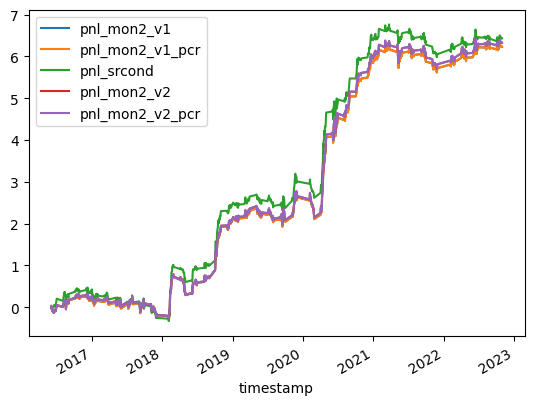

In [29]:
"""
    k-medoids  (non-cumulated returns., unsmoothed, euclidean distance)
"""
df_pnl_insample[['pnl_mon2_v1', 'pnl_mon2_v1_pcr', 'pnl_srcond', 'pnl_mon2_v2', 'pnl_mon2_v2_pcr']].cumsum().plot()
d = df_pnl_insample[['pnl_mon1_v1', 'pnl_mon1_v2', 'pnl_mon2_v1', 'pnl_mon2_v1_pcr', 'pnl_srcond', 'pnl_mon2_v2', 'pnl_mon2_v2_pcr']].describe().transpose()
d['asr'] = np.sqrt(252) * d['mean'] / d['std']
d

,count,mean,std,min,25%,50%,75%,max,asr
pnl_mon1_v1,794.0,0.055287,9.636535,-50.332458,-3.120973,-0.228511,2.894954,68.162203,0.091076
pnl_mon1_v2,794.0,0.000928,1.255578,-6.458518,-0.627258,0.004144,0.586085,6.928321,0.011728
pnl_mon2_v1,794.0,0.008150,0.057954,-0.211654,-0.023685,0.004847,0.033424,0.389356,2.232404
pnl_mon2_v1_pcr,794.0,0.008150,0.057954,-0.211654,-0.023685,0.004847,0.033424,0.389356,2.232404
pnl_srcond,785.0,0.008996,0.060314,-0.200523,-0.021182,0.004456,0.034622,0.362843,2.367611
pnl_mon2_v2,794.0,0.008220,0.057756,-0.208590,-0.022964,0.004586,0.033306,0.389766,2.259236
pnl_mon2_v2_pcr,794.0,0.008220,0.057756,-0.208590,-0.022964,0.004586,0.033306,0.389766,2.259236


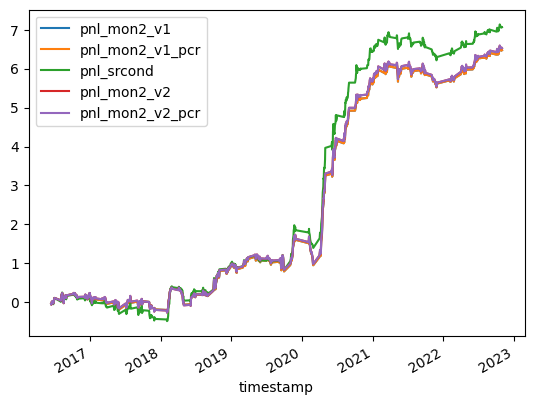

[0.5509259259259259, 357.0, 648]
[0.536547433903577, 345.0, 643]
[0.5768621236133122, 364.0, 631]
[0.536547433903577, 345.0, 643]
[0.5414110429447853, 353.0, 652]
[0.5233644859813084, 335.99999999999994, 642]
[0.5822368421052632, 354.0, 608]
[0.5822368421052632, 354.0, 608]
[0.49019607843137253, 325.0, 663]
[0.5470219435736677, 349.0, 638]
[0.5636942675159236, 354.0, 628]
[0.5345911949685535, 340.0, 636]
[0.5266362252663622, 346.0, 657]
[0.49633967789165445, 339.0, 683]


In [5]:
"""
    k-medoids (non-cumulated returns (mktadj), unsmoothed, euclidean distance)
"""
df_pnl_insample[['pnl_mon2_v1', 'pnl_mon2_v1_pcr', 'pnl_srcond', 'pnl_mon2_v2', 'pnl_mon2_v2_pcr']].cumsum().plot()
d = df_pnl_insample[['pnl_mon1_v1', 'pnl_mon1_v2', 'pnl_mon2_v1', 'pnl_mon2_v1_pcr', 'pnl_srcond', 'pnl_mon2_v2', 'pnl_mon2_v2_pcr']].describe().transpose()
d['asr'] = np.sqrt(252) * d['mean'] / d['std']
d

In [ ]:
df_pnl_insample[['pnl_mon1_v1']].cumsum().plot()

In [ ]:
df_pnl_insample.corr()

In [ ]:
df_pnl_insample_mktadj = df_pnl_insample[['pnl_mon2_v1_pcr', 'pnl_srcond']]
df_pnl_insample_mktadj

In [ ]:
df_pnl_insample_raw = df_pnl_insample[['pnl_mon2_v1_pcr', 'pnl_srcond']]
df_pnl_insample_raw

In [ ]:
dfz = tu.left_join(df_pnl_insample_mktadj, df_pnl_insample_raw, left_alias='_mktadj', right_alias='_raw')
dfz.corr()

In [ ]:
fcst_col = 'fcst_mon2_v1_pcr'
dff = df_fcst_insample[['SYMBOL', fcst_col]]
display(dff[[fcst_col]].describe().transpose())

dff[[fcst_col]].plot.hist(bins=50)

In [ ]:
ru.get_forecast_acf(df_fcst, secid="SYMBOL", fcst_colname="fcst_mon2_v1_pcr", max_lags=10)

#### test

In [ ]:
m1 = np.random.normal(10, 5, 100)
m2 = np.random.normal(0, 3, 200)

m = np.hstack([m1, m2])

C = np.zeros((m.shape[0], m.shape[0]))
for i in range(C.shape[0]):
    for j in range(C.shape[1]):
        C[i, j] = abs(m[i] - m[j])

C = C.flatten()
C = C[abs(C) > 0.0000001]
plt.hist(C)



#### test2

In [ ]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.3, random_state=0
)

X = StandardScaler().fit_transform(X)
display(X)

C = np.zeros((X.shape[0], X.shape[0]))
for i in range(X.shape[0]):
    for j in range(X.shape[0]):
        d_i = X[i,:]
        d_j = X[j,:]
        C[i,j] = np.sum((d_i - d_j) ** 2)
        
C = np.triu(C, k=0)
C = C.flatten()
C = C[abs(C) > 0.000000000000001]
plt.hist(C, bins=50)

In [ ]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

In [ ]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()